In [63]:
import pandas as pd
import numpy as np
import torch
import os
import optuna
import xgboost as xgb
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

In [2]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Baseline Model
### Dataset

In [79]:
class BaselineDataset(Dataset):
    def __init__(self, path=TRAIN_PATH):
        self.data = []
        self.target = []
        for file in os.listdir(path):
            df = pd.read_csv(path + file, sep='|')
            df = df.fillna(method='ffill') # if possible fill with previous value
            df = df.fillna(0) # else fill with 0
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            self.target.append(1 if sepsis_index else 0)
            self.data.append(torch.Tensor(df.drop('SepsisLabel', axis=1).iloc[-1] if sepsis_index is None else df.drop('SepsisLabel', axis=1).iloc[sepsis_index]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

### Model

In [119]:
class Model(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, output_size=2, activation='ReLU', dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.sequence = nn.Sequential(self.fc1, getattr(nn, activation)(), nn.Dropout(p=dropout), self.fc2, 
                                      getattr(nn, activation)(), nn.Dropout(p=dropout), self.fc3, getattr(nn, activation)())

    def forward(self, x):
        return self.sequence(x)

### Hyperparameter Tuning

In [80]:
train_set = BaselineDataset()
test_set = BaselineDataset(path=TEST_PATH)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [81]:
train_set[0][0].shape

torch.Size([40])

In [ ]:
count_zero = sum([1 for i in train_set.target if i == 0])
count_one = 20000 - count_zero

In [21]:
def train(loss_fn, optimizer, model,  train_dataloader, test_dataloader, device=device, epochs=20, save_best=False, save_name='best_baseline_model.pt', accumulate_grad=False, batch_size=32):
    train_losses = []
    test_losses = []
    train_f1_scores = []
    test_f1_scores = []
    max_f1_score = 0
    optimizer.zero_grad()
    for i in range(epochs):
        model.train()
        train_loss = 0
        train_f1_score = 0
        for j, data in enumerate(train_dataloader):
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            train_f1_score += f1_score(target.to(torch.device('cpu')), pred.to(torch.device('cpu')))
            loss = loss_fn(output, target)
            train_loss += loss.item()
            if accumulate_grad:
                loss = loss/batch_size
            loss.backward()
            if not accumulate_grad or j+1 % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
        if accumulate_grad and j+1 % batch_size != 0:
            optimizer.step()
            optimizer.zero_grad()
        train_f1_scores.append(train_f1_score/len(train_dataloader))
        train_losses.append(train_loss/len(train_dataloader))
        test_loss, test_f1_score = activity(model, test_dataloader, loss_fn, device)
        test_losses.append(test_loss)
        test_f1_scores.append(test_f1_score)
        if save_best and test_f1_score > max_f1_score:
            max_f1_score = test_f1_score
            torch.save(model, save_name)
        if ((i+1) % 1) == 0:
            print('Epoch: {} Train Loss: {} Test Loss: {}'.format(i+1, train_losses[-1], test_losses[-1]))
    return train_losses, test_losses, train_f1_scores, test_f1_scores

def activity(model, test_dataloader, loss_fn, device):
    model.eval()
    preds = []
    targets = []
    test_loss = 0
    test_f1_score = 0
    with torch.no_grad():
        for data in test_dataloader:
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            preds.append(pred)
            targets.append(target)
            loss = loss_fn(output, target)
            test_loss += loss.item()
        return test_loss/len(test_dataloader), f1_score(torch.cat(targets).to(torch.device('cpu')), torch.cat(preds).to(torch.device('cpu')))


In [123]:

def objective(trial):
    epochs = 15
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh', 'Sigmoid'])
    dropout = trial.suggest_float('dropout', 0, 0.5)
    model = Model(hidden_size=hidden_size, activation=activation, dropout=dropout).to(device)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(weight=torch.tensor([count_zero/count_zero, count_zero/count_one]).to(device))
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, device, epochs)
    return max(test_f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-05-07 14:47:03,546] A new study created in memory with name: no-name-6b3cb849-f54f-44fb-aad5-190f9ea65d84


Epoch: 1 Train Loss: 0.6751265309333802 Test Loss: 0.673073904963728
Epoch: 2 Train Loss: 0.667969174194336 Test Loss: 0.668050794365307
Epoch: 3 Train Loss: 0.6630003866195678 Test Loss: 0.658397915169073
Epoch: 4 Train Loss: 0.6520833705902099 Test Loss: 0.64939831678098
Epoch: 5 Train Loss: 0.6400787606716156 Test Loss: 0.6322405216412041
Epoch: 6 Train Loss: 0.6305445245742798 Test Loss: 0.6173921596889679
Epoch: 7 Train Loss: 0.6142606265068055 Test Loss: 0.609592998465791
Epoch: 8 Train Loss: 0.6054944540023803 Test Loss: 0.5979381280775649
Epoch: 9 Train Loss: 0.5984105907440186 Test Loss: 0.5913386371569892
Epoch: 10 Train Loss: 0.5908998592853546 Test Loss: 0.5847886587484196
Epoch: 11 Train Loss: 0.5856277533531189 Test Loss: 0.5888432189108084
Epoch: 12 Train Loss: 0.5840074746131897 Test Loss: 0.5856352486549475
Epoch: 13 Train Loss: 0.5811905416965485 Test Loss: 0.5834909512783392
Epoch: 14 Train Loss: 0.5791740300178528 Test Loss: 0.573745244988999


[I 2023-05-07 14:47:31,051] Trial 0 finished with value: 0.36338028169014086 and parameters: {'hidden_size': 299, 'activation': 'Sigmoid', 'dropout': 0.2341313081583729, 'optimizer': 'SGD', 'lr': 0.02308771797142592}. Best is trial 0 with value: 0.36338028169014086.


Epoch: 15 Train Loss: 0.5766406905174255 Test Loss: 0.5723576614270195
Epoch: 1 Train Loss: 0.9837821280479431 Test Loss: 0.693147187225354
Epoch: 2 Train Loss: 0.6929858085632324 Test Loss: 0.6931472066492318
Epoch: 3 Train Loss: 0.7011253905296325 Test Loss: 0.6931471904626669
Epoch: 4 Train Loss: 0.6928465410232544 Test Loss: 0.6931471836071806
Epoch: 5 Train Loss: 0.69263890209198 Test Loss: 0.6931471836071806
Epoch: 6 Train Loss: 0.7234750700950623 Test Loss: 0.693147188367935
Epoch: 7 Train Loss: 0.6927200839996338 Test Loss: 0.6931471965564325
Epoch: 8 Train Loss: 0.6926566619873047 Test Loss: 0.6931471815124487
Epoch: 9 Train Loss: 0.6919147536277771 Test Loss: 0.6931471855114824
Epoch: 10 Train Loss: 0.6911592943191528 Test Loss: 0.6909729794572337
Epoch: 11 Train Loss: 1.1489763630867005 Test Loss: 0.6931471900818066
Epoch: 12 Train Loss: 0.6930349601745606 Test Loss: 0.6931471830358902
Epoch: 13 Train Loss: 0.6929283584594726 Test Loss: 0.6931471830358902
Epoch: 14 Train Los

[I 2023-05-07 14:48:04,408] Trial 1 finished with value: 0.0 and parameters: {'hidden_size': 99, 'activation': 'ReLU', 'dropout': 0.3783250000412074, 'optimizer': 'Adagrad', 'lr': 0.07091959441780465}. Best is trial 0 with value: 0.36338028169014086.


Epoch: 15 Train Loss: 0.6927705614089966 Test Loss: 0.6931471879870746
Epoch: 1 Train Loss: nan Test Loss: nan
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 14:48:48,225] Trial 2 finished with value: 0.0 and parameters: {'hidden_size': 333, 'activation': 'LeakyReLU', 'dropout': 0.06483083388750893, 'optimizer': 'SGD', 'lr': 0.09730790591633032}. Best is trial 0 with value: 0.36338028169014086.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 16.648108158814907 Test Loss: 0.6475539198889139
Epoch: 2 Train Loss: 0.7684777076244355 Test Loss: 0.6590500396851915
Epoch: 3 Train Loss: 0.697176564502716 Test Loss: 0.6476276667354206
Epoch: 4 Train Loss: 0.6661272836208344 Test Loss: 0.6209361778851896
Epoch: 5 Train Loss: 0.6511888924598694 Test Loss: 0.603329001524197
Epoch: 6 Train Loss: 0.650271574497223 Test Loss: 0.5898727732725417
Epoch: 7 Train Loss: 0.6311310454845428 Test Loss: 0.600722116974596
Epoch: 8 Train Loss: 0.6192474018096924 Test Loss: 0.5699023716746808
Epoch: 9 Train Loss: 0.6052192871570587 Test Loss: 0.5592536210252074
Epoch: 10 Train Loss: 0.5957872455835342 Test Loss: 0.5632694408821222
Epoch: 11 Train Loss: 0.6419300121545791 Test Loss: 0.6094560723620862
Epoch: 12 Train Loss: 0.5966368093371391 Test Loss: 0.5559623614667704
Epoch: 13 Train Loss: 0.5839209097027779 Test Loss: 0.5292681625095038
Epoch: 14 Train Loss: 0.5776288018465042 Test Los

[I 2023-05-07 14:49:37,834] Trial 3 finished with value: 0.4226006191950465 and parameters: {'hidden_size': 348, 'activation': 'LeakyReLU', 'dropout': 0.3749369512512472, 'optimizer': 'Adagrad', 'lr': 0.09813681742416254}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: 0.5553154793262481 Test Loss: 0.5137230589652595
Epoch: 1 Train Loss: nan Test Loss: nan
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 14:50:19,842] Trial 4 finished with value: 0.0 and parameters: {'hidden_size': 116, 'activation': 'LeakyReLU', 'dropout': 0.44324000819674536, 'optimizer': 'SGD', 'lr': 0.06418977012439024}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.7361323916435242 Test Loss: 0.6901021034191972
Epoch: 2 Train Loss: 0.698334628868103 Test Loss: 0.6893320287378452
Epoch: 3 Train Loss: 0.6952689609527588 Test Loss: 0.6907699885078893
Epoch: 4 Train Loss: 0.6901608064651489 Test Loss: 0.6904982840672088
Epoch: 5 Train Loss: 0.6902372616767883 Test Loss: 0.690287566603944
Epoch: 6 Train Loss: 0.6905527740478515 Test Loss: 0.6904604067436804
Epoch: 7 Train Loss: 0.6900041229248047 Test Loss: 0.6903185648278306
Epoch: 8 Train Loss: 0.6901034066200257 Test Loss: 0.6899383706025803
Epoch: 9 Train Loss: 0.689834018611908 Test Loss: 0.6903633568614436
Epoch: 10 Train Loss: 0.6896419122695923 Test Loss: 0.6901441191712888
Epoch: 11 Train Loss: 0.6922256068229675 Test Loss: 0.6902245286935434
Epoch: 12 Train Loss: 0.6935029104232788 Test Loss: 0.6904015270665812
Epoch: 13 Train Loss: 0.6901192391395569 Test Loss: 0.690200402523382
Epoch: 14 Train Loss: 0.6913886754989624 Test Los

[I 2023-05-07 14:51:12,664] Trial 5 finished with value: 0.0 and parameters: {'hidden_size': 468, 'activation': 'ReLU', 'dropout': 0.2781181102277802, 'optimizer': 'Adagrad', 'lr': 0.0024865792354025014}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: 0.6900909375190735 Test Loss: 0.6903943945043765
Epoch: 1 Train Loss: 0.6953423962593078 Test Loss: 0.6931471729430908
Epoch: 2 Train Loss: 0.6931471952438355 Test Loss: 0.6931471936999799
Epoch: 3 Train Loss: 0.6931471956253051 Test Loss: 0.6931471857019126
Epoch: 4 Train Loss: 0.6931472010612488 Test Loss: 0.693147187225354
Epoch: 5 Train Loss: 0.6931471967697144 Test Loss: 0.6931471904626669
Epoch: 6 Train Loss: 0.6931472030639648 Test Loss: 0.6931471797985772
Epoch: 7 Train Loss: 0.6931471845626831 Test Loss: 0.6931471870349238
Epoch: 8 Train Loss: 0.6931471925735474 Test Loss: 0.6931471847497617
Epoch: 9 Train Loss: 0.6931471927642823 Test Loss: 0.6931471853210522
Epoch: 10 Train Loss: 0.6931471970558166 Test Loss: 0.6931471902722368
Epoch: 11 Train Loss: 0.6931471893310547 Test Loss: 0.6931471904626669
Epoch: 12 Train Loss: 0.6931471950531006 Test Loss: 0.6931471786559961
Epoch: 13 Train Loss: 0.6931471985816956 Test Loss: 0.6931471868444936
Epoch: 14 Train 

[I 2023-05-07 14:51:42,511] Trial 6 finished with value: 0.0 and parameters: {'hidden_size': 102, 'activation': 'ReLU', 'dropout': 0.07548412712871988, 'optimizer': 'SGD', 'lr': 0.01153739196097976}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: 0.6931471861839295 Test Loss: 0.6931471746569624
Epoch: 1 Train Loss: 0.6997095768928527 Test Loss: 0.6931472011267568
Epoch: 2 Train Loss: 0.6931472012519836 Test Loss: 0.6931471936999799
Epoch: 3 Train Loss: 0.6931472032546997 Test Loss: 0.6931471809411582
Epoch: 4 Train Loss: 0.6931471954345703 Test Loss: 0.6931471870349238
Epoch: 5 Train Loss: 0.6931471955299378 Test Loss: 0.6931472001746058
Epoch: 6 Train Loss: 0.693157495212555 Test Loss: 0.6931472011267568
Epoch: 7 Train Loss: 0.6931471961021424 Test Loss: 0.6931471761804038
Epoch: 8 Train Loss: 0.6931472031593323 Test Loss: 0.6931471855114824
Epoch: 9 Train Loss: 0.6931471955299378 Test Loss: 0.6931471792272866
Epoch: 10 Train Loss: 0.6931471895217896 Test Loss: 0.693147185130622
Epoch: 11 Train Loss: 0.6931472031593323 Test Loss: 0.6931471893200859
Epoch: 12 Train Loss: 0.6931471990585327 Test Loss: 0.693147188367935
Epoch: 13 Train Loss: 0.6931471954345703 Test Loss: 0.6931471889392256
Epoch: 14 Train Lo

[I 2023-05-07 14:52:08,433] Trial 7 finished with value: 0.0 and parameters: {'hidden_size': 40, 'activation': 'ReLU', 'dropout': 0.0250136750941074, 'optimizer': 'SGD', 'lr': 0.03834933098678228}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: 0.6931471912384033 Test Loss: 0.6931471744665323
Epoch: 1 Train Loss: 0.8785837010383606 Test Loss: 0.6931471761804038
Epoch: 2 Train Loss: 0.693147199344635 Test Loss: 0.6931471952234214
Epoch: 3 Train Loss: 0.6931472054481507 Test Loss: 0.6931471874157842
Epoch: 4 Train Loss: 0.6931471926689148 Test Loss: 0.6931471864636333
Epoch: 5 Train Loss: 0.6931471961021424 Test Loss: 0.6931471938904101
Epoch: 6 Train Loss: 0.6931471988677979 Test Loss: 0.6931471874157842
Epoch: 7 Train Loss: 0.6931471886634827 Test Loss: 0.6931471868444936
Epoch: 8 Train Loss: 0.6931471998214722 Test Loss: 0.6931471933191196
Epoch: 9 Train Loss: 0.6931471974372864 Test Loss: 0.6931471822741694
Epoch: 10 Train Loss: 0.6931472004890442 Test Loss: 0.6931471870349238
Epoch: 11 Train Loss: 0.6931471927642823 Test Loss: 0.6931471849401919
Epoch: 12 Train Loss: 0.6931471899986267 Test Loss: 0.6931471931286894
Epoch: 13 Train Loss: 0.6931471966743469 Test Loss: 0.6931471830358902
Epoch: 14 Train 

[I 2023-05-07 14:52:34,739] Trial 8 finished with value: 0.0 and parameters: {'hidden_size': 326, 'activation': 'ReLU', 'dropout': 0.43067573458487757, 'optimizer': 'SGD', 'lr': 0.0819612354758466}. Best is trial 3 with value: 0.4226006191950465.


Epoch: 15 Train Loss: 0.6931471975326539 Test Loss: 0.693147179608147
Epoch: 1 Train Loss: 0.8608809113740921 Test Loss: 0.6415132640268856
Epoch: 2 Train Loss: 0.6868420143246651 Test Loss: 0.5544015735673448
Epoch: 3 Train Loss: 0.6916369832590222 Test Loss: 0.5460408627986908
Epoch: 4 Train Loss: 0.5679392099738121 Test Loss: 0.5155034851723205
Epoch: 5 Train Loss: 0.5194523096323014 Test Loss: 0.44964438862503525
Epoch: 6 Train Loss: 0.47694170483350756 Test Loss: 0.4370422705103414
Epoch: 7 Train Loss: 0.7210135119952261 Test Loss: 0.5572674541046825
Epoch: 8 Train Loss: 0.9062768333315849 Test Loss: 0.4806315165024977
Epoch: 9 Train Loss: 0.5345996333241463 Test Loss: 0.4464474072376379
Epoch: 10 Train Loss: 0.7750850825101138 Test Loss: 0.4719287546964499
Epoch: 11 Train Loss: 0.9093102917551994 Test Loss: 0.8621568012411316
Epoch: 12 Train Loss: 0.6069487644702196 Test Loss: 0.48420340948687574
Epoch: 13 Train Loss: 0.5786562337577343 Test Loss: 0.49436934011431927
Epoch: 14 Tr

[I 2023-05-07 14:53:01,698] Trial 9 finished with value: 0.5322338830584709 and parameters: {'hidden_size': 188, 'activation': 'LeakyReLU', 'dropout': 0.05482411525590847, 'optimizer': 'Adam', 'lr': 0.010733295315660883}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.729429311516881 Test Loss: 0.5054259839625405
Epoch: 1 Train Loss: 0.6968555593729019 Test Loss: 0.6931476621582104
Epoch: 2 Train Loss: 0.6931483422279358 Test Loss: 0.6931470703012266
Epoch: 3 Train Loss: 0.6931475896835327 Test Loss: 0.693147143807274
Epoch: 4 Train Loss: 0.693147382736206 Test Loss: 0.6931471672301857
Epoch: 5 Train Loss: 0.693147301197052 Test Loss: 0.6931471704674986
Epoch: 6 Train Loss: 0.6931472516059876 Test Loss: 0.6931471582799674
Epoch: 7 Train Loss: 0.6931472185134888 Test Loss: 0.6931471959851421
Epoch: 8 Train Loss: 0.6931472180366516 Test Loss: 0.6931471997937455
Epoch: 9 Train Loss: 0.6931471977233886 Test Loss: 0.693147187225354
Epoch: 10 Train Loss: 0.6931472182273865 Test Loss: 0.6931471967468628
Epoch: 11 Train Loss: 0.6931472121238709 Test Loss: 0.6931471834167505
Epoch: 12 Train Loss: 0.6931471876144409 Test Loss: 0.6931471767516943
Epoch: 13 Train Loss: 0.69314719581604 Test Loss: 0.6931471874157842
Epoch: 14 Train Loss: 

[I 2023-05-07 14:53:29,468] Trial 10 finished with value: 0.11959383226776983 and parameters: {'hidden_size': 202, 'activation': 'Tanh', 'dropout': 0.1448765941072913, 'optimizer': 'Adam', 'lr': 0.03514604306100587}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931472006797791 Test Loss: 0.6931471830358902
Epoch: 1 Train Loss: 28.236159990119933 Test Loss: 5.49026634468778
Epoch: 2 Train Loss: 21.28240127914846 Test Loss: 10.826694670583496
Epoch: 3 Train Loss: 40.181599429430065 Test Loss: 10.515543422942683
Epoch: 4 Train Loss: 24.89036120858173 Test Loss: 24.26935120976627
Epoch: 5 Train Loss: 66.27176673760738 Test Loss: 3.74189630693521
Epoch: 6 Train Loss: 35.2307970028969 Test Loss: 5.527954966877215
Epoch: 7 Train Loss: 30.551063126064733 Test Loss: 32.02348664991663
Epoch: 8 Train Loss: 41.95348660746277 Test Loss: 7.521858666461116
Epoch: 9 Train Loss: 35.14126416813135 Test Loss: 5.859880057386697
Epoch: 10 Train Loss: 38.1138382717669 Test Loss: 160.2547201683727
Epoch: 11 Train Loss: 35.78523335197568 Test Loss: 23.25144850809495
Epoch: 12 Train Loss: 446.7760536672889 Test Loss: 292.37010653653084
Epoch: 13 Train Loss: 305.21594651870726 Test Loss: 516.9592440087997
Epoch: 14 Train Loss: 215.288480258941

[I 2023-05-07 14:53:56,231] Trial 11 finished with value: 0.19783873649210307 and parameters: {'hidden_size': 430, 'activation': 'LeakyReLU', 'dropout': 0.3256095416651454, 'optimizer': 'Adam', 'lr': 0.05091049622981506}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 74.99637922100068 Test Loss: 9.385576552857225
Epoch: 1 Train Loss: 37.81405816106258 Test Loss: 33.242679423819936
Epoch: 2 Train Loss: 13.765610689967312 Test Loss: 1.6241843566155663
Epoch: 3 Train Loss: 2017.4743265474915 Test Loss: 284.8245054494839
Epoch: 4 Train Loss: 1457.0034162506104 Test Loss: 416.9351553383727
Epoch: 5 Train Loss: 302.2052875782013 Test Loss: 340.74073177252336
Epoch: 6 Train Loss: 121.11549195559174 Test Loss: 78.58892163504382
Epoch: 7 Train Loss: 83.22046321142614 Test Loss: 48.29836766178997
Epoch: 8 Train Loss: 471.3771789671271 Test Loss: 335.0103920641037
Epoch: 9 Train Loss: 591.9502550367594 Test Loss: 232.06662861150676
Epoch: 10 Train Loss: 973.8607169496782 Test Loss: 1254.1136732985037
Epoch: 11 Train Loss: 453.62217741851805 Test Loss: 104.9815155959044
Epoch: 12 Train Loss: 221.9717433634095 Test Loss: 79.4679970891328
Epoch: 13 Train Loss: 330.55016140735745 Test Loss: 22.003401131433588
Epoch: 14 Train Loss: 251.482478

[I 2023-05-07 14:54:19,879] Trial 12 finished with value: 0.1928523263654754 and parameters: {'hidden_size': 220, 'activation': 'LeakyReLU', 'dropout': 0.18481569657425467, 'optimizer': 'Adam', 'lr': 0.09826700007054436}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 301.58742188796094 Test Loss: 259.2931185110737
Epoch: 1 Train Loss: 0.8595316846370697 Test Loss: 0.6090889119873413
Epoch: 2 Train Loss: 0.6212402194976807 Test Loss: 0.5713943162569984
Epoch: 3 Train Loss: 0.6025411036014557 Test Loss: 0.5522514455996382
Epoch: 4 Train Loss: 0.5914539196014404 Test Loss: 0.5491015306962564
Epoch: 5 Train Loss: 0.5662025769472122 Test Loss: 0.552534787656781
Epoch: 6 Train Loss: 0.5573732820272446 Test Loss: 0.5351354342680008
Epoch: 7 Train Loss: 0.5541309153795242 Test Loss: 0.5284128430457161
Epoch: 8 Train Loss: 0.5480400368928909 Test Loss: 0.525352597474671
Epoch: 9 Train Loss: 0.5403576728582382 Test Loss: 0.520244839520881
Epoch: 10 Train Loss: 0.5292377823114395 Test Loss: 0.5318457602312009
Epoch: 11 Train Loss: 0.5240062274694443 Test Loss: 0.5034506060540105
Epoch: 12 Train Loss: 0.5170921011924744 Test Loss: 0.4953285167678096
Epoch: 13 Train Loss: 0.511580733203888 Test Loss: 0.4985768451286962
Epoch: 14 Train Loss

[I 2023-05-07 14:54:46,290] Trial 13 finished with value: 0.46368305209097577 and parameters: {'hidden_size': 382, 'activation': 'LeakyReLU', 'dropout': 0.4843711058515886, 'optimizer': 'Adagrad', 'lr': 0.020715724608797212}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.49507236564159396 Test Loss: 0.4724745236265774
Epoch: 1 Train Loss: 0.642440547990799 Test Loss: 0.6057714386679494
Epoch: 2 Train Loss: 0.5981297822952271 Test Loss: 0.5694787828876569
Epoch: 3 Train Loss: 0.5891893066167831 Test Loss: 0.5430782467793351
Epoch: 4 Train Loss: 0.5657966897726059 Test Loss: 0.5318145739575164
Epoch: 5 Train Loss: 0.5660060240268707 Test Loss: 0.5262131660034101
Epoch: 6 Train Loss: 0.5492452099323273 Test Loss: 0.5440470266361206
Epoch: 7 Train Loss: 0.5531998517274856 Test Loss: 0.5426243603610383
Epoch: 8 Train Loss: 0.5430585720062255 Test Loss: 0.5134378728775171
Epoch: 9 Train Loss: 0.5410989238023758 Test Loss: 0.5077507402569341
Epoch: 10 Train Loss: 0.5322634410858155 Test Loss: 0.5031045758590912
Epoch: 11 Train Loss: 0.5272172116041184 Test Loss: 0.5070095526429411
Epoch: 12 Train Loss: 0.5091967457532882 Test Loss: 0.49825924268355387
Epoch: 13 Train Loss: 0.5173205603122711 Test Loss: 0.503633968365459
Epoch: 14 Train

[I 2023-05-07 14:55:18,066] Trial 14 finished with value: 0.48653846153846153 and parameters: {'hidden_size': 393, 'activation': 'Tanh', 'dropout': 0.4774610136839839, 'optimizer': 'Adam', 'lr': 0.00046260777273726336}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.5109203462600708 Test Loss: 0.4960469783971104
Epoch: 1 Train Loss: 0.646653755736351 Test Loss: 0.6186287989155553
Epoch: 2 Train Loss: 0.5817292373657227 Test Loss: 0.5781108020974425
Epoch: 3 Train Loss: 0.5540208314418793 Test Loss: 0.5260536313628237
Epoch: 4 Train Loss: 0.5384225158691406 Test Loss: 0.5223391321234809
Epoch: 5 Train Loss: 0.5197996362924576 Test Loss: 0.5111704628688459
Epoch: 6 Train Loss: 0.5218777968168259 Test Loss: 0.5169449782314391
Epoch: 7 Train Loss: 0.5079837850809097 Test Loss: 0.4862093510814368
Epoch: 8 Train Loss: 0.5091888068199157 Test Loss: 0.5146090438762031
Epoch: 9 Train Loss: 0.4925888386726379 Test Loss: 0.5509300719434842
Epoch: 10 Train Loss: 0.4827581548690796 Test Loss: 0.46254794794720966
Epoch: 11 Train Loss: 0.4765388329744339 Test Loss: 0.4592401805205848
Epoch: 12 Train Loss: 0.4798684800863266 Test Loss: 0.47089900495335696
Epoch: 13 Train Loss: 0.46909606573581697 Test Loss: 0.4603874430107994
Epoch: 14 Tra

[I 2023-05-07 14:56:05,744] Trial 15 finished with value: 0.4965517241379311 and parameters: {'hidden_size': 510, 'activation': 'Tanh', 'dropout': 0.0016025988079678352, 'optimizer': 'Adam', 'lr': 0.0007673775543008839}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.4698383548736572 Test Loss: 0.46560536377346173
Epoch: 1 Train Loss: 0.8393814307928086 Test Loss: 0.9570314107706752
Epoch: 2 Train Loss: 0.9396484868526459 Test Loss: 0.9590698306362468
Epoch: 3 Train Loss: 0.9287711283922195 Test Loss: 0.9569892847595124
Epoch: 4 Train Loss: 0.9326904340744019 Test Loss: 0.955587766279047
Epoch: 5 Train Loss: 0.9347439979553223 Test Loss: 0.9539089449487936
Epoch: 6 Train Loss: 0.9334378678321839 Test Loss: 0.9542389466834906
Epoch: 7 Train Loss: 0.9306014468669891 Test Loss: 0.9834688122565753
Epoch: 8 Train Loss: 0.9387183602571487 Test Loss: 0.9621017978499873
Epoch: 9 Train Loss: 0.9309052769422531 Test Loss: 0.9514044247591458
Epoch: 10 Train Loss: 0.9332745045423507 Test Loss: 0.9637397084944546
Epoch: 11 Train Loss: 0.9354012517690659 Test Loss: 0.9620730005704556
Epoch: 12 Train Loss: 0.9379640849113464 Test Loss: 0.9659100411513362
Epoch: 13 Train Loss: 0.9319502618312836 Test Loss: 0.9684025619071893
Epoch: 14 Train

[I 2023-05-07 14:56:54,714] Trial 16 finished with value: 0.0 and parameters: {'hidden_size': 512, 'activation': 'Tanh', 'dropout': 0.010182671669464894, 'optimizer': 'Adam', 'lr': 0.01691281849498289}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.9422052430868149 Test Loss: 0.968640796197489
Epoch: 1 Train Loss: 0.6785303439617157 Test Loss: 0.6798673468275954
Epoch: 2 Train Loss: 0.6792499269008636 Test Loss: 0.6791957719638325
Epoch: 3 Train Loss: 0.6790315723419189 Test Loss: 0.677233707219267
Epoch: 4 Train Loss: 0.679512339925766 Test Loss: 0.6801549493314359
Epoch: 5 Train Loss: 0.6771221239089966 Test Loss: 0.681601464177092
Epoch: 6 Train Loss: 0.6774833141326905 Test Loss: 0.6837629371176893
Epoch: 7 Train Loss: 0.6786652827739715 Test Loss: 0.6834662042486782
Epoch: 8 Train Loss: 0.6785798956871033 Test Loss: 0.678905839737231
Epoch: 9 Train Loss: 0.6776750181674958 Test Loss: 0.6985214599214804
Epoch: 10 Train Loss: 0.6773408569335938 Test Loss: 0.6900166497824672
Epoch: 11 Train Loss: 0.6799819088935852 Test Loss: 0.680854750327028
Epoch: 12 Train Loss: 0.6790641941070557 Test Loss: 0.6931346807236107
Epoch: 13 Train Loss: 0.680736573934555 Test Loss: 0.6793711891951272
Epoch: 14 Train Loss: 

[I 2023-05-07 14:57:44,425] Trial 17 finished with value: 0.0 and parameters: {'hidden_size': 221, 'activation': 'Sigmoid', 'dropout': 0.11190693767891796, 'optimizer': 'Adam', 'lr': 0.00845510063693325}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6776770570755005 Test Loss: 0.6799576132061382
Epoch: 1 Train Loss: 0.6216010893821716 Test Loss: 0.5845455740587399
Epoch: 2 Train Loss: 0.5790437124729156 Test Loss: 0.57615603682713
Epoch: 3 Train Loss: 0.5611667800426483 Test Loss: 0.5671480213300869
Epoch: 4 Train Loss: 0.5429575583934784 Test Loss: 0.5591785816338878
Epoch: 5 Train Loss: 0.5294424083709717 Test Loss: 0.5618538064316819
Epoch: 6 Train Loss: 0.5166068641901016 Test Loss: 0.5567203252650679
Epoch: 7 Train Loss: 0.5068305584430695 Test Loss: 0.5418314561485863
Epoch: 8 Train Loss: 0.4957812617063522 Test Loss: 0.5403377652263489
Epoch: 9 Train Loss: 0.4914408725500107 Test Loss: 0.5407760191363649
Epoch: 10 Train Loss: 0.4831134770154953 Test Loss: 0.5387607507241039
Epoch: 11 Train Loss: 0.4736264332532883 Test Loss: 0.5335949374654423
Epoch: 12 Train Loss: 0.4646539757490158 Test Loss: 0.5452016118330697
Epoch: 13 Train Loss: 0.4600523419618607 Test Loss: 0.5334854757728668
Epoch: 14 Train L

[I 2023-05-07 14:58:31,940] Trial 18 finished with value: 0.34490740740740744 and parameters: {'hidden_size': 165, 'activation': 'Tanh', 'dropout': 0.009603705660070627, 'optimizer': 'Adam', 'lr': 0.00016983095673223265}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.452381609916687 Test Loss: 0.5365582466982424
Epoch: 1 Train Loss: 0.6947954248428345 Test Loss: 0.6931471849401919
Epoch: 2 Train Loss: 0.6931471999168396 Test Loss: 0.6931471750378227
Epoch: 3 Train Loss: 0.6931472047805786 Test Loss: 0.6931471803698677
Epoch: 4 Train Loss: 0.693147198009491 Test Loss: 0.6931471887487954
Epoch: 5 Train Loss: 0.6931472024917602 Test Loss: 0.6931471904626669
Epoch: 6 Train Loss: 0.6931471957206726 Test Loss: 0.6931471877966445
Epoch: 7 Train Loss: 0.6931471942901611 Test Loss: 0.6931471729430908
Epoch: 8 Train Loss: 0.6931471966743469 Test Loss: 0.6931471830358902
Epoch: 9 Train Loss: 0.6931471976280212 Test Loss: 0.6931471959851421
Epoch: 10 Train Loss: 0.6931471936225891 Test Loss: 0.6931471902722368
Epoch: 11 Train Loss: 0.6931472040176392 Test Loss: 0.6931471982703041
Epoch: 12 Train Loss: 0.6931472023010254 Test Loss: 0.6931471954138515
Epoch: 13 Train Loss: 0.6931471948623658 Test Loss: 0.6931471877966445
Epoch: 14 Train L

[I 2023-05-07 14:59:17,724] Trial 19 finished with value: 0.0 and parameters: {'hidden_size': 262, 'activation': 'Tanh', 'dropout': 0.08021013255778806, 'optimizer': 'Adam', 'lr': 0.02690875937566595}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931471933364868 Test Loss: 0.6931471904626669
Epoch: 1 Train Loss: 0.6854788092136384 Test Loss: 0.7015231406917206
Epoch: 2 Train Loss: 0.6882708956241608 Test Loss: 0.6871800672131986
Epoch: 3 Train Loss: 0.6853747725963593 Test Loss: 0.6781732184818378
Epoch: 4 Train Loss: 0.6827545349597931 Test Loss: 0.6965967383438025
Epoch: 5 Train Loss: 0.6845756262302398 Test Loss: 0.6817159033811893
Epoch: 6 Train Loss: 0.6873991650104523 Test Loss: 0.6902199065723358
Epoch: 7 Train Loss: 0.6875368729114533 Test Loss: 0.6783932279854917
Epoch: 8 Train Loss: 0.6880980621337891 Test Loss: 0.6764566490825373
Epoch: 9 Train Loss: 0.6868812846183777 Test Loss: 0.6791266593308495
Epoch: 10 Train Loss: 0.6873643667697906 Test Loss: 0.6896225023574342
Epoch: 11 Train Loss: 0.6863862144947052 Test Loss: 0.690296830270237
Epoch: 12 Train Loss: 0.6896479893684387 Test Loss: 0.6935170492805993
Epoch: 13 Train Loss: 0.688990412569046 Test Loss: 0.6796703332910141
Epoch: 14 Train L

[I 2023-05-07 14:59:56,884] Trial 20 finished with value: 0.0 and parameters: {'hidden_size': 272, 'activation': 'Sigmoid', 'dropout': 0.15840343543002092, 'optimizer': 'Adam', 'lr': 0.012509058515611007}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.686942562007904 Test Loss: 0.6849089337233156
Epoch: 1 Train Loss: 0.6977355296850204 Test Loss: 0.6931517773542922
Epoch: 2 Train Loss: 0.6931499676704407 Test Loss: 0.6931476905323065
Epoch: 3 Train Loss: 0.6931475726127625 Test Loss: 0.6931470324056217
Epoch: 4 Train Loss: 0.6931460339546204 Test Loss: 0.6931397120792645
Epoch: 5 Train Loss: 0.6933104263305664 Test Loss: 0.6931471912243876
Epoch: 6 Train Loss: 0.693147190952301 Test Loss: 0.6931471788464263
Epoch: 7 Train Loss: 0.6931472005844116 Test Loss: 0.6931471788464263
Epoch: 8 Train Loss: 0.6931471976280212 Test Loss: 0.6931472003650361
Epoch: 9 Train Loss: 0.6931471989631652 Test Loss: 0.6931471923669688
Epoch: 10 Train Loss: 0.6931471948623658 Test Loss: 0.6931471853210522
Epoch: 11 Train Loss: 0.6931472016334533 Test Loss: 0.6931471849401919
Epoch: 12 Train Loss: 0.6931472002983093 Test Loss: 0.6931471832263203
Epoch: 13 Train Loss: 0.6931471959114075 Test Loss: 0.6931471868444936
Epoch: 14 Train L

[I 2023-05-07 15:00:49,382] Trial 21 finished with value: 0.11959383226776983 and parameters: {'hidden_size': 406, 'activation': 'Tanh', 'dropout': 0.20879786252897364, 'optimizer': 'Adam', 'lr': 0.004527212587591858}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931471959114075 Test Loss: 0.6931471822741694
Epoch: 1 Train Loss: 0.6939507734298707 Test Loss: 0.6875952476510605
Epoch: 2 Train Loss: 0.683239315032959 Test Loss: 0.686479994664177
Epoch: 3 Train Loss: 0.6840271916389465 Test Loss: 0.6796927369250276
Epoch: 4 Train Loss: 0.6802998171329498 Test Loss: 0.6834306058030539
Epoch: 5 Train Loss: 0.678691426563263 Test Loss: 0.6794149649981112
Epoch: 6 Train Loss: 0.6733688381195069 Test Loss: 0.6835640228975314
Epoch: 7 Train Loss: 0.6746441252708435 Test Loss: 0.6721567925744163
Epoch: 8 Train Loss: 0.6716758255720139 Test Loss: 0.6722298210230879
Epoch: 9 Train Loss: 0.6720097010612488 Test Loss: 0.6769288426961381
Epoch: 10 Train Loss: 0.6732032871246338 Test Loss: 0.67590140515623
Epoch: 11 Train Loss: 0.6722179318904876 Test Loss: 0.6735551651483908
Epoch: 12 Train Loss: 0.6709971451759338 Test Loss: 0.670766211260622
Epoch: 13 Train Loss: 0.6712764744758606 Test Loss: 0.6754137512784415
Epoch: 14 Train Loss:

[I 2023-05-07 15:01:16,651] Trial 22 finished with value: 0.1782544378698225 and parameters: {'hidden_size': 490, 'activation': 'Tanh', 'dropout': 0.12149328763140374, 'optimizer': 'Adam', 'lr': 0.001326929462119852}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6812744544029236 Test Loss: 0.6749494605171033
Epoch: 1 Train Loss: 0.869485167336464 Test Loss: 0.9578969873273715
Epoch: 2 Train Loss: 0.9392686658859253 Test Loss: 0.9644759019342856
Epoch: 3 Train Loss: 0.9366882150411606 Test Loss: 0.9694627885715649
Epoch: 4 Train Loss: 0.9409368642568589 Test Loss: 0.953674340305237
Epoch: 5 Train Loss: 0.9374090286970138 Test Loss: 0.9479267073991581
Epoch: 6 Train Loss: 0.9383287809610367 Test Loss: 0.9536563839775305
Epoch: 7 Train Loss: 0.9315274935722351 Test Loss: 0.9337334489098753
Epoch: 8 Train Loss: 0.9374396369457245 Test Loss: 0.9556189597890781
Epoch: 9 Train Loss: 0.9361984591722489 Test Loss: 0.961307744819897
Epoch: 10 Train Loss: 0.9292127873182296 Test Loss: 0.9553747934083969
Epoch: 11 Train Loss: 0.9362702295780182 Test Loss: 0.948708820219238
Epoch: 12 Train Loss: 0.9332772651910782 Test Loss: 0.9485817924855997
Epoch: 13 Train Loss: 0.9371715564489365 Test Loss: 0.9543707786371913
Epoch: 14 Train Los

[I 2023-05-07 15:01:42,161] Trial 23 finished with value: 0.0 and parameters: {'hidden_size': 427, 'activation': 'Tanh', 'dropout': 0.25842802177196816, 'optimizer': 'Adam', 'lr': 0.011599360359287783}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.9393762513875962 Test Loss: 0.9402717432846277
Epoch: 1 Train Loss: 0.7018789322853088 Test Loss: 0.6931472055066508
Epoch: 2 Train Loss: 0.6931471981048584 Test Loss: 0.6931471817028789
Epoch: 3 Train Loss: 0.693147197341919 Test Loss: 0.6931471879870746
Epoch: 4 Train Loss: 0.693147193813324 Test Loss: 0.6931471929382592
Epoch: 5 Train Loss: 0.6931472073554993 Test Loss: 0.6931471853210522
Epoch: 6 Train Loss: 0.6931471969604492 Test Loss: 0.6931471917956782
Epoch: 7 Train Loss: 0.6931472019195557 Test Loss: 0.6931471874157842
Epoch: 8 Train Loss: 0.6931471955299378 Test Loss: 0.693147180750728
Epoch: 9 Train Loss: 0.6931471992492676 Test Loss: 0.693147187225354
Epoch: 10 Train Loss: 0.6931471908569335 Test Loss: 0.6931471965564325
Epoch: 11 Train Loss: 0.6931471977233886 Test Loss: 0.6931471876062143
Epoch: 12 Train Loss: 0.6931471983909607 Test Loss: 0.6931471929382592
Epoch: 13 Train Loss: 0.6931471964836121 Test Loss: 0.6931471759899737
Epoch: 14 Train Los

[I 2023-05-07 15:02:07,712] Trial 24 finished with value: 0.0 and parameters: {'hidden_size': 443, 'activation': 'Tanh', 'dropout': 0.04384947908620059, 'optimizer': 'Adam', 'lr': 0.016185119139466936}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931471952438355 Test Loss: 0.6931471849401919
Epoch: 1 Train Loss: 0.7016174017906189 Test Loss: 0.6931473843205851
Epoch: 2 Train Loss: 0.6929082057952881 Test Loss: 0.6931471735143814
Epoch: 3 Train Loss: 0.6931471961975098 Test Loss: 0.6931471881775049
Epoch: 4 Train Loss: 0.6931472023010254 Test Loss: 0.6931471790368564
Epoch: 5 Train Loss: 0.6931471898078918 Test Loss: 0.693147179608147
Epoch: 6 Train Loss: 0.6931471963882446 Test Loss: 0.6931471778942754
Epoch: 7 Train Loss: 0.6931471907615662 Test Loss: 0.6931471870349238
Epoch: 8 Train Loss: 0.6931471963882446 Test Loss: 0.6931471917956782
Epoch: 9 Train Loss: 0.6931471926689148 Test Loss: 0.6931471885583652
Epoch: 10 Train Loss: 0.6931471995353699 Test Loss: 0.693147202459768
Epoch: 11 Train Loss: 0.6931472001075745 Test Loss: 0.6931471864636333
Epoch: 12 Train Loss: 0.6931471979141235 Test Loss: 0.6931471900818066
Epoch: 13 Train Loss: 0.6931471927642823 Test Loss: 0.6931471769421246
Epoch: 14 Train L

[I 2023-05-07 15:02:33,093] Trial 25 finished with value: 0.11959383226776983 and parameters: {'hidden_size': 376, 'activation': 'Tanh', 'dropout': 0.0035885539705787814, 'optimizer': 'Adam', 'lr': 0.008438709223137376}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931471970558166 Test Loss: 0.6931471855114824
Epoch: 1 Train Loss: 0.628910877752304 Test Loss: 0.5857000905103957
Epoch: 2 Train Loss: 0.5863831581354141 Test Loss: 0.5543045970007253
Epoch: 3 Train Loss: 0.5684639060258866 Test Loss: 0.5389089335839208
Epoch: 4 Train Loss: 0.5465762714385987 Test Loss: 0.5271022333123814
Epoch: 5 Train Loss: 0.5387685566425323 Test Loss: 0.5098463052187484
Epoch: 6 Train Loss: 0.526663229060173 Test Loss: 0.522137460998072
Epoch: 7 Train Loss: 0.5155451105594635 Test Loss: 0.5064869892959016
Epoch: 8 Train Loss: 0.5175846064567566 Test Loss: 0.49127135113976633
Epoch: 9 Train Loss: 0.5209155312299728 Test Loss: 0.48429197120590334
Epoch: 10 Train Loss: 0.5038564776659011 Test Loss: 0.49820672180325076
Epoch: 11 Train Loss: 0.5064252554893494 Test Loss: 0.48519214825889173
Epoch: 12 Train Loss: 0.5022317051887513 Test Loss: 0.4855329038236088
Epoch: 13 Train Loss: 0.4906262561559677 Test Loss: 0.4791657337651085
Epoch: 14 Trai

[I 2023-05-07 15:02:58,533] Trial 26 finished with value: 0.48049921996879874 and parameters: {'hidden_size': 167, 'activation': 'Tanh', 'dropout': 0.196156172353664, 'optimizer': 'Adam', 'lr': 0.0005484672808929}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.48643973433971405 Test Loss: 0.47523251518654747
Epoch: 1 Train Loss: 1.6153566347749904 Test Loss: 1.2606539527257792
Epoch: 2 Train Loss: 22.52440053022 Test Loss: 6.729192382882614
Epoch: 3 Train Loss: 3.897031881635636 Test Loss: 1.2859224270517453
Epoch: 4 Train Loss: 3.0901084531694614 Test Loss: 3.18462479212644
Epoch: 5 Train Loss: 2.1115262611831773 Test Loss: 1.4004356740860822
Epoch: 6 Train Loss: 4.794419019106636 Test Loss: 2.1441017926310577
Epoch: 7 Train Loss: 2.1743006741864868 Test Loss: 4.116687407508826
Epoch: 8 Train Loss: 5.266515187529509 Test Loss: 26.87594384768198
Epoch: 9 Train Loss: 91.85753564789539 Test Loss: 9.67121635159473
Epoch: 10 Train Loss: 14.281962831569626 Test Loss: 3.2752657818407886
Epoch: 11 Train Loss: 9.264768432871065 Test Loss: 9.561299815345496
Epoch: 12 Train Loss: 10.909553244851418 Test Loss: 2.582537004240631
Epoch: 13 Train Loss: 5.524184353533891 Test Loss: 1.6811308946249226
Epoch: 14 Train Loss: 6.53034683

[I 2023-05-07 15:03:25,374] Trial 27 finished with value: 0.4457341845618108 and parameters: {'hidden_size': 482, 'activation': 'LeakyReLU', 'dropout': 0.10327258901342912, 'optimizer': 'Adam', 'lr': 0.02724482851254102}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 8.969204380981893 Test Loss: 7.390518146873919
Epoch: 1 Train Loss: 0.680452726650238 Test Loss: 0.6800639216130534
Epoch: 2 Train Loss: 0.6758012370109558 Test Loss: 0.6800313565296868
Epoch: 3 Train Loss: 0.6767609961986542 Test Loss: 0.6765492880306305
Epoch: 4 Train Loss: 0.6752582476139068 Test Loss: 0.6766217248127483
Epoch: 5 Train Loss: 0.6842425216197967 Test Loss: 0.6788499909467971
Epoch: 6 Train Loss: 0.6861994674682618 Test Loss: 0.7227859739868786
Epoch: 7 Train Loss: 0.6878525887489318 Test Loss: 0.6903737276887741
Epoch: 8 Train Loss: 0.6846637008666993 Test Loss: 0.6900776826535551
Epoch: 9 Train Loss: 0.6809272544384003 Test Loss: 0.7286735888296804
Epoch: 10 Train Loss: 0.6859401226997376 Test Loss: 0.6791056666892177
Epoch: 11 Train Loss: 0.6887755914688111 Test Loss: 0.6850432058492788
Epoch: 12 Train Loss: 0.6840164489269257 Test Loss: 0.6837848537265302
Epoch: 13 Train Loss: 0.6846823990821839 Test Loss: 0.6907455189921223
Epoch: 14 Train Lo

[I 2023-05-07 15:03:52,010] Trial 28 finished with value: 0.0 and parameters: {'hidden_size': 385, 'activation': 'Sigmoid', 'dropout': 0.05554707971709123, 'optimizer': 'Adam', 'lr': 0.008965587265854445}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6834649888992309 Test Loss: 0.6761981582108397
Epoch: 1 Train Loss: 0.6416687435626983 Test Loss: 0.5854501598559249
Epoch: 2 Train Loss: 0.5819310406208038 Test Loss: 0.5800521484198281
Epoch: 3 Train Loss: 0.5598554900169372 Test Loss: 0.5641924255191327
Epoch: 4 Train Loss: 0.5560498588085174 Test Loss: 0.5536254171174936
Epoch: 5 Train Loss: 0.5439932808876038 Test Loss: 0.5652239626398483
Epoch: 6 Train Loss: 0.5415284661293029 Test Loss: 0.5622116228262075
Epoch: 7 Train Loss: 0.5360241373538971 Test Loss: 0.5338030783132243
Epoch: 8 Train Loss: 0.5267592849731445 Test Loss: 0.5335556916154611
Epoch: 9 Train Loss: 0.5226161778450013 Test Loss: 0.5257099837350389
Epoch: 10 Train Loss: 0.5138009922504425 Test Loss: 0.528195425915642
Epoch: 11 Train Loss: 0.506848139333725 Test Loss: 0.5205411944336023
Epoch: 12 Train Loss: 0.5045896062850952 Test Loss: 0.5206144724410182
Epoch: 13 Train Loss: 0.4968664406776428 Test Loss: 0.5141435879678391
Epoch: 14 Train L

[I 2023-05-07 15:04:19,227] Trial 29 finished with value: 0.42811501597444085 and parameters: {'hidden_size': 271, 'activation': 'Sigmoid', 'dropout': 0.042568652297803204, 'optimizer': 'Adagrad', 'lr': 0.021283507387552737}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.4952301507472992 Test Loss: 0.5110185112054355
Epoch: 1 Train Loss: 0.7049928164958954 Test Loss: 0.6931473445206785
Epoch: 2 Train Loss: 0.6931475112915039 Test Loss: 0.6931470790610146
Epoch: 3 Train Loss: 0.693147285747528 Test Loss: 0.6931471706579287
Epoch: 4 Train Loss: 0.6931472210884094 Test Loss: 0.6931471748473926
Epoch: 5 Train Loss: 0.693147200870514 Test Loss: 0.6931471738952417
Epoch: 6 Train Loss: 0.6931471888542176 Test Loss: 0.6931472009363265
Epoch: 7 Train Loss: 0.6931471900939942 Test Loss: 0.6931471866540635
Epoch: 8 Train Loss: 0.6931471872329712 Test Loss: 0.6931471954138515
Epoch: 9 Train Loss: 0.6931471961975098 Test Loss: 0.6931471898913765
Epoch: 10 Train Loss: 0.6931471933364868 Test Loss: 0.6931471786559961
Epoch: 11 Train Loss: 0.6931471879005432 Test Loss: 0.6931471914148178
Epoch: 12 Train Loss: 0.6931471872329712 Test Loss: 0.6931471900818066
Epoch: 13 Train Loss: 0.693147192287445 Test Loss: 0.6931471879870746
Epoch: 14 Train Lo

[I 2023-05-07 15:04:44,944] Trial 30 finished with value: 0.11959383226776983 and parameters: {'hidden_size': 302, 'activation': 'Tanh', 'dropout': 0.21942795425452374, 'optimizer': 'Adam', 'lr': 0.015089104926598927}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6931471998214722 Test Loss: 0.6931471908435273
Epoch: 1 Train Loss: 0.6470967831134796 Test Loss: 0.6444720053634705
Epoch: 2 Train Loss: 0.6162488353252411 Test Loss: 0.6317433039791668
Epoch: 3 Train Loss: 0.6052637023925781 Test Loss: 0.5654404958406576
Epoch: 4 Train Loss: 0.5933873901844025 Test Loss: 0.5535448258296369
Epoch: 5 Train Loss: 0.5835391141176224 Test Loss: 0.5730882672646556
Epoch: 6 Train Loss: 0.5759684262990952 Test Loss: 0.6209872231696741
Epoch: 7 Train Loss: 0.5701749489307404 Test Loss: 0.5822159407999569
Epoch: 8 Train Loss: 0.5684752270460128 Test Loss: 0.5786199493530079
Epoch: 9 Train Loss: 0.573851137137413 Test Loss: 0.5937369204462527
Epoch: 10 Train Loss: 0.5683264377593994 Test Loss: 0.5262073107039966
Epoch: 11 Train Loss: 0.5540225706577301 Test Loss: 0.53626665401573
Epoch: 12 Train Loss: 0.5552435117244721 Test Loss: 0.5335993169309994
Epoch: 13 Train Loss: 0.554161546087265 Test Loss: 0.5357157380912251
Epoch: 14 Train Los

[I 2023-05-07 15:05:10,997] Trial 31 finished with value: 0.47619047619047616 and parameters: {'hidden_size': 182, 'activation': 'Tanh', 'dropout': 0.17335850863496644, 'optimizer': 'Adam', 'lr': 0.001649779634667828}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.5551979355096817 Test Loss: 0.518631456378169
Epoch: 1 Train Loss: 0.7059386029720306 Test Loss: 0.6858659464711199
Epoch: 2 Train Loss: 0.6848353610038758 Test Loss: 0.750297794707667
Epoch: 3 Train Loss: 0.69070747256279 Test Loss: 0.6900595554147666
Epoch: 4 Train Loss: 0.6910730880737305 Test Loss: 0.6893209375131625
Epoch: 5 Train Loss: 0.6912643235921859 Test Loss: 0.690175283259858
Epoch: 6 Train Loss: 0.6904114667892456 Test Loss: 0.6901439525448857
Epoch: 7 Train Loss: 0.6905770799636841 Test Loss: 0.6899861350607949
Epoch: 8 Train Loss: 0.6905558238983154 Test Loss: 0.6901686513385834
Epoch: 9 Train Loss: 0.690583200263977 Test Loss: 0.690114836913709
Epoch: 10 Train Loss: 0.690444915676117 Test Loss: 0.6900243532543365
Epoch: 11 Train Loss: 0.6904125783920289 Test Loss: 0.6900360772784907
Epoch: 12 Train Loss: 0.6904436057090759 Test Loss: 0.6907055547443061
Epoch: 13 Train Loss: 0.6906831519126893 Test Loss: 0.6900945342006013
Epoch: 14 Train Loss: 0

[I 2023-05-07 15:05:36,086] Trial 32 finished with value: 0.12058014977723007 and parameters: {'hidden_size': 155, 'activation': 'Tanh', 'dropout': 0.13051169028692886, 'optimizer': 'Adam', 'lr': 0.005685833996837074}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.6907402952194214 Test Loss: 0.6902528144300174
Epoch: 1 Train Loss: 0.615893950843811 Test Loss: 0.6324170254670773
Epoch: 2 Train Loss: 0.5807296002864838 Test Loss: 0.5602124494295151
Epoch: 3 Train Loss: 0.5635945354223252 Test Loss: 0.5547331768674211
Epoch: 4 Train Loss: 0.5551686750173569 Test Loss: 0.5566580310321083
Epoch: 5 Train Loss: 0.5419657605171203 Test Loss: 0.5545935790759687
Epoch: 6 Train Loss: 0.53979278922081 Test Loss: 0.5273455741306463
Epoch: 7 Train Loss: 0.534746928191185 Test Loss: 0.5380428350581148
Epoch: 8 Train Loss: 0.5335538772344589 Test Loss: 0.5361879079486616
Epoch: 9 Train Loss: 0.530475503563881 Test Loss: 0.5268083638466966
Epoch: 10 Train Loss: 0.5284449722290039 Test Loss: 0.5256298156306386
Epoch: 11 Train Loss: 0.5076367420434952 Test Loss: 0.5413338964739547
Epoch: 12 Train Loss: 0.5100495478153229 Test Loss: 0.5232808035783494
Epoch: 13 Train Loss: 0.5149843930482865 Test Loss: 0.5059007899448894
Epoch: 14 Train Loss

[I 2023-05-07 15:06:01,566] Trial 33 finished with value: 0.43676069153776165 and parameters: {'hidden_size': 138, 'activation': 'Tanh', 'dropout': 0.08816740864218331, 'optimizer': 'Adam', 'lr': 0.0006262860427647043}. Best is trial 9 with value: 0.5322338830584709.


Epoch: 15 Train Loss: 0.49765302884578705 Test Loss: 0.5031379023775125
Epoch: 1 Train Loss: 0.6944194090366363 Test Loss: 0.6300335881618646
Epoch: 2 Train Loss: 0.6443036700725555 Test Loss: 0.5946696450154241
Epoch: 3 Train Loss: 0.6072706466674804 Test Loss: 0.5595801113703
Epoch: 4 Train Loss: 0.6281937415838241 Test Loss: 0.5662572484808608
Epoch: 5 Train Loss: 0.58156413230896 Test Loss: 0.5220640491182431
Epoch: 6 Train Loss: 0.5604400073289871 Test Loss: 0.5310848267695394
Epoch: 7 Train Loss: 0.5615622972249985 Test Loss: 0.5033959903941748
Epoch: 8 Train Loss: 0.6307472805738449 Test Loss: 0.512098021543445
Epoch: 9 Train Loss: 0.5289726130247117 Test Loss: 0.46794479723555593
Epoch: 10 Train Loss: 0.5062199051618576 Test Loss: 0.44536752156175363
Epoch: 11 Train Loss: 0.5101292276501656 Test Loss: 0.4377902963290961
Epoch: 12 Train Loss: 0.48605701711177823 Test Loss: 0.4703772628840547
Epoch: 13 Train Loss: 0.5181904815077781 Test Loss: 0.457400918625795
Epoch: 14 Train Lo

[I 2023-05-07 15:06:28,110] Trial 34 finished with value: 0.5383542538354253 and parameters: {'hidden_size': 46, 'activation': 'LeakyReLU', 'dropout': 0.27581117810879546, 'optimizer': 'Adam', 'lr': 0.007182466976896125}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: 0.48519404423236845 Test Loss: 0.4415304039042598
Epoch: 1 Train Loss: 0.7742051452636719 Test Loss: 0.6888486358304374
Epoch: 2 Train Loss: 0.6949436111450196 Test Loss: 0.6865527637469502
Epoch: 3 Train Loss: 0.6836757712364196 Test Loss: 0.6830644912232225
Epoch: 4 Train Loss: 0.7016427226066589 Test Loss: 0.6820193567215064
Epoch: 5 Train Loss: 0.683826538848877 Test Loss: 0.6798467268578161
Epoch: 6 Train Loss: 0.6802820022583008 Test Loss: 0.6781069125992041
Epoch: 7 Train Loss: 0.6762732256889343 Test Loss: 0.6744579352890722
Epoch: 8 Train Loss: 0.6789285099983215 Test Loss: 0.6733676288455439
Epoch: 9 Train Loss: 0.6722527636528015 Test Loss: 0.672320805799466
Epoch: 10 Train Loss: 0.675799739742279 Test Loss: 0.670815311491299
Epoch: 11 Train Loss: 0.6743209337234497 Test Loss: 0.6685398838009697
Epoch: 12 Train Loss: 0.6673465031623841 Test Loss: 0.6662823474064422
Epoch: 13 Train Loss: 0.6707198626518249 Test Loss: 0.6628332219946499
Epoch: 14 Train Lo

[I 2023-05-07 15:06:55,832] Trial 35 finished with value: 0.10840108401084012 and parameters: {'hidden_size': 38, 'activation': 'LeakyReLU', 'dropout': 0.3071161758770283, 'optimizer': 'Adagrad', 'lr': 0.007578589824471824}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: 0.667096838760376 Test Loss: 0.6615343556617396
Epoch: 1 Train Loss: 0.6672185703754425 Test Loss: 0.6279994620682713
Epoch: 2 Train Loss: 0.6574599332332611 Test Loss: 0.6147308958985935
Epoch: 3 Train Loss: 0.6258544264316559 Test Loss: 0.593987122035255
Epoch: 4 Train Loss: 0.6095954438686371 Test Loss: 0.5783076915687646
Epoch: 5 Train Loss: 0.6024006350755692 Test Loss: 0.5741248891566889
Epoch: 6 Train Loss: 0.5713153809547424 Test Loss: 0.5590156768076717
Epoch: 7 Train Loss: 0.5614807547807693 Test Loss: 0.5416454591880591
Epoch: 8 Train Loss: 0.5548470035791397 Test Loss: 0.5464991282064694
Epoch: 9 Train Loss: 0.5403835559368133 Test Loss: 0.521341679576106
Epoch: 10 Train Loss: 0.5279472730398178 Test Loss: 0.5117718603569098
Epoch: 11 Train Loss: 0.5141662672758103 Test Loss: 0.5187361698847609
Epoch: 12 Train Loss: 0.4988099335193634 Test Loss: 0.5009530066682127
Epoch: 13 Train Loss: 0.4887506636619568 Test Loss: 0.4691261715306261
Epoch: 14 Train Lo

[I 2023-05-07 15:07:13,832] Trial 36 finished with value: 0.5020576131687243 and parameters: {'hidden_size': 303, 'activation': 'LeakyReLU', 'dropout': 0.24563565903634993, 'optimizer': 'SGD', 'lr': 0.018026301161032182}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: 0.4791765988588333 Test Loss: 0.4612633935845317
Epoch: 1 Train Loss: 0.7032288516696542 Test Loss: 0.6683069438980029
Epoch: 2 Train Loss: 0.6644054647922516 Test Loss: 0.6561601969380729
Epoch: 3 Train Loss: 0.6488380338191986 Test Loss: 0.6322125464963456
Epoch: 4 Train Loss: 0.6321537976264954 Test Loss: 0.6104137454741299
Epoch: 5 Train Loss: 0.6168086120128632 Test Loss: 0.606106638717956
Epoch: 6 Train Loss: 0.6076100818157196 Test Loss: 0.5918159261107826
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:07:30,849] Trial 37 finished with value: 0.30230414746543777 and parameters: {'hidden_size': 74, 'activation': 'LeakyReLU', 'dropout': 0.2302513163625132, 'optimizer': 'SGD', 'lr': 0.01822578272210209}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.6909463474273682 Test Loss: 0.6709023441750401
Epoch: 2 Train Loss: 0.6656162649154663 Test Loss: 0.6620466659625117
Epoch: 3 Train Loss: 0.6611379940509796 Test Loss: 0.6490257534737023
Epoch: 4 Train Loss: 0.6561487932682037 Test Loss: 0.6419759126136098
Epoch: 5 Train Loss: 0.6520002331256867 Test Loss: 0.6292343149169947
Epoch: 6 Train Loss: 0.6340420691013336 Test Loss: 0.615326573007023
Epoch: 7 Train Loss: 0.6242311084270478 Test Loss: 0.6012945258960175
Epoch: 8 Train Loss: 0.6085505439758301 Test Loss: 0.5830392863232488
Epoch: 9 Train Loss: 0.593897168970108 Test Loss: 0.5756246127640477
Epoch: 10 Train Loss: 0.5894603927612305 Test Loss: 0.5712904577818922
Epoch: 11 Train Loss: 0.5758263972997666 Test Loss: 0.5607797418253871
Epoch: 12 Train Loss: 0.5650771555185318 Test Loss: 0.551085422499873
Epoch: 13 Train Loss: 0.554148761510849 Test Loss: 0.5364624208059555
Epoch: 14 Train Loss: 0.5409055931329727 Test Los

[I 2023-05-07 15:07:52,267] Trial 38 finished with value: 0.4094488188976378 and parameters: {'hidden_size': 62, 'activation': 'LeakyReLU', 'dropout': 0.24844742873329542, 'optimizer': 'SGD', 'lr': 0.013133304965048258}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: 0.5433236289978027 Test Loss: 0.5320601778955886
Epoch: 1 Train Loss: 0.7152882211685181 Test Loss: 0.6203947157715075
Epoch: 2 Train Loss: 0.616039420080185 Test Loss: 0.5833758057687229
Epoch: 3 Train Loss: 0.6004606780529023 Test Loss: 0.5777305356039407
Epoch: 4 Train Loss: 0.5820568929672241 Test Loss: 0.56098623245288
Epoch: 5 Train Loss: 0.5617513014554978 Test Loss: 0.5348986058760756
Epoch: 6 Train Loss: 0.5528851809501648 Test Loss: 0.5298438627784625
Epoch: 7 Train Loss: 0.5266826256871223 Test Loss: 0.526672439977003
Epoch: 8 Train Loss: 0.5157854768037796 Test Loss: 0.5598253173807177
Epoch: 9 Train Loss: 0.5057843147754669 Test Loss: 0.4955094819918227
Epoch: 10 Train Loss: 0.49541200382709505 Test Loss: 0.47391779420855706
Epoch: 11 Train Loss: 0.49346880465745924 Test Loss: 0.46768848183817757
Epoch: 12 Train Loss: 0.6639623674631119 Test Loss: 0.5015020207665599
Epoch: 13 Train Loss: 0.5360010811328888 Test Loss: 0.505947604965859
Epoch: 14 Train 

[I 2023-05-07 15:08:17,453] Trial 39 finished with value: 0.48992248062015503 and parameters: {'hidden_size': 246, 'activation': 'LeakyReLU', 'dropout': 0.16175240911256572, 'optimizer': 'SGD', 'lr': 0.025093997999958897}. Best is trial 34 with value: 0.5383542538354253.


Epoch: 15 Train Loss: 0.4685542618870735 Test Loss: 0.45188795306240787
Epoch: 1 Train Loss: 0.7741119656085969 Test Loss: 0.6350922111314706
Epoch: 2 Train Loss: 0.6414167184352875 Test Loss: 0.6018027381394238
Epoch: 3 Train Loss: 0.6266414120674133 Test Loss: 0.633151565592129
Epoch: 4 Train Loss: 0.5833908315420151 Test Loss: 0.5605336839969928
Epoch: 5 Train Loss: 0.5609894919872284 Test Loss: 0.5415030600735173
Epoch: 6 Train Loss: 0.5418810568332673 Test Loss: 0.5244208078224438
Epoch: 7 Train Loss: 0.519175286602974 Test Loss: 0.5065960819347979
Epoch: 8 Train Loss: 0.511614969265461 Test Loss: 0.5212079859294069
Epoch: 9 Train Loss: 0.497002965760231 Test Loss: 0.4843326402119935
Epoch: 10 Train Loss: 0.4826629337191582 Test Loss: 0.48854696855377466
Epoch: 11 Train Loss: 0.47550481915473936 Test Loss: 0.4738291361080572
Epoch: 12 Train Loss: 0.46098130900859835 Test Loss: 0.4593747154401895
Epoch: 13 Train Loss: 0.4608676097929478 Test Loss: 0.4688601534777937
Epoch: 14 Train

[I 2023-05-07 15:08:42,381] Trial 40 finished with value: 0.5620715917745622 and parameters: {'hidden_size': 125, 'activation': 'LeakyReLU', 'dropout': 0.03642065745221738, 'optimizer': 'SGD', 'lr': 0.031010726136659846}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.4517361631155014 Test Loss: 0.4500698960674837
Epoch: 1 Train Loss: 0.7161746377468109 Test Loss: 0.671457053373416
Epoch: 2 Train Loss: 0.6582099014759064 Test Loss: 0.6523783265973051
Epoch: 3 Train Loss: 0.6287758817195892 Test Loss: 0.601602667436813
Epoch: 4 Train Loss: 0.6087855680942535 Test Loss: 0.6000570984313283
Epoch: 5 Train Loss: 0.5878930191040039 Test Loss: 0.5851499415910282
Epoch: 6 Train Loss: 0.5731036059141159 Test Loss: 0.5604720218969991
Epoch: 7 Train Loss: 0.5532601107120514 Test Loss: 0.5898179701818064
Epoch: 8 Train Loss: 0.5379944510221482 Test Loss: 0.5263330905963057
Epoch: 9 Train Loss: 0.5228780874252319 Test Loss: 0.5053894437920933
Epoch: 10 Train Loss: 0.4841267889261246 Test Loss: 0.48592589600398517
Epoch: 11 Train Loss: 0.47746628140211106 Test Loss: 0.4936627932726004
Epoch: 12 Train Loss: 0.5090407458886504 Test Loss: 0.5819589334269302
Epoch: 13 Train Loss: 0.5194233011007309 Test Loss: 0.484248710897403
Epoch: 14 Train 

[I 2023-05-07 15:09:07,648] Trial 41 finished with value: 0.4283646888567294 and parameters: {'hidden_size': 75, 'activation': 'LeakyReLU', 'dropout': 0.03316432738759719, 'optimizer': 'SGD', 'lr': 0.03125841667786371}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.47146774424314497 Test Loss: 0.5516155992929166
Epoch: 1 Train Loss: 0.7485314070224762 Test Loss: 0.6613538701313372
Epoch: 2 Train Loss: 0.6378790036201477 Test Loss: 0.603928056768716
Epoch: 3 Train Loss: 0.5965846756458283 Test Loss: 0.5829791693260875
Epoch: 4 Train Loss: 0.5940414945602417 Test Loss: 0.5760417281629179
Epoch: 5 Train Loss: 0.5737274940490723 Test Loss: 0.5854175847749741
Epoch: 6 Train Loss: 0.5638342868566513 Test Loss: 0.5747639393558899
Epoch: 7 Train Loss: 0.5442955503702164 Test Loss: 0.5510386043844132
Epoch: 8 Train Loss: 0.53565932700634 Test Loss: 0.5273326721530371
Epoch: 9 Train Loss: 0.5142448416233063 Test Loss: 0.5100658818270071
Epoch: 10 Train Loss: 0.4962107999563217 Test Loss: 0.49984389105543925
Epoch: 11 Train Loss: 0.49529126517772676 Test Loss: 0.5147731513165819
Epoch: 12 Train Loss: 0.5500910757541656 Test Loss: 0.5062207372043841
Epoch: 13 Train Loss: 0.5252241314888001 Test Loss: 0.47023642320221604
Epoch: 14 Trai

[I 2023-05-07 15:09:43,288] Trial 42 finished with value: 0.5176132278936016 and parameters: {'hidden_size': 124, 'activation': 'LeakyReLU', 'dropout': 0.0543316755328858, 'optimizer': 'SGD', 'lr': 0.020947129112472453}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.461178939640522 Test Loss: 0.44876294987746324
Epoch: 1 Train Loss: 0.6787279502868653 Test Loss: 0.6388391491513663
Epoch: 2 Train Loss: 0.6531750564575195 Test Loss: 0.6086011146204159
Epoch: 3 Train Loss: 0.6028583690166474 Test Loss: 0.5786679628938912
Epoch: 4 Train Loss: 0.5865772483587265 Test Loss: 0.5656427232602153
Epoch: 5 Train Loss: 0.5619425503253936 Test Loss: 0.5582206914790522
Epoch: 6 Train Loss: 0.5508752533197403 Test Loss: 0.5286643955939875
Epoch: 7 Train Loss: 0.5261494221687317 Test Loss: 0.508567877232838
Epoch: 8 Train Loss: 0.49197196321487424 Test Loss: 0.5037924350022127
Epoch: 9 Train Loss: 0.480575185739994 Test Loss: 0.4865991470341484
Epoch: 10 Train Loss: 0.48620987850427627 Test Loss: 0.592098510446259
Epoch: 11 Train Loss: 0.5046957018613816 Test Loss: 0.4743078952780166
Epoch: 12 Train Loss: 0.47238893746137617 Test Loss: 0.4502687832465568
Epoch: 13 Train Loss: 0.45627788691520693 Test Loss: 0.5016831275754081
Epoch: 14 Trai

[I 2023-05-07 15:10:26,335] Trial 43 finished with value: 0.5558441558441559 and parameters: {'hidden_size': 108, 'activation': 'LeakyReLU', 'dropout': 0.0578486167745796, 'optimizer': 'SGD', 'lr': 0.023642992756010905}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.44347441804409027 Test Loss: 0.44153749788055024
Epoch: 1 Train Loss: 0.6797960591077804 Test Loss: 0.6597453161550406
Epoch: 2 Train Loss: 0.6417820491313935 Test Loss: 0.6107540558130977
Epoch: 3 Train Loss: 0.6075493075847626 Test Loss: 0.5859076158878521
Epoch: 4 Train Loss: 0.5886678946495056 Test Loss: 0.5822043243688516
Epoch: 5 Train Loss: 0.5717302418708802 Test Loss: 0.5599120148835471
Epoch: 6 Train Loss: 0.5541762565135956 Test Loss: 0.5351017869223421
Epoch: 7 Train Loss: 0.5397842012166977 Test Loss: 0.5327980766376368
Epoch: 8 Train Loss: 0.5196193619251251 Test Loss: 0.5210365300266125
Epoch: 9 Train Loss: 0.5015117491722106 Test Loss: 0.4958462080064292
Epoch: 10 Train Loss: 0.5546482226133347 Test Loss: 0.5194312998185904
Epoch: 11 Train Loss: 0.5126792698621749 Test Loss: 0.48254921794318545
Epoch: 12 Train Loss: 0.4884405227065086 Test Loss: 0.4827244198931673
Epoch: 13 Train Loss: 0.47282678639888764 Test Loss: 0.4570298949940898
Epoch: 14 T

[I 2023-05-07 15:11:09,350] Trial 44 finished with value: 0.5163204747774481 and parameters: {'hidden_size': 118, 'activation': 'LeakyReLU', 'dropout': 0.06345596571918909, 'optimizer': 'SGD', 'lr': 0.022830262747050988}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.46025430855751037 Test Loss: 0.45350755203646215
Epoch: 1 Train Loss: 0.7761419322013855 Test Loss: 0.6882047887427357
Epoch: 2 Train Loss: 0.7103887578964233 Test Loss: 0.6271937685652663
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:11:52,756] Trial 45 finished with value: 0.24464409122322048 and parameters: {'hidden_size': 104, 'activation': 'LeakyReLU', 'dropout': 0.08850036762625334, 'optimizer': 'SGD', 'lr': 0.04104715082282904}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.9500440165996552 Test Loss: 0.6348111267668751
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:12:35,624] Trial 46 finished with value: 0.24292007551919445 and parameters: {'hidden_size': 141, 'activation': 'LeakyReLU', 'dropout': 0.05551598064141332, 'optimizer': 'SGD', 'lr': 0.030684121819209924}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.661020277261734 Test Loss: 0.6323320847540237
Epoch: 2 Train Loss: 0.6311713507652282 Test Loss: 0.6128330736305005
Epoch: 3 Train Loss: 0.7131477978970128 Test Loss: 0.6553547304278364
Epoch: 4 Train Loss: 0.6387583686351777 Test Loss: 0.621087119792597
Epoch: 5 Train Loss: 0.6124229969024658 Test Loss: 0.5906346076593613
Epoch: 6 Train Loss: 0.6172546486377716 Test Loss: 0.5849862985146312
Epoch: 7 Train Loss: 0.5867074773311615 Test Loss: 0.6042369463192389
Epoch: 8 Train Loss: 0.6035774919509888 Test Loss: 0.5723119234315123
Epoch: 9 Train Loss: 0.569905419421196 Test Loss: 0.5509375477560793
Epoch: 10 Train Loss: 0.5518039253473281 Test Loss: 0.5374017504457468
Epoch: 11 Train Loss: 0.5406643020629883 Test Loss: 0.5113391821948103
Epoch: 12 Train Loss: 0.5233160184621811 Test Loss: 0.5245382973370841
Epoch: 13 Train Loss: 0.5094327095270157 Test Loss: 0.5356287560619104
Epoch: 14 Train Loss: 0.5105837764024734 Test Lo

[I 2023-05-07 15:13:20,039] Trial 47 finished with value: 0.46387832699619774 and parameters: {'hidden_size': 84, 'activation': 'LeakyReLU', 'dropout': 0.03555571497400346, 'optimizer': 'SGD', 'lr': 0.021231102368044708}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.4896736733675003 Test Loss: 0.5931547445753893
Epoch: 1 Train Loss: 0.7582151905059814 Test Loss: 0.6931471889392256
Epoch: 2 Train Loss: 0.6931472098350525 Test Loss: 0.6931471978894438
Epoch: 3 Train Loss: 0.6931471994400025 Test Loss: 0.6931471881775049
Epoch: 4 Train Loss: 0.6931471940994263 Test Loss: 0.693147176370834
Epoch: 5 Train Loss: 0.6931471969604492 Test Loss: 0.6931471815124487
Epoch: 6 Train Loss: 0.6931471964836121 Test Loss: 0.6931471857019126
Epoch: 7 Train Loss: 0.6931471933364868 Test Loss: 0.6931471904626669
Epoch: 8 Train Loss: 0.6931471982955932 Test Loss: 0.6931471914148178
Epoch: 9 Train Loss: 0.6931472002029418 Test Loss: 0.6931471849401919
Epoch: 10 Train Loss: 0.693147184753418 Test Loss: 0.6931471857019126
Epoch: 11 Train Loss: 0.6931471934318543 Test Loss: 0.6931471853210522
Epoch: 12 Train Loss: 0.6931471941947936 Test Loss: 0.6931471820837393
Epoch: 13 Train Loss: 0.6931471927642823 Test Loss: 0.6931471881775049
Epoch: 14 Train L

[I 2023-05-07 15:14:06,243] Trial 48 finished with value: 0.0 and parameters: {'hidden_size': 117, 'activation': 'ReLU', 'dropout': 0.07672632452346552, 'optimizer': 'SGD', 'lr': 0.039716680758464525}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.6931472014427185 Test Loss: 0.6931471805602979
Epoch: 1 Train Loss: 0.833874282503128 Test Loss: 0.6460375477330753
Epoch: 2 Train Loss: 0.6365566272258758 Test Loss: 0.6245729226273851
Epoch: 3 Train Loss: 0.6171650257110596 Test Loss: 0.6059623351112341
Epoch: 4 Train Loss: 0.5944255877494812 Test Loss: 0.5695015291055552
Epoch: 5 Train Loss: 0.5735876321792602 Test Loss: 0.5470554006937594
Epoch: 6 Train Loss: 0.5641370133876801 Test Loss: 0.545629767564158
Epoch: 7 Train Loss: 0.5390706342220306 Test Loss: 0.530469475843655
Epoch: 8 Train Loss: 0.5272861818552017 Test Loss: 0.5599306261006255
Epoch: 9 Train Loss: 0.5171128443717956 Test Loss: 0.5073915927078777
Epoch: 10 Train Loss: 0.4957659663081169 Test Loss: 0.4769479196768599
Epoch: 11 Train Loss: 0.49900128737688065 Test Loss: 0.4749192773058011
Epoch: 12 Train Loss: 0.4817571445703506 Test Loss: 0.47190453297794815
Epoch: 13 Train Loss: 0.48072646920681 Test Loss: 0.4632480240667971
Epoch: 14 Train Lo

[I 2023-05-07 15:14:50,844] Trial 49 finished with value: 0.4796044499381953 and parameters: {'hidden_size': 136, 'activation': 'LeakyReLU', 'dropout': 0.14264058174750374, 'optimizer': 'SGD', 'lr': 0.0245520191790827}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.4588396166205406 Test Loss: 0.460510559951345
Epoch: 1 Train Loss: 0.6853796173572541 Test Loss: 0.6611302953939469
Epoch: 2 Train Loss: 0.6488618492603302 Test Loss: 0.6321323353071182
Epoch: 3 Train Loss: 0.6226194085597992 Test Loss: 0.6145575288385628
Epoch: 4 Train Loss: 0.622864350605011 Test Loss: 0.6082779317618178
Epoch: 5 Train Loss: 0.5960115084648132 Test Loss: 0.5880917866770833
Epoch: 6 Train Loss: 0.5862558996200562 Test Loss: 0.573819464816453
Epoch: 7 Train Loss: 0.5818066798210144 Test Loss: 0.5928675824651322
Epoch: 8 Train Loss: 0.5665830674409866 Test Loss: 0.5618648200560683
Epoch: 9 Train Loss: 0.5576039850711823 Test Loss: 0.5528037788959357
Epoch: 10 Train Loss: 0.5476893500566482 Test Loss: 0.5484054158099543
Epoch: 11 Train Loss: 0.5446349482297898 Test Loss: 0.5362846643779986
Epoch: 12 Train Loss: 0.530612295126915 Test Loss: 0.524537280916025
Epoch: 13 Train Loss: 0.5196417190074921 Test Loss: 0.5621486297145057
Epoch: 14 Train Loss

[I 2023-05-07 15:15:34,899] Trial 50 finished with value: 0.43026435733819507 and parameters: {'hidden_size': 50, 'activation': 'LeakyReLU', 'dropout': 0.024239426552106435, 'optimizer': 'SGD', 'lr': 0.013411107206685764}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.5658019698143005 Test Loss: 0.5344473833378892
Epoch: 1 Train Loss: 0.7404330508232116 Test Loss: 0.6672784495658387
Epoch: 2 Train Loss: 0.656060741186142 Test Loss: 0.628161188036489
Epoch: 3 Train Loss: 0.6204015603780747 Test Loss: 0.618013634563635
Epoch: 4 Train Loss: 0.5852588685512543 Test Loss: 0.5768689338962871
Epoch: 5 Train Loss: 0.5716279399156571 Test Loss: 0.5559826547059769
Epoch: 6 Train Loss: 0.552543119430542 Test Loss: 0.5417694281846189
Epoch: 7 Train Loss: 0.5347896682739258 Test Loss: 0.5340723092563617
Epoch: 8 Train Loss: 0.5374699944019318 Test Loss: 0.530943515201727
Epoch: 9 Train Loss: 0.5142789423465729 Test Loss: 0.5044605001188315
Epoch: 10 Train Loss: 0.5070304064035416 Test Loss: 0.4978804452636371
Epoch: 11 Train Loss: 0.4889624750375748 Test Loss: 0.4879519456682114
Epoch: 12 Train Loss: 0.4783651467561722 Test Loss: 0.4808056368804968
Epoch: 13 Train Loss: 0.4708470499753952 Test Loss: 0.4759569451355706
Epoch: 14 Train Loss

[I 2023-05-07 15:16:18,993] Trial 51 finished with value: 0.4981949458483755 and parameters: {'hidden_size': 118, 'activation': 'LeakyReLU', 'dropout': 0.06329027561534198, 'optimizer': 'SGD', 'lr': 0.021652946097065112}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.49726546911001207 Test Loss: 0.4747665634932229
Epoch: 1 Train Loss: 0.6828858276367188 Test Loss: 0.6681938581763746
Epoch: 2 Train Loss: 0.6532557854652404 Test Loss: 0.6272766314946805
Epoch: 3 Train Loss: 0.6221274855613709 Test Loss: 0.5986636156281724
Epoch: 4 Train Loss: 0.6042123142242432 Test Loss: 0.5843560207194795
Epoch: 5 Train Loss: 0.5921618595838547 Test Loss: 0.5729150344578984
Epoch: 6 Train Loss: 0.5769632825136185 Test Loss: 0.5574605536822694
Epoch: 7 Train Loss: 0.5651073722839356 Test Loss: 0.5509756009418744
Epoch: 8 Train Loss: 0.5581909272909165 Test Loss: 0.5566183714249644
Epoch: 9 Train Loss: 0.5447512468338013 Test Loss: 0.5288687733510813
Epoch: 10 Train Loss: 0.5323635453701019 Test Loss: 0.5167938141872327
Epoch: 11 Train Loss: 0.5215059482097626 Test Loss: 0.5097019669061271
Epoch: 12 Train Loss: 0.5481428340196609 Test Loss: 0.5433801727744337
Epoch: 13 Train Loss: 0.5330356262207031 Test Loss: 0.5125312722338655
Epoch: 14 Trai

[I 2023-05-07 15:16:58,641] Trial 52 finished with value: 0.4395256916996047 and parameters: {'hidden_size': 95, 'activation': 'LeakyReLU', 'dropout': 0.10218857515008477, 'optimizer': 'SGD', 'lr': 0.017835136131702185}. Best is trial 40 with value: 0.5620715917745622.


Epoch: 15 Train Loss: 0.5030484228610993 Test Loss: 0.49985956064999676
Epoch: 1 Train Loss: 0.6891254683017731 Test Loss: 0.5873571116322527
Epoch: 2 Train Loss: 0.5802229166746139 Test Loss: 0.5555995112409988
Epoch: 3 Train Loss: 0.5416016395807266 Test Loss: 0.5068199684539922
Epoch: 4 Train Loss: 0.5149418800354004 Test Loss: 0.478395562916518
Epoch: 5 Train Loss: 0.5071430640220642 Test Loss: 0.4970675146046538
Epoch: 6 Train Loss: 0.4792830016136169 Test Loss: 0.5204278843376202
Epoch: 7 Train Loss: 0.4669956472039223 Test Loss: 0.4784442942839461
Epoch: 8 Train Loss: 0.46085474894046785 Test Loss: 0.4821561980552186
Epoch: 9 Train Loss: 0.44758357627391815 Test Loss: 0.4515105315719169
Epoch: 10 Train Loss: 0.44162444936037065 Test Loss: 0.4575878155593293
Epoch: 11 Train Loss: 0.4452862139105797 Test Loss: 0.493368939945873
Epoch: 12 Train Loss: 0.43772462599277495 Test Loss: 0.43519302279042743
Epoch: 13 Train Loss: 0.4338150336742401 Test Loss: 0.4278191239022599
Epoch: 14 T

[I 2023-05-07 15:17:43,290] Trial 53 finished with value: 0.5652818991097923 and parameters: {'hidden_size': 195, 'activation': 'LeakyReLU', 'dropout': 0.06465062776632993, 'optimizer': 'SGD', 'lr': 0.030249613813201796}. Best is trial 53 with value: 0.5652818991097923.


Epoch: 15 Train Loss: 0.4233491631269455 Test Loss: 0.43572085895858254
Epoch: 1 Train Loss: 0.7145101267034188 Test Loss: 0.6032295137548599
Epoch: 2 Train Loss: 0.6068015928268433 Test Loss: 0.5926068880306646
Epoch: 3 Train Loss: 0.5744978843212127 Test Loss: 0.5695251965770325
Epoch: 4 Train Loss: 0.5495533101081849 Test Loss: 0.5156639801522794
Epoch: 5 Train Loss: 0.5283998068809509 Test Loss: 0.5886149262420286
Epoch: 6 Train Loss: 0.513765838432312 Test Loss: 0.4993003263069799
Epoch: 7 Train Loss: 0.4997886851072311 Test Loss: 0.5005113469621244
Epoch: 8 Train Loss: 0.49028611290454865 Test Loss: 0.48128313595018446
Epoch: 9 Train Loss: 0.47813559901714325 Test Loss: 0.4698921006422835
Epoch: 10 Train Loss: 0.47353645737171174 Test Loss: 0.47986635960900365
Epoch: 11 Train Loss: 0.460293035531044 Test Loss: 0.46010926104010863
Epoch: 12 Train Loss: 0.47315177175998685 Test Loss: 0.4586319954345782
Epoch: 13 Train Loss: 0.4627275936961174 Test Loss: 0.4530961010783625
Epoch: 14

[I 2023-05-07 15:18:27,854] Trial 54 finished with value: 0.51979841612671 and parameters: {'hidden_size': 185, 'activation': 'LeakyReLU', 'dropout': 0.09932618921531833, 'optimizer': 'SGD', 'lr': 0.03387740500882124}. Best is trial 53 with value: 0.5652818991097923.


Epoch: 15 Train Loss: 0.4588962331652641 Test Loss: 0.4595938227332819
Epoch: 1 Train Loss: 0.7545178843021393 Test Loss: 0.5499437729390665
Epoch: 2 Train Loss: 0.5377051233768463 Test Loss: 0.5015110174021401
Epoch: 3 Train Loss: 0.49303980746269227 Test Loss: 0.4611309025996028
Epoch: 4 Train Loss: 0.45216206433773043 Test Loss: 0.44559660373023524
Epoch: 5 Train Loss: 0.43651539047956467 Test Loss: 0.4455579688278631
Epoch: 6 Train Loss: 0.42262864809036255 Test Loss: 0.4290321399799932
Epoch: 7 Train Loss: 0.4169613007903099 Test Loss: 0.42866915081160517
Epoch: 8 Train Loss: 0.4037871687412262 Test Loss: 0.4300506836214005
Epoch: 9 Train Loss: 0.3953219756960869 Test Loss: 0.4237773175390003
Epoch: 10 Train Loss: 0.3910672185063362 Test Loss: 0.41278520747781183
Epoch: 11 Train Loss: 0.38667721045017245 Test Loss: 0.41079261699042763
Epoch: 12 Train Loss: 0.3798433141231537 Test Loss: 0.416464418410874
Epoch: 13 Train Loss: 0.3785053339719772 Test Loss: 0.43365145603212685
Epoch:

[I 2023-05-07 15:19:18,877] Trial 55 finished with value: 0.5494661921708185 and parameters: {'hidden_size': 194, 'activation': 'LeakyReLU', 'dropout': 0.02565518243780708, 'optimizer': 'Adagrad', 'lr': 0.03567580516616868}. Best is trial 53 with value: 0.5652818991097923.


Epoch: 15 Train Loss: 0.36852375267744064 Test Loss: 0.426821072713826
Epoch: 1 Train Loss: 0.880908641242981 Test Loss: 0.6931471963660024
Epoch: 2 Train Loss: 0.6931472017288208 Test Loss: 0.6931471879870746
Epoch: 3 Train Loss: 0.693147200870514 Test Loss: 0.6931471830358902
Epoch: 4 Train Loss: 0.6931471941947936 Test Loss: 0.6931471877966445
Epoch: 5 Train Loss: 0.6931472018241882 Test Loss: 0.6931471902722368
Epoch: 6 Train Loss: 0.6931471984863281 Test Loss: 0.6931471849401919
Epoch: 7 Train Loss: 0.6931472036361694 Test Loss: 0.6931471845593316
Epoch: 8 Train Loss: 0.6931471945762634 Test Loss: 0.6931472016980473
Epoch: 9 Train Loss: 0.6931471899986267 Test Loss: 0.6931471820837393
Epoch: 10 Train Loss: 0.6931471942901611 Test Loss: 0.6931471857019126
Epoch: 11 Train Loss: 0.6931471988677979 Test Loss: 0.6931471940808402
Epoch: 12 Train Loss: 0.693147203540802 Test Loss: 0.6931471803698677
Epoch: 13 Train Loss: 0.6931471991539001 Test Loss: 0.6931471902722368
Epoch: 14 Train Lo

[I 2023-05-07 15:20:11,636] Trial 56 finished with value: 0.0 and parameters: {'hidden_size': 217, 'activation': 'ReLU', 'dropout': 0.00021644519157163616, 'optimizer': 'Adagrad', 'lr': 0.04296975529628854}. Best is trial 53 with value: 0.5652818991097923.


Epoch: 15 Train Loss: 0.6931472047805786 Test Loss: 0.693147191605248
Epoch: 1 Train Loss: 0.6506271922588348 Test Loss: 0.5511326404234853
Epoch: 2 Train Loss: 0.5433284779787063 Test Loss: 0.5198242510088716
Epoch: 3 Train Loss: 0.50377442009449 Test Loss: 0.48746297763178525
Epoch: 4 Train Loss: 0.46546752462387087 Test Loss: 0.4692813209689463
Epoch: 5 Train Loss: 0.45138719531297683 Test Loss: 0.44064845044772843
Epoch: 6 Train Loss: 0.4197765510559082 Test Loss: 0.4226145193266412
Epoch: 7 Train Loss: 0.41334340665340424 Test Loss: 0.4519477727504584
Epoch: 8 Train Loss: 0.40283939381837847 Test Loss: 0.43237764288346986
Epoch: 9 Train Loss: 0.40158708560466766 Test Loss: 0.42034542534393243
Epoch: 10 Train Loss: 0.4018325455188751 Test Loss: 0.413704083869442
Epoch: 11 Train Loss: 0.39185011789798735 Test Loss: 0.40160356450099916
Epoch: 12 Train Loss: 0.3836622007846832 Test Loss: 0.4005943070442532
Epoch: 13 Train Loss: 0.3767861088573933 Test Loss: 0.3949322561486461
Epoch: 1

[I 2023-05-07 15:21:03,557] Trial 57 finished with value: 0.5154379332073094 and parameters: {'hidden_size': 192, 'activation': 'LeakyReLU', 'dropout': 0.021062687208836195, 'optimizer': 'Adagrad', 'lr': 0.03645750673595657}. Best is trial 53 with value: 0.5652818991097923.


Epoch: 15 Train Loss: 0.36932994726896284 Test Loss: 0.4105466825131791
Epoch: 1 Train Loss: 1.0265048772096634 Test Loss: 0.568050074025084
Epoch: 2 Train Loss: 0.5503713961362838 Test Loss: 0.5211288006351398
Epoch: 3 Train Loss: 0.5210949917316436 Test Loss: 0.5007576314976421
Epoch: 4 Train Loss: 0.49774335064888 Test Loss: 0.48315826329750755
Epoch: 5 Train Loss: 0.4569522255301475 Test Loss: 0.4502021786027823
Epoch: 6 Train Loss: 0.4316856050014496 Test Loss: 0.44452614249131933
Epoch: 7 Train Loss: 0.42118705236911774 Test Loss: 0.4268011030868981
Epoch: 8 Train Loss: 0.41345089045763017 Test Loss: 0.42121460486334356
Epoch: 9 Train Loss: 0.4011488695502281 Test Loss: 0.4178689796084794
Epoch: 10 Train Loss: 0.40423249002695083 Test Loss: 0.42872225029019123
Epoch: 11 Train Loss: 0.4011740494608879 Test Loss: 0.4332073735781371
Epoch: 12 Train Loss: 0.3861601824760437 Test Loss: 0.41447406112195584
Epoch: 13 Train Loss: 0.386538414645195 Test Loss: 0.40235210633792057
Epoch: 14

[I 2023-05-07 15:21:56,610] Trial 58 finished with value: 0.56973293768546 and parameters: {'hidden_size': 241, 'activation': 'LeakyReLU', 'dropout': 0.07588244213160053, 'optimizer': 'Adagrad', 'lr': 0.028858521110796787}. Best is trial 58 with value: 0.56973293768546.


Epoch: 15 Train Loss: 0.3742852457165718 Test Loss: 0.4069686871938431
Epoch: 1 Train Loss: 0.7772937716245651 Test Loss: 0.5793574534285183
Epoch: 2 Train Loss: 0.5662521848917007 Test Loss: 0.5552749124388344
Epoch: 3 Train Loss: 0.5331747514486312 Test Loss: 0.5111354362374296
Epoch: 4 Train Loss: 0.4999382318735123 Test Loss: 0.5482929163752273
Epoch: 5 Train Loss: 0.46964181621074674 Test Loss: 0.6409542615802143
Epoch: 6 Train Loss: 0.46488851317167285 Test Loss: 0.43956276360220803
Epoch: 7 Train Loss: 0.4437883400917053 Test Loss: 0.44293240257821526
Epoch: 8 Train Loss: 0.43129224218130113 Test Loss: 0.42355701248771466
Epoch: 9 Train Loss: 0.4234746593236923 Test Loss: 0.44728103996560975
Epoch: 10 Train Loss: 0.4091963134407997 Test Loss: 0.4410348940438356
Epoch: 11 Train Loss: 0.406784272480011 Test Loss: 0.4238424141186114
Epoch: 12 Train Loss: 0.4074602882862091 Test Loss: 0.42343530154075865
Epoch: 13 Train Loss: 0.3971443591952324 Test Loss: 0.4190988474236891
Epoch: 1

[I 2023-05-07 15:22:44,757] Trial 59 finished with value: 0.5405017921146954 and parameters: {'hidden_size': 240, 'activation': 'LeakyReLU', 'dropout': 0.07592032136771383, 'optimizer': 'Adagrad', 'lr': 0.02852494826435948}. Best is trial 58 with value: 0.56973293768546.


Epoch: 15 Train Loss: 0.39508417258262635 Test Loss: 0.4140638287741536
Epoch: 1 Train Loss: 0.7403704889535904 Test Loss: 0.5920330220327591
Epoch: 2 Train Loss: 0.5581305800676346 Test Loss: 0.5421924048338455
Epoch: 3 Train Loss: 0.5255342727899551 Test Loss: 0.4943956004830595
Epoch: 4 Train Loss: 0.48917736120224 Test Loss: 0.47341734466080465
Epoch: 5 Train Loss: 0.47712573156356813 Test Loss: 0.4562413884808842
Epoch: 6 Train Loss: 0.44082190968990326 Test Loss: 0.4440261689237893
Epoch: 7 Train Loss: 0.4342164056658745 Test Loss: 0.4313958660482218
Epoch: 8 Train Loss: 0.4211266971230507 Test Loss: 0.4367585532343426
Epoch: 9 Train Loss: 0.41038621754646304 Test Loss: 0.42210791183831975
Epoch: 10 Train Loss: 0.4060963708043098 Test Loss: 0.4331176634699392
Epoch: 11 Train Loss: 0.4037994668483734 Test Loss: 0.41684019820282636
Epoch: 12 Train Loss: 0.39376454894542695 Test Loss: 0.4189221629033835
Epoch: 13 Train Loss: 0.39686765652894973 Test Loss: 0.4181406762653265
Epoch: 1

[I 2023-05-07 15:23:13,509] Trial 60 finished with value: 0.5594808940158617 and parameters: {'hidden_size': 244, 'activation': 'LeakyReLU', 'dropout': 0.07176129654858154, 'optimizer': 'Adagrad', 'lr': 0.029059521542120294}. Best is trial 58 with value: 0.56973293768546.


Epoch: 15 Train Loss: 0.3862101931452751 Test Loss: 0.40828335306610164
Epoch: 1 Train Loss: 0.6528860036373139 Test Loss: 0.5712938544849238
Epoch: 2 Train Loss: 0.5723810209989548 Test Loss: 0.5448126990955097
Epoch: 3 Train Loss: 0.5441023391485215 Test Loss: 0.5231489731480901
Epoch: 4 Train Loss: 0.5091914333105088 Test Loss: 0.5012357963350254
Epoch: 5 Train Loss: 0.48023757939338685 Test Loss: 0.4735234636849108
Epoch: 6 Train Loss: 0.45780836157798765 Test Loss: 0.43841301456998333
Epoch: 7 Train Loss: 0.43450407571792604 Test Loss: 0.45163584112549743
Epoch: 8 Train Loss: 0.4245426573872566 Test Loss: 0.42839733727823814
Epoch: 9 Train Loss: 0.4184746228814125 Test Loss: 0.5228128230181365
Epoch: 10 Train Loss: 0.4139369197010994 Test Loss: 0.42258882703491674
Epoch: 11 Train Loss: 0.4084912962436676 Test Loss: 0.5105999559640123
Epoch: 12 Train Loss: 0.39753896288871765 Test Loss: 0.43531587493781465
Epoch: 13 Train Loss: 0.4046357349872589 Test Loss: 0.41695341363120764
Epoc

[I 2023-05-07 15:23:55,150] Trial 61 finished with value: 0.5449146250927989 and parameters: {'hidden_size': 242, 'activation': 'LeakyReLU', 'dropout': 0.07807726460852703, 'optimizer': 'Adagrad', 'lr': 0.028794257582763414}. Best is trial 58 with value: 0.56973293768546.


Epoch: 15 Train Loss: 0.39144091827869415 Test Loss: 0.4170246187585611
Epoch: 1 Train Loss: 0.6537674611568451 Test Loss: 0.5790301300466251
Epoch: 2 Train Loss: 0.5607754497289658 Test Loss: 0.532744223745867
Epoch: 3 Train Loss: 0.5201249945402145 Test Loss: 0.5000972869201971
Epoch: 4 Train Loss: 0.5064061561703682 Test Loss: 0.4712109851856201
Epoch: 5 Train Loss: 0.45579403314590455 Test Loss: 0.44936751543332976
Epoch: 6 Train Loss: 0.43427646619081495 Test Loss: 0.44066934430370697
Epoch: 7 Train Loss: 0.41949471356868745 Test Loss: 0.428348661944889
Epoch: 8 Train Loss: 0.41063275644779207 Test Loss: 0.4580319251734228
Epoch: 9 Train Loss: 0.4026488846242428 Test Loss: 0.4324811745089845
Epoch: 10 Train Loss: 0.3971726802110672 Test Loss: 0.41480802047176485
Epoch: 11 Train Loss: 0.3907582180261612 Test Loss: 0.4287348975436375
Epoch: 12 Train Loss: 0.3882954806923866 Test Loss: 0.4417880304252949
Epoch: 13 Train Loss: 0.37831167172193525 Test Loss: 0.4344223698797508
Epoch: 1

[I 2023-05-07 15:24:42,378] Trial 62 finished with value: 0.5790273556231004 and parameters: {'hidden_size': 242, 'activation': 'LeakyReLU', 'dropout': 0.021289305945869925, 'optimizer': 'Adagrad', 'lr': 0.03220501433661435}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.37317791749238965 Test Loss: 0.4134592881884438
Epoch: 1 Train Loss: 0.6381278709411621 Test Loss: 0.5606117496094384
Epoch: 2 Train Loss: 0.5391874980449677 Test Loss: 0.5176976428340418
Epoch: 3 Train Loss: 0.48719168012142183 Test Loss: 0.46036948244602155
Epoch: 4 Train Loss: 0.44935277643203736 Test Loss: 0.45456552793518806
Epoch: 5 Train Loss: 0.42887969708442686 Test Loss: 0.43324031464208046
Epoch: 6 Train Loss: 0.4169646835923195 Test Loss: 0.4267343281747434
Epoch: 7 Train Loss: 0.40752593590021136 Test Loss: 0.42183349288690586
Epoch: 8 Train Loss: 0.39920450788736345 Test Loss: 0.41486830083421244
Epoch: 9 Train Loss: 0.3996385257601738 Test Loss: 0.4205878099408774
Epoch: 10 Train Loss: 0.390369486951828 Test Loss: 0.4158601952722659
Epoch: 11 Train Loss: 0.38842944014072417 Test Loss: 0.4136000985202317
Epoch: 12 Train Loss: 0.3825598994612694 Test Loss: 0.4152636677740862
Epoch: 13 Train Loss: 0.3811597986459732 Test Loss: 0.41223063491308654
Epo

[I 2023-05-07 15:25:32,902] Trial 63 finished with value: 0.5374449339207049 and parameters: {'hidden_size': 207, 'activation': 'LeakyReLU', 'dropout': 0.023200386977139935, 'optimizer': 'Adagrad', 'lr': 0.031636973203366704}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.37264656156897547 Test Loss: 0.4017042456248317
Epoch: 1 Train Loss: 1.5394585764169693 Test Loss: 0.5856509255334592
Epoch: 2 Train Loss: 0.5695618578910827 Test Loss: 0.5467591275231907
Epoch: 3 Train Loss: 0.5371781192541123 Test Loss: 0.5263960130584125
Epoch: 4 Train Loss: 0.497516002869606 Test Loss: 0.47720523659413616
Epoch: 5 Train Loss: 0.4727440448641777 Test Loss: 0.48257823450306353
Epoch: 6 Train Loss: 0.4487923381686211 Test Loss: 0.4440004919854978
Epoch: 7 Train Loss: 0.42817191572189334 Test Loss: 0.4354785818118638
Epoch: 8 Train Loss: 0.4224380905151367 Test Loss: 0.4322563838749267
Epoch: 9 Train Loss: 0.4145645968914032 Test Loss: 0.4249026080766044
Epoch: 10 Train Loss: 0.4072611970543861 Test Loss: 0.4374951734281957
Epoch: 11 Train Loss: 0.3971254646897316 Test Loss: 0.4437941700315323
Epoch: 12 Train Loss: 0.39685590158700945 Test Loss: 0.4256692621083305
Epoch: 13 Train Loss: 0.39031775743961333 Test Loss: 0.44723076825610364
Epoch: 14

[I 2023-05-07 15:26:20,473] Trial 64 finished with value: 0.5623678646934461 and parameters: {'hidden_size': 329, 'activation': 'LeakyReLU', 'dropout': 0.03857785140284322, 'optimizer': 'Adagrad', 'lr': 0.034463482948119045}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.37945042707920074 Test Loss: 0.4216784944359106
Epoch: 1 Train Loss: 1.261701297879219 Test Loss: 0.5479186084895088
Epoch: 2 Train Loss: 0.5367217460870742 Test Loss: 0.594560861635132
Epoch: 3 Train Loss: 0.6151406987667084 Test Loss: 0.45558953261413515
Epoch: 4 Train Loss: 0.45618562237024307 Test Loss: 0.45398485410613376
Epoch: 5 Train Loss: 0.45160907040834425 Test Loss: 0.42666053264952314
Epoch: 6 Train Loss: 0.4344534182071686 Test Loss: 0.4381625463311284
Epoch: 7 Train Loss: 0.44730568009614946 Test Loss: 0.42480870886161304
Epoch: 8 Train Loss: 0.41353531248569486 Test Loss: 0.44743761898705753
Epoch: 9 Train Loss: 0.4033683485627174 Test Loss: 0.42978308352228173
Epoch: 10 Train Loss: 0.4079341288566589 Test Loss: 0.4120095643324974
Epoch: 11 Train Loss: 0.39277521184682845 Test Loss: 0.42693979312151004
Epoch: 12 Train Loss: 0.3943230589389801 Test Loss: 0.4171455903603627
Epoch: 13 Train Loss: 0.3874035349011421 Test Loss: 0.3979415817620655
Epoc

[I 2023-05-07 15:27:02,447] Trial 65 finished with value: 0.5627214741318214 and parameters: {'hidden_size': 346, 'activation': 'LeakyReLU', 'dropout': 0.049474236297315975, 'optimizer': 'Adagrad', 'lr': 0.04514494684668665}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.3822018663287163 Test Loss: 0.41470903155807487
Epoch: 1 Train Loss: 0.6736267812728882 Test Loss: 0.6451640309045871
Epoch: 2 Train Loss: 0.6205010432720184 Test Loss: 0.6250283625750496
Epoch: 3 Train Loss: 0.5930582741260528 Test Loss: 0.5957924772184878
Epoch: 4 Train Loss: 0.5812621252059936 Test Loss: 0.5694736389877697
Epoch: 5 Train Loss: 0.5653269497394562 Test Loss: 0.5738963451438819
Epoch: 6 Train Loss: 0.5578242485523224 Test Loss: 0.5589063151385456
Epoch: 7 Train Loss: 0.5478400742053986 Test Loss: 0.5601384546429204
Epoch: 8 Train Loss: 0.5434206031799317 Test Loss: 0.5595499327578864
Epoch: 9 Train Loss: 0.5393554308414459 Test Loss: 0.5580269597208919
Epoch: 10 Train Loss: 0.5365033166408539 Test Loss: 0.5581215557198935
Epoch: 11 Train Loss: 0.5337989567756652 Test Loss: 0.5427590427688136
Epoch: 12 Train Loss: 0.5300575080394745 Test Loss: 0.5451101882579609
Epoch: 13 Train Loss: 0.5241897804260254 Test Loss: 0.5293752048343134
Epoch: 14 Trai

[I 2023-05-07 15:27:32,553] Trial 66 finished with value: 0.46496815286624205 and parameters: {'hidden_size': 342, 'activation': 'Sigmoid', 'dropout': 0.042853943638474064, 'optimizer': 'Adagrad', 'lr': 0.04415873349366312}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.5226735439777375 Test Loss: 0.5265708046789748
Epoch: 1 Train Loss: 1.7532512477874755 Test Loss: 0.6931471906530972
Epoch: 2 Train Loss: 0.6931472069740295 Test Loss: 0.6931471811315884
Epoch: 3 Train Loss: 0.693147198677063 Test Loss: 0.6931471978894438
Epoch: 4 Train Loss: 0.6931472007751465 Test Loss: 0.693147178465566
Epoch: 5 Train Loss: 0.6931471975326539 Test Loss: 0.6931471801794375
Epoch: 6 Train Loss: 0.69314719581604 Test Loss: 0.6931471767516943
Epoch: 7 Train Loss: 0.6931471937179565 Test Loss: 0.6931471860827729
Epoch: 8 Train Loss: 0.6931472036361694 Test Loss: 0.6931471830358902
Epoch: 9 Train Loss: 0.6931471955299378 Test Loss: 0.6931471864636333
Epoch: 10 Train Loss: 0.6931471927642823 Test Loss: 0.6931471900818066
Epoch: 11 Train Loss: 0.6931472051620483 Test Loss: 0.6931471904626669
Epoch: 12 Train Loss: 0.6931472004890442 Test Loss: 0.693147177513415
Epoch: 13 Train Loss: 0.6931471861839295 Test Loss: 0.6931471876062143
Epoch: 14 Train Loss

[I 2023-05-07 15:28:11,908] Trial 67 finished with value: 0.0 and parameters: {'hidden_size': 317, 'activation': 'ReLU', 'dropout': 0.1098819875671207, 'optimizer': 'Adagrad', 'lr': 0.03768727315182638}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.6903258428573609 Test Loss: 0.689987776188043
Epoch: 1 Train Loss: 0.8007642913386226 Test Loss: 0.5919821997420095
Epoch: 2 Train Loss: 0.5558157220602036 Test Loss: 0.5283818220178159
Epoch: 3 Train Loss: 0.515053214263916 Test Loss: 0.47191488538115933
Epoch: 4 Train Loss: 0.4626373196363449 Test Loss: 0.45000306842997434
Epoch: 5 Train Loss: 0.44023796166181567 Test Loss: 0.43544058687389847
Epoch: 6 Train Loss: 0.41927228952646256 Test Loss: 0.43041001417385505
Epoch: 7 Train Loss: 0.41070665739774703 Test Loss: 0.4151569667953653
Epoch: 8 Train Loss: 0.4025646699309349 Test Loss: 0.4283202215315054
Epoch: 9 Train Loss: 0.39312080116271975 Test Loss: 0.42041898968692026
Epoch: 10 Train Loss: 0.3897690841317177 Test Loss: 0.4283848263966009
Epoch: 11 Train Loss: 0.38179674096107485 Test Loss: 0.4157488985707204
Epoch: 12 Train Loss: 0.38040572577118875 Test Loss: 0.40436368611769175
Epoch: 13 Train Loss: 0.3709981697440147 Test Loss: 0.41193226234505353
Epoc

[I 2023-05-07 15:28:52,833] Trial 68 finished with value: 0.5511363636363636 and parameters: {'hidden_size': 356, 'activation': 'LeakyReLU', 'dropout': 0.04321452662504347, 'optimizer': 'Adagrad', 'lr': 0.03278592695965143}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.35848536013960836 Test Loss: 0.42773786130042885
Epoch: 1 Train Loss: 1.0719737903118134 Test Loss: 0.5599068527023632
Epoch: 2 Train Loss: 0.5513386778831482 Test Loss: 0.5188719063711623
Epoch: 3 Train Loss: 0.4984262538909912 Test Loss: 0.4897567795012325
Epoch: 4 Train Loss: 0.5679459519147873 Test Loss: 0.49220370346555314
Epoch: 5 Train Loss: 0.4701455513238907 Test Loss: 0.4501843923292221
Epoch: 6 Train Loss: 0.4464325407981873 Test Loss: 0.4461555173888374
Epoch: 7 Train Loss: 0.43097610936164854 Test Loss: 0.42726664028514305
Epoch: 8 Train Loss: 0.4201762628674507 Test Loss: 0.4171494851573207
Epoch: 9 Train Loss: 0.40859565848112106 Test Loss: 0.4698168309732748
Epoch: 10 Train Loss: 0.40051036311388016 Test Loss: 0.4118203646220719
Epoch: 11 Train Loss: 0.3961274041891098 Test Loss: 0.4167298064254724
Epoch: 12 Train Loss: 0.3878184472322464 Test Loss: 0.4116147613515869
Epoch: 13 Train Loss: 0.38503706641197205 Test Loss: 0.4042818764813792
Epoch: 

[I 2023-05-07 15:29:19,684] Trial 69 finished with value: 0.5230574857864814 and parameters: {'hidden_size': 276, 'activation': 'LeakyReLU', 'dropout': 0.008165110476886527, 'optimizer': 'Adagrad', 'lr': 0.04738832976533831}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.3781976456999779 Test Loss: 0.3961433619498826
Epoch: 1 Train Loss: 1.1183094219207763 Test Loss: 0.5858047214178993
Epoch: 2 Train Loss: 0.5866446992635727 Test Loss: 0.5505102806197949
Epoch: 3 Train Loss: 0.5609850465059281 Test Loss: 0.5445777362527938
Epoch: 4 Train Loss: 0.5343756593227387 Test Loss: 0.5078585489203755
Epoch: 5 Train Loss: 0.5154036362171173 Test Loss: 0.4915156171630366
Epoch: 6 Train Loss: 0.492616702747345 Test Loss: 0.4768496229054448
Epoch: 7 Train Loss: 0.4717908749818802 Test Loss: 0.45792397928123657
Epoch: 8 Train Loss: 0.457951197719574 Test Loss: 0.45916369857308204
Epoch: 9 Train Loss: 0.448453700709343 Test Loss: 0.43703112767908137
Epoch: 10 Train Loss: 0.44283103992938994 Test Loss: 0.4267802340344499
Epoch: 11 Train Loss: 0.44629966995716097 Test Loss: 0.4227894760739689
Epoch: 12 Train Loss: 0.4283415496468544 Test Loss: 0.4210911326515027
Epoch: 13 Train Loss: 0.42369020173549654 Test Loss: 0.42955145646874515
Epoch: 14 T

[I 2023-05-07 15:29:45,589] Trial 70 finished with value: 0.5480427046263345 and parameters: {'hidden_size': 287, 'activation': 'LeakyReLU', 'dropout': 0.12384253389112382, 'optimizer': 'Adagrad', 'lr': 0.034538452256960846}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.4217372079372406 Test Loss: 0.41504029148874194
Epoch: 1 Train Loss: 1.6183522508621215 Test Loss: 0.6071896885340207
Epoch: 2 Train Loss: 0.568243369626999 Test Loss: 0.5581653409967788
Epoch: 3 Train Loss: 0.5385980728149414 Test Loss: 0.5300424221795969
Epoch: 4 Train Loss: 0.5130481289863587 Test Loss: 0.4884724134263901
Epoch: 5 Train Loss: 0.48472763001918795 Test Loss: 0.4784396332673752
Epoch: 6 Train Loss: 0.46191401363611223 Test Loss: 0.46839391123562957
Epoch: 7 Train Loss: 0.4419126932263374 Test Loss: 0.4464621328222104
Epoch: 8 Train Loss: 0.4269277024269104 Test Loss: 0.43195083411261675
Epoch: 9 Train Loss: 0.42328060183525085 Test Loss: 0.4343388579047907
Epoch: 10 Train Loss: 0.41557826234102246 Test Loss: 0.435636007652496
Epoch: 11 Train Loss: 0.4094013477802277 Test Loss: 0.4226731254745977
Epoch: 12 Train Loss: 0.4015593447804451 Test Loss: 0.41526878846529575
Epoch: 13 Train Loss: 0.4027073530435562 Test Loss: 0.4139498019466004
Epoch: 14

[I 2023-05-07 15:30:14,792] Trial 71 finished with value: 0.5371120107962213 and parameters: {'hidden_size': 363, 'activation': 'LeakyReLU', 'dropout': 0.06666583160412651, 'optimizer': 'Adagrad', 'lr': 0.025896678116923845}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.3883980853676796 Test Loss: 0.41363785913386664
Epoch: 1 Train Loss: 0.9448469167232514 Test Loss: 0.6139349654650155
Epoch: 2 Train Loss: 0.5844734828472138 Test Loss: 0.5631244852900886
Epoch: 3 Train Loss: 0.558158679819107 Test Loss: 0.5452513168223749
Epoch: 4 Train Loss: 0.5535994028091431 Test Loss: 0.5331068474549455
Epoch: 5 Train Loss: 0.5354103557348251 Test Loss: 0.5297908659179371
Epoch: 6 Train Loss: 0.5304074787616729 Test Loss: 0.5113739581725087
Epoch: 7 Train Loss: 0.5124462858200073 Test Loss: 0.4985786785904211
Epoch: 8 Train Loss: 0.4967551459789276 Test Loss: 0.48604239161593465
Epoch: 9 Train Loss: 0.47555841131210325 Test Loss: 0.4765435164681258
Epoch: 10 Train Loss: 0.4644631127595901 Test Loss: 0.46208622780280373
Epoch: 11 Train Loss: 0.45257844982147216 Test Loss: 0.4435509655136651
Epoch: 12 Train Loss: 0.4431909041523933 Test Loss: 0.45100756741750736
Epoch: 13 Train Loss: 0.4268108070850372 Test Loss: 0.45816552550933615
Epoch: 14

[I 2023-05-07 15:30:39,786] Trial 72 finished with value: 0.5358778625954199 and parameters: {'hidden_size': 230, 'activation': 'LeakyReLU', 'dropout': 0.09370202281568374, 'optimizer': 'Adagrad', 'lr': 0.029126757916593957}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.41795931158065797 Test Loss: 0.4345053048750844
Epoch: 1 Train Loss: 1.0428138542890548 Test Loss: 0.5908183468797337
Epoch: 2 Train Loss: 0.5753098492860794 Test Loss: 0.5461411721790179
Epoch: 3 Train Loss: 0.5607034409999847 Test Loss: 0.5412546878995986
Epoch: 4 Train Loss: 0.5369060624599457 Test Loss: 0.5192987011453976
Epoch: 5 Train Loss: 0.5104544991016388 Test Loss: 0.5119576310863891
Epoch: 6 Train Loss: 0.48077660143375395 Test Loss: 0.47473298403592157
Epoch: 7 Train Loss: 0.4559300140976906 Test Loss: 0.44381352968680593
Epoch: 8 Train Loss: 0.43796685292720794 Test Loss: 0.4374675842138906
Epoch: 9 Train Loss: 0.42677038143873214 Test Loss: 0.43154646918034784
Epoch: 10 Train Loss: 0.41487766588926317 Test Loss: 0.4438928479489427
Epoch: 11 Train Loss: 0.4107655098795891 Test Loss: 0.4296998809130428
Epoch: 12 Train Loss: 0.40366603815555574 Test Loss: 0.4234245142426354
Epoch: 13 Train Loss: 0.3991231840133667 Test Loss: 0.41452046240956636
Epoch

[I 2023-05-07 15:31:17,152] Trial 73 finished with value: 0.4748858447488584 and parameters: {'hidden_size': 253, 'activation': 'LeakyReLU', 'dropout': 0.04780840971894498, 'optimizer': 'Adagrad', 'lr': 0.03793203242130233}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.39382448992729185 Test Loss: 0.4168625697255515
Epoch: 1 Train Loss: 2.0212271862745284 Test Loss: 0.5780569868156323
Epoch: 2 Train Loss: 0.57791387488842 Test Loss: 0.5546204081644266
Epoch: 3 Train Loss: 0.5496136065721512 Test Loss: 0.5318393081712266
Epoch: 4 Train Loss: 0.5197242732524872 Test Loss: 0.5139007909705464
Epoch: 5 Train Loss: 0.4977399460077286 Test Loss: 0.47287428126738856
Epoch: 6 Train Loss: 0.4890795790195465 Test Loss: 0.48796639460534713
Epoch: 7 Train Loss: 0.4614336285352707 Test Loss: 0.4520856135617049
Epoch: 8 Train Loss: 0.44061651955842973 Test Loss: 0.4337177052379797
Epoch: 9 Train Loss: 0.4278655710339546 Test Loss: 0.4450972651521238
Epoch: 10 Train Loss: 0.4253413159132004 Test Loss: 0.4263715781152439
Epoch: 11 Train Loss: 0.41318331093788147 Test Loss: 0.4887382836101916
Epoch: 12 Train Loss: 0.4101782288312912 Test Loss: 0.4325080804598217
Epoch: 13 Train Loss: 0.4022785040140152 Test Loss: 0.41667558428959345
Epoch: 14 T

[I 2023-05-07 15:32:06,370] Trial 74 finished with value: 0.5259562841530054 and parameters: {'hidden_size': 324, 'activation': 'LeakyReLU', 'dropout': 0.06621812756036655, 'optimizer': 'Adagrad', 'lr': 0.02597135174870732}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.4006435898900032 Test Loss: 0.42708648565097357
Epoch: 1 Train Loss: 0.6539476647138596 Test Loss: 0.5770391988963746
Epoch: 2 Train Loss: 0.5522977313518525 Test Loss: 0.5351412839973315
Epoch: 3 Train Loss: 0.5280215836763382 Test Loss: 0.5063487745035952
Epoch: 4 Train Loss: 0.5069950914621353 Test Loss: 0.5462218448519707
Epoch: 5 Train Loss: 0.47784103227853775 Test Loss: 0.45937259890400944
Epoch: 6 Train Loss: 0.44608603035211564 Test Loss: 0.4488910549460128
Epoch: 7 Train Loss: 0.42300474597215654 Test Loss: 0.42994994458299096
Epoch: 8 Train Loss: 0.41431619839668277 Test Loss: 0.44412486474163615
Epoch: 9 Train Loss: 0.40198123378753664 Test Loss: 0.41831122545864635
Epoch: 10 Train Loss: 0.4017085044026375 Test Loss: 0.43949249032111215
Epoch: 11 Train Loss: 0.39352259895801545 Test Loss: 0.4107188788799051
Epoch: 12 Train Loss: 0.3853097630381584 Test Loss: 0.4136726758398187
Epoch: 13 Train Loss: 0.3872802838921547 Test Loss: 0.41356950086621813
Ep

[I 2023-05-07 15:32:53,736] Trial 75 finished with value: 0.5508021390374332 and parameters: {'hidden_size': 172, 'activation': 'LeakyReLU', 'dropout': 0.014797562257449593, 'optimizer': 'Adagrad', 'lr': 0.032092046090628136}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.38070546884536743 Test Loss: 0.42455831762796015
Epoch: 1 Train Loss: 0.6605873578071594 Test Loss: 0.6145586490440673
Epoch: 2 Train Loss: 0.5957786160945893 Test Loss: 0.5954473111004875
Epoch: 3 Train Loss: 0.5796513731956482 Test Loss: 0.5721717614906664
Epoch: 4 Train Loss: 0.5624715508937835 Test Loss: 0.5654248957055065
Epoch: 5 Train Loss: 0.5526538475513458 Test Loss: 0.5690371496037553
Epoch: 6 Train Loss: 0.5537567526340484 Test Loss: 0.5553662457976478
Epoch: 7 Train Loss: 0.5450898339271545 Test Loss: 0.5593113252720513
Epoch: 8 Train Loss: 0.5434395925998687 Test Loss: 0.5549347899592342
Epoch: 9 Train Loss: 0.539629930305481 Test Loss: 0.5442412512751814
Epoch: 10 Train Loss: 0.5383517714500428 Test Loss: 0.55181766689395
Epoch: 11 Train Loss: 0.5303031736373901 Test Loss: 0.5438250547019057
Epoch: 12 Train Loss: 0.524925058889389 Test Loss: 0.5300042547356968
Epoch: 13 Train Loss: 0.5220062552452087 Test Loss: 0.5416878529440481
Epoch: 14 Train L

[I 2023-05-07 15:33:41,105] Trial 76 finished with value: 0.44521019986216404 and parameters: {'hidden_size': 257, 'activation': 'Sigmoid', 'dropout': 0.03698298641610821, 'optimizer': 'Adagrad', 'lr': 0.03471634926005118}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.5121841516017914 Test Loss: 0.5216759511837944
Epoch: 1 Train Loss: 4.208683922290802 Test Loss: 0.5586346173629212
Epoch: 2 Train Loss: 0.5629846256017685 Test Loss: 0.5380816222570194
Epoch: 3 Train Loss: 0.5318218451738358 Test Loss: 0.5127859530738368
Epoch: 4 Train Loss: 0.5051234304189682 Test Loss: 0.48926082163001783
Epoch: 5 Train Loss: 0.48380229878425596 Test Loss: 0.4809669920811638
Epoch: 6 Train Loss: 0.4625532031059265 Test Loss: 0.4454799950979769
Epoch: 7 Train Loss: 0.44429647264480593 Test Loss: 0.4459653729067062
Epoch: 8 Train Loss: 0.4282345746397972 Test Loss: 0.4397109229915058
Epoch: 9 Train Loss: 0.42056178414821627 Test Loss: 0.4321321071908116
Epoch: 10 Train Loss: 0.4186715259552002 Test Loss: 0.41767246164262484
Epoch: 11 Train Loss: 0.410324218916893 Test Loss: 0.41851903424381065
Epoch: 12 Train Loss: 0.4009976778030396 Test Loss: 0.4185602792535727
Epoch: 13 Train Loss: 0.39938426532745364 Test Loss: 0.42806023825852635
Epoch: 14

[I 2023-05-07 15:34:28,377] Trial 77 finished with value: 0.5093996361431171 and parameters: {'hidden_size': 312, 'activation': 'LeakyReLU', 'dropout': 0.08882045227267976, 'optimizer': 'Adagrad', 'lr': 0.029498752501399862}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.397288802087307 Test Loss: 0.4119461117127833
Epoch: 1 Train Loss: 0.9258658320188522 Test Loss: 0.5687854842256053
Epoch: 2 Train Loss: 0.5517592325925827 Test Loss: 0.5288566936509678
Epoch: 3 Train Loss: 0.5132647586584091 Test Loss: 0.49590061305049127
Epoch: 4 Train Loss: 0.49930132466554644 Test Loss: 0.47225582090239177
Epoch: 5 Train Loss: 0.4586192422509193 Test Loss: 0.456016211083141
Epoch: 6 Train Loss: 0.43554694356918333 Test Loss: 0.43080412091824194
Epoch: 7 Train Loss: 0.42392957834005357 Test Loss: 0.4302527869042878
Epoch: 8 Train Loss: 0.4139676827430725 Test Loss: 0.4401487449106698
Epoch: 9 Train Loss: 0.4022831791996956 Test Loss: 0.4338127952128554
Epoch: 10 Train Loss: 0.4056450802564621 Test Loss: 0.42357009351729585
Epoch: 11 Train Loss: 0.3971640528917313 Test Loss: 0.42011114678824674
Epoch: 12 Train Loss: 0.39966182099580766 Test Loss: 0.4220377922105713
Epoch: 13 Train Loss: 0.38637490507364275 Test Loss: 0.41116979282599286
Epoch:

[I 2023-05-07 15:35:15,718] Trial 78 finished with value: 0.5363881401617251 and parameters: {'hidden_size': 287, 'activation': 'LeakyReLU', 'dropout': 0.05454547366310197, 'optimizer': 'Adagrad', 'lr': 0.02685858234176783}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.38645910197496414 Test Loss: 0.4322346970676995
Epoch: 1 Train Loss: 0.622004715204239 Test Loss: 0.5613757372378542
Epoch: 2 Train Loss: 0.5503126321077347 Test Loss: 0.5312403871323734
Epoch: 3 Train Loss: 0.5155502809762955 Test Loss: 0.4909117723615786
Epoch: 4 Train Loss: 0.47782141442298887 Test Loss: 0.46472718626165543
Epoch: 5 Train Loss: 0.44250927982330324 Test Loss: 0.45564060455884414
Epoch: 6 Train Loss: 0.43214800350666044 Test Loss: 0.4290563784087428
Epoch: 7 Train Loss: 0.4147982208251953 Test Loss: 0.41742543830943946
Epoch: 8 Train Loss: 0.41042865900993347 Test Loss: 0.42259324839511236
Epoch: 9 Train Loss: 0.4070703229546547 Test Loss: 0.4237207598484362
Epoch: 10 Train Loss: 0.4060055436253548 Test Loss: 0.41794032858202634
Epoch: 11 Train Loss: 0.391573972094059 Test Loss: 0.420233474181483
Epoch: 12 Train Loss: 0.39033328311443327 Test Loss: 0.4194322251283323
Epoch: 13 Train Loss: 0.3819081049561501 Test Loss: 0.41922931175548045
Epoch:

[I 2023-05-07 15:36:03,990] Trial 79 finished with value: 0.5482781904118839 and parameters: {'hidden_size': 209, 'activation': 'LeakyReLU', 'dropout': 0.028154290649499147, 'optimizer': 'Adagrad', 'lr': 0.02398056267323068}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.3741723899841309 Test Loss: 0.41082393044766524
Epoch: 1 Train Loss: 1.2171321947097777 Test Loss: 0.6931471898913765
Epoch: 2 Train Loss: 0.6931472023963928 Test Loss: 0.6931471889392256
Epoch: 3 Train Loss: 0.6931471985816956 Test Loss: 0.693147185130622
Epoch: 4 Train Loss: 0.6931471982002259 Test Loss: 0.6931471780847056
Epoch: 5 Train Loss: 0.6931471869468689 Test Loss: 0.6931471938904101
Epoch: 6 Train Loss: 0.6931471960067749 Test Loss: 0.6931471874157842
Epoch: 7 Train Loss: 0.6931471992492676 Test Loss: 0.6931471847497617
Epoch: 8 Train Loss: 0.6931472004890442 Test Loss: 0.6931471754186831
Epoch: 9 Train Loss: 0.6931471933364868 Test Loss: 0.6931471912243876
Epoch: 10 Train Loss: 0.6931471976280212 Test Loss: 0.6931471902722368
Epoch: 11 Train Loss: 0.6931471920013428 Test Loss: 0.6931471841784712
Epoch: 12 Train Loss: 0.6931471877098083 Test Loss: 0.6931471847497617
Epoch: 13 Train Loss: 0.6931471935272217 Test Loss: 0.6931471895105161
Epoch: 14 Train

[I 2023-05-07 15:36:52,424] Trial 80 finished with value: 0.0 and parameters: {'hidden_size': 229, 'activation': 'ReLU', 'dropout': 0.012221243415291523, 'optimizer': 'Adagrad', 'lr': 0.04097808847662876}. Best is trial 62 with value: 0.5790273556231004.


Epoch: 15 Train Loss: 0.6931471957206726 Test Loss: 0.6931471936999799
Epoch: 1 Train Loss: 1.667826258969307 Test Loss: 0.5504667082438454
Epoch: 2 Train Loss: 0.5308222485780716 Test Loss: 0.4967385157704734
Epoch: 3 Train Loss: 0.48501615200042725 Test Loss: 0.4629448683688435
Epoch: 4 Train Loss: 0.4429110143065453 Test Loss: 0.436892782870573
Epoch: 5 Train Loss: 0.4413301471114159 Test Loss: 0.43197162784993076
Epoch: 6 Train Loss: 0.42368894593715667 Test Loss: 0.4240273211044244
Epoch: 7 Train Loss: 0.4083027629494667 Test Loss: 0.4290281157857313
Epoch: 8 Train Loss: 0.4080332039952278 Test Loss: 0.4195332584289697
Epoch: 9 Train Loss: 0.39680893446207044 Test Loss: 0.41588888536341273
Epoch: 10 Train Loss: 0.39459159642457964 Test Loss: 0.42406782153220224
Epoch: 11 Train Loss: 0.3897108452320099 Test Loss: 0.44322386764870664
Epoch: 12 Train Loss: 0.387523817718029 Test Loss: 0.4020512002630356
Epoch: 13 Train Loss: 0.37794436843395235 Test Loss: 0.4100227297875828
Epoch: 14

[I 2023-05-07 15:37:26,110] Trial 81 finished with value: 0.579799537393986 and parameters: {'hidden_size': 358, 'activation': 'LeakyReLU', 'dropout': 0.0432551830098223, 'optimizer': 'Adagrad', 'lr': 0.03334428970711653}. Best is trial 81 with value: 0.579799537393986.


Epoch: 15 Train Loss: 0.3726785393118858 Test Loss: 0.4087348247345644
Epoch: 1 Train Loss: 0.7107536925733089 Test Loss: 0.5763920181856369
Epoch: 2 Train Loss: 0.5754231857061386 Test Loss: 0.5558940779667693
Epoch: 3 Train Loss: 0.5419174543619156 Test Loss: 0.5384195286530656
Epoch: 4 Train Loss: 0.5142211037874221 Test Loss: 0.48573895598562383
Epoch: 5 Train Loss: 0.4777534996747971 Test Loss: 0.4523338773570503
Epoch: 6 Train Loss: 0.44832233139276506 Test Loss: 0.44518249993697523
Epoch: 7 Train Loss: 0.45184982887506486 Test Loss: 0.4466452484789748
Epoch: 8 Train Loss: 0.4202295118093491 Test Loss: 0.4315522066748942
Epoch: 9 Train Loss: 0.41831010376214983 Test Loss: 0.41722215516879535
Epoch: 10 Train Loss: 0.41302699338197707 Test Loss: 0.41761285652177405
Epoch: 11 Train Loss: 0.4032397707462311 Test Loss: 0.4278360223903443
Epoch: 12 Train Loss: 0.44737300851345063 Test Loss: 0.4109947698089642
Epoch: 13 Train Loss: 0.3951763384819031 Test Loss: 0.4137059054768885
Epoch:

[I 2023-05-07 15:37:51,416] Trial 82 finished with value: 0.499672988881622 and parameters: {'hidden_size': 336, 'activation': 'LeakyReLU', 'dropout': 0.06883335849245867, 'optimizer': 'Adagrad', 'lr': 0.03226842895883256}. Best is trial 81 with value: 0.579799537393986.


Epoch: 15 Train Loss: 0.391562221121788 Test Loss: 0.4024528574448424
Epoch: 1 Train Loss: 0.8883302042722702 Test Loss: 0.5668238568039367
Epoch: 2 Train Loss: 0.5656913066387177 Test Loss: 0.5327844023704529
Epoch: 3 Train Loss: 0.5181842937231064 Test Loss: 0.4996158110733611
Epoch: 4 Train Loss: 0.47883188247680664 Test Loss: 0.46700703935882154
Epoch: 5 Train Loss: 0.4614424097299576 Test Loss: 0.44007685356818066
Epoch: 6 Train Loss: 0.44186258971691134 Test Loss: 0.47730776931816776
Epoch: 7 Train Loss: 0.4236497923731804 Test Loss: 0.43785101965593454
Epoch: 8 Train Loss: 0.41824551337957383 Test Loss: 0.42053400779874944
Epoch: 9 Train Loss: 0.406411809027195 Test Loss: 0.4260108224785747
Epoch: 10 Train Loss: 0.3930999764919281 Test Loss: 0.41614321795420145
Epoch: 11 Train Loss: 0.392795919829607 Test Loss: 0.4125924986153365
Epoch: 12 Train Loss: 0.3971544733047485 Test Loss: 0.4270586173493451
Epoch: 13 Train Loss: 0.38243203155994415 Test Loss: 0.414142140565208
Epoch: 14

[I 2023-05-07 15:38:20,209] Trial 83 finished with value: 0.5607940446650125 and parameters: {'hidden_size': 402, 'activation': 'LeakyReLU', 'dropout': 0.034808487941118925, 'optimizer': 'Adagrad', 'lr': 0.03517018065357532}. Best is trial 81 with value: 0.579799537393986.


Epoch: 15 Train Loss: 0.37577240471839907 Test Loss: 0.4101224522621106
Epoch: 1 Train Loss: 1.2692127574682235 Test Loss: 0.5784194221892677
Epoch: 2 Train Loss: 0.5654192890167237 Test Loss: 0.54811960468277
Epoch: 3 Train Loss: 0.5197416872262954 Test Loss: 0.49127475198465415
Epoch: 4 Train Loss: 0.47835274773836134 Test Loss: 0.44379971611994906
Epoch: 5 Train Loss: 0.45397053607702254 Test Loss: 0.4249411508583794
Epoch: 6 Train Loss: 0.45619903764724734 Test Loss: 0.44007044290296565
Epoch: 7 Train Loss: 0.42801110332012177 Test Loss: 0.4261232363149381
Epoch: 8 Train Loss: 0.4223798691034317 Test Loss: 0.43983219625850833
Epoch: 9 Train Loss: 0.41460339361429216 Test Loss: 0.4211964887171127
Epoch: 10 Train Loss: 0.41000086114406586 Test Loss: 0.4193388952519566
Epoch: 11 Train Loss: 0.3979237833857536 Test Loss: 0.41534406989336775
Epoch: 12 Train Loss: 0.3977033862113953 Test Loss: 0.4129459590386278
Epoch: 13 Train Loss: 0.39510299915075303 Test Loss: 0.4221045990197803
Epoc

[I 2023-05-07 15:38:48,840] Trial 84 finished with value: 0.5368492224475998 and parameters: {'hidden_size': 408, 'activation': 'LeakyReLU', 'dropout': 0.040874471561757136, 'optimizer': 'Adagrad', 'lr': 0.037398720847308706}. Best is trial 81 with value: 0.579799537393986.


Epoch: 15 Train Loss: 0.3767480956673622 Test Loss: 0.40737041457297324
Epoch: 1 Train Loss: 1.3952616942167282 Test Loss: 0.5881768757352432
Epoch: 2 Train Loss: 0.5559241643428803 Test Loss: 0.536745045417414
Epoch: 3 Train Loss: 0.5104323400735855 Test Loss: 0.5059917731502186
Epoch: 4 Train Loss: 0.46241094439029695 Test Loss: 0.4609642774342729
Epoch: 5 Train Loss: 0.4345989224433899 Test Loss: 0.439449047080625
Epoch: 6 Train Loss: 0.42330917338132856 Test Loss: 0.4347822047270144
Epoch: 7 Train Loss: 0.413309824347496 Test Loss: 0.41811776508728915
Epoch: 8 Train Loss: 0.39880110248327255 Test Loss: 0.4046519343940595
Epoch: 9 Train Loss: 0.3939168134450913 Test Loss: 0.4183579273878957
Epoch: 10 Train Loss: 0.3862671252846718 Test Loss: 0.42354427399441075
Epoch: 11 Train Loss: 0.384129936504364 Test Loss: 0.4085868145711125
Epoch: 12 Train Loss: 0.37804621400833127 Test Loss: 0.4084308146478269
Epoch: 13 Train Loss: 0.3886885268807411 Test Loss: 0.4030686644986034
Epoch: 14 Tr

[I 2023-05-07 15:39:17,412] Trial 85 finished with value: 0.5516285516285517 and parameters: {'hidden_size': 393, 'activation': 'LeakyReLU', 'dropout': 0.0005424067004046913, 'optimizer': 'Adagrad', 'lr': 0.035000326572243584}. Best is trial 81 with value: 0.579799537393986.


Epoch: 15 Train Loss: 0.3618677347779274 Test Loss: 0.4377017287662425
Epoch: 1 Train Loss: 0.8775951039791107 Test Loss: 0.5520042109127623
Epoch: 2 Train Loss: 0.5508940281629562 Test Loss: 0.5428965505890953
Epoch: 3 Train Loss: 0.5102683801889419 Test Loss: 0.5464667593137905
Epoch: 4 Train Loss: 0.4756790308594704 Test Loss: 0.4876956084427742
Epoch: 5 Train Loss: 0.4419819037795067 Test Loss: 0.43581863892630646
Epoch: 6 Train Loss: 0.4316930667042732 Test Loss: 0.4570284856203646
Epoch: 7 Train Loss: 0.4184275121808052 Test Loss: 0.4356751255333995
Epoch: 8 Train Loss: 0.41129051947593687 Test Loss: 0.46477989435862427
Epoch: 9 Train Loss: 0.4083682600021362 Test Loss: 0.42954629285933493
Epoch: 10 Train Loss: 0.4038179628252983 Test Loss: 0.4321406484126283
Epoch: 11 Train Loss: 0.40355680836439134 Test Loss: 0.42068299955834215
Epoch: 12 Train Loss: 0.39402462657094 Test Loss: 0.4310338096068309
Epoch: 13 Train Loss: 0.39442103439569476 Test Loss: 0.417970069966758
Epoch: 14 T

[I 2023-05-07 15:39:44,408] Trial 86 finished with value: 0.5861486486486487 and parameters: {'hidden_size': 365, 'activation': 'LeakyReLU', 'dropout': 0.03487538129321124, 'optimizer': 'Adagrad', 'lr': 0.04015044141370014}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37958088142871854 Test Loss: 0.41817440749547735
Epoch: 1 Train Loss: 3.6298669053316117 Test Loss: 0.5560979363255607
Epoch: 2 Train Loss: 0.5834344791412354 Test Loss: 0.5684128421754502
Epoch: 3 Train Loss: 0.5134514746665955 Test Loss: 0.4641691757181582
Epoch: 4 Train Loss: 0.4925842302322388 Test Loss: 0.45414092865424416
Epoch: 5 Train Loss: 0.467271275806427 Test Loss: 0.455647646952361
Epoch: 6 Train Loss: 0.4789290332913399 Test Loss: 0.45643874345876917
Epoch: 7 Train Loss: 0.43861093640327453 Test Loss: 0.4308394246731703
Epoch: 8 Train Loss: 0.4364528908252716 Test Loss: 0.43133002333938125
Epoch: 9 Train Loss: 0.43008733013868333 Test Loss: 0.44166446624758143
Epoch: 10 Train Loss: 0.42333773238658906 Test Loss: 0.43125311882732015
Epoch: 11 Train Loss: 0.42565980945825577 Test Loss: 0.42221214948370817
Epoch: 12 Train Loss: 0.41019035745859145 Test Loss: 0.41493636322097655
Epoch: 13 Train Loss: 0.40936226501464845 Test Loss: 0.42459716574071693
E

[I 2023-05-07 15:40:12,406] Trial 87 finished with value: 0.5294117647058825 and parameters: {'hidden_size': 372, 'activation': 'LeakyReLU', 'dropout': 0.035697132787809144, 'optimizer': 'Adagrad', 'lr': 0.03933895434976122}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3998346457719803 Test Loss: 0.4210759102346036
Epoch: 1 Train Loss: 1.6124799486398698 Test Loss: 0.5679670965519196
Epoch: 2 Train Loss: 0.5751836222290992 Test Loss: 0.5651297897766954
Epoch: 3 Train Loss: 0.49705409861803057 Test Loss: 0.4608218996955183
Epoch: 4 Train Loss: 0.45274110639095305 Test Loss: 0.4679707496548994
Epoch: 5 Train Loss: 0.43584804810285566 Test Loss: 0.4456184590681673
Epoch: 6 Train Loss: 0.41708278572559354 Test Loss: 0.4209971679761387
Epoch: 7 Train Loss: 0.4071029080271721 Test Loss: 0.4190018188696319
Epoch: 8 Train Loss: 0.39785106266736986 Test Loss: 0.40806678392159673
Epoch: 9 Train Loss: 0.3910130811572075 Test Loss: 0.4208100846114631
Epoch: 10 Train Loss: 0.39370724169015886 Test Loss: 0.4109344579541264
Epoch: 11 Train Loss: 0.37255089342594144 Test Loss: 0.4053124360287913
Epoch: 12 Train Loss: 0.37320958832502366 Test Loss: 0.40499834490184206
Epoch: 13 Train Loss: 0.36386594717502596 Test Loss: 0.40016467026628244
Epo

[I 2023-05-07 15:40:52,341] Trial 88 finished with value: 0.5413839891451832 and parameters: {'hidden_size': 454, 'activation': 'LeakyReLU', 'dropout': 0.016081822528675647, 'optimizer': 'Adagrad', 'lr': 0.04553094738381634}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3588554943561554 Test Loss: 0.3987368532596305
Epoch: 1 Train Loss: 1.5708704829454423 Test Loss: 0.5732167465999104
Epoch: 2 Train Loss: 0.5695712715148926 Test Loss: 0.5229119495176279
Epoch: 3 Train Loss: 0.5188970886468888 Test Loss: 0.48599666737900754
Epoch: 4 Train Loss: 0.4809535336256027 Test Loss: 0.4631972003002136
Epoch: 5 Train Loss: 0.45078126643896105 Test Loss: 0.43566922003183123
Epoch: 6 Train Loss: 0.43971433836221696 Test Loss: 0.4422147364471667
Epoch: 7 Train Loss: 0.42962031499147413 Test Loss: 0.4223117798376388
Epoch: 8 Train Loss: 0.4247779618501663 Test Loss: 0.4452291268367356
Epoch: 9 Train Loss: 0.4116002227783203 Test Loss: 0.4338150838979136
Epoch: 10 Train Loss: 0.4100933929800987 Test Loss: 0.40818635907512124
Epoch: 11 Train Loss: 0.39703140960931776 Test Loss: 0.4100804176812355
Epoch: 12 Train Loss: 0.3967405448794365 Test Loss: 0.409037658105643
Epoch: 13 Train Loss: 0.3859185660123825 Test Loss: 0.4077163182032375
Epoch: 14

[I 2023-05-07 15:41:21,573] Trial 89 finished with value: 0.5617469879518072 and parameters: {'hidden_size': 418, 'activation': 'LeakyReLU', 'dropout': 0.05066728526604225, 'optimizer': 'Adagrad', 'lr': 0.04225660235504093}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37986213756799697 Test Loss: 0.418471074261414
Epoch: 1 Train Loss: 0.6805175171375275 Test Loss: 0.673110775292491
Epoch: 2 Train Loss: 0.6619375133514405 Test Loss: 0.6345626489994244
Epoch: 3 Train Loss: 0.6185158326148987 Test Loss: 0.5890335083579104
Epoch: 4 Train Loss: 0.5879790685176849 Test Loss: 0.5795037994940822
Epoch: 5 Train Loss: 0.5737120149135589 Test Loss: 0.5686036904399007
Epoch: 6 Train Loss: 0.5733896440505981 Test Loss: 0.5683974595115588
Epoch: 7 Train Loss: 0.5619291651725768 Test Loss: 0.5554358335539175
Epoch: 8 Train Loss: 0.557991108083725 Test Loss: 0.5512433736659468
Epoch: 9 Train Loss: 0.5521296876907349 Test Loss: 0.5674406370987146
Epoch: 10 Train Loss: 0.5500783352851868 Test Loss: 0.5496836114234437
Epoch: 11 Train Loss: 0.544506203699112 Test Loss: 0.5465601792160314
Epoch: 12 Train Loss: 0.5444208678245545 Test Loss: 0.5546380992705068
Epoch: 13 Train Loss: 0.5447310897827149 Test Loss: 0.5472963941744722
Epoch: 14 Train Lo

[I 2023-05-07 15:41:52,935] Trial 90 finished with value: 0.4147104851330203 and parameters: {'hidden_size': 425, 'activation': 'Sigmoid', 'dropout': 0.08513787392426522, 'optimizer': 'Adagrad', 'lr': 0.05312655878228134}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.5395650945663452 Test Loss: 0.530525486975813
Epoch: 1 Train Loss: 2.2739545159339905 Test Loss: 0.6016535439049474
Epoch: 2 Train Loss: 0.560791631770134 Test Loss: 0.5451477583224019
Epoch: 3 Train Loss: 0.5165037319898605 Test Loss: 0.4851709554989498
Epoch: 4 Train Loss: 0.4787800858974457 Test Loss: 0.48043851602001314
Epoch: 5 Train Loss: 0.4557496927976608 Test Loss: 0.4531834640156347
Epoch: 6 Train Loss: 0.436561403298378 Test Loss: 0.426521635093628
Epoch: 7 Train Loss: 0.4253278115034103 Test Loss: 0.4440921957548053
Epoch: 8 Train Loss: 0.4185649797320366 Test Loss: 0.42239959380878045
Epoch: 9 Train Loss: 0.41342598905563355 Test Loss: 0.43369169685596853
Epoch: 10 Train Loss: 0.4043051191806793 Test Loss: 0.43463577882359966
Epoch: 11 Train Loss: 0.4038249383687973 Test Loss: 0.41321777554746636
Epoch: 12 Train Loss: 0.39511968928575514 Test Loss: 0.42229993191485204
Epoch: 13 Train Loss: 0.39165251641273496 Test Loss: 0.4283973862902044
Epoch: 14 

[I 2023-05-07 15:42:22,587] Trial 91 finished with value: 0.5570175438596492 and parameters: {'hidden_size': 402, 'activation': 'LeakyReLU', 'dropout': 0.02728815265976365, 'optimizer': 'Adagrad', 'lr': 0.04167468858794418}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3804496242284775 Test Loss: 0.41981403258281014
Epoch: 1 Train Loss: 1.019734310311079 Test Loss: 0.5705339111173495
Epoch: 2 Train Loss: 0.5669689583539963 Test Loss: 0.5346299617435224
Epoch: 3 Train Loss: 0.5342495915651322 Test Loss: 0.5199412948216874
Epoch: 4 Train Loss: 0.4928568122625351 Test Loss: 0.48775852145478366
Epoch: 5 Train Loss: 0.4661127971172333 Test Loss: 0.465820539349946
Epoch: 6 Train Loss: 0.4502020196557045 Test Loss: 0.45875641246573234
Epoch: 7 Train Loss: 0.4381047186374664 Test Loss: 0.4380242124247475
Epoch: 8 Train Loss: 0.42813939691782 Test Loss: 0.43161755866897755
Epoch: 9 Train Loss: 0.42627381531000136 Test Loss: 0.42813450636002964
Epoch: 10 Train Loss: 0.41590375049114225 Test Loss: 0.43332610148400924
Epoch: 11 Train Loss: 0.4009340200185776 Test Loss: 0.43040286732938726
Epoch: 12 Train Loss: 0.3999325989842415 Test Loss: 0.4180934136144269
Epoch: 13 Train Loss: 0.3920102143883705 Test Loss: 0.4088250145839807
Epoch: 14 

[I 2023-05-07 15:42:52,075] Trial 92 finished with value: 0.5163727959697733 and parameters: {'hidden_size': 355, 'activation': 'LeakyReLU', 'dropout': 0.05214540894127767, 'optimizer': 'Adagrad', 'lr': 0.03855482819874078}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3811415035843849 Test Loss: 0.4102211420814069
Epoch: 1 Train Loss: 1.256682699418068 Test Loss: 0.5645836229903248
Epoch: 2 Train Loss: 0.5623789265155792 Test Loss: 0.5506411358095206
Epoch: 3 Train Loss: 0.5239772683382035 Test Loss: 0.4946834807769178
Epoch: 4 Train Loss: 0.48334704685211183 Test Loss: 0.46996915459442445
Epoch: 5 Train Loss: 0.4522553255081177 Test Loss: 0.44209216168513316
Epoch: 6 Train Loss: 0.4302809610486031 Test Loss: 0.5010020017338256
Epoch: 7 Train Loss: 0.4221023980617523 Test Loss: 0.4566946221045412
Epoch: 8 Train Loss: 0.4198746743321419 Test Loss: 0.4227206739135824
Epoch: 9 Train Loss: 0.40408023418188094 Test Loss: 0.4192437063724088
Epoch: 10 Train Loss: 0.4048831545948982 Test Loss: 0.41754658179827775
Epoch: 11 Train Loss: 0.42258231135606766 Test Loss: 0.4269062547257152
Epoch: 12 Train Loss: 0.3866024458050728 Test Loss: 0.40698886534181267
Epoch: 13 Train Loss: 0.38996207803487776 Test Loss: 0.41786739644341575
Epoch: 

[I 2023-05-07 15:43:21,694] Trial 93 finished with value: 0.5370531822144725 and parameters: {'hidden_size': 367, 'activation': 'LeakyReLU', 'dropout': 0.05161917050848272, 'optimizer': 'Adagrad', 'lr': 0.036339140413689755}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.38035923981666564 Test Loss: 0.4059285039242845
Epoch: 1 Train Loss: 1.1352296277046203 Test Loss: 0.5851655869057384
Epoch: 2 Train Loss: 0.5753553134918213 Test Loss: 0.5444259818750449
Epoch: 3 Train Loss: 0.5490879794359207 Test Loss: 0.5267499517708921
Epoch: 4 Train Loss: 0.5230831161737443 Test Loss: 0.5118076934125095
Epoch: 5 Train Loss: 0.49983319573402407 Test Loss: 0.482209750352957
Epoch: 6 Train Loss: 0.4778366078257561 Test Loss: 0.48092463553047027
Epoch: 7 Train Loss: 0.4586079199194908 Test Loss: 0.4665131049510389
Epoch: 8 Train Loss: 0.43790250029563904 Test Loss: 0.46408208342977225
Epoch: 9 Train Loss: 0.42493315041065216 Test Loss: 0.4461155058191226
Epoch: 10 Train Loss: 0.41572812386751173 Test Loss: 0.4517958956404616
Epoch: 11 Train Loss: 0.40616513454914094 Test Loss: 0.4312343150853349
Epoch: 12 Train Loss: 0.3995048682332039 Test Loss: 0.427228222306544
Epoch: 13 Train Loss: 0.393447717833519 Test Loss: 0.42284578437241505
Epoch: 14

[I 2023-05-07 15:43:50,904] Trial 94 finished with value: 0.5364775239498895 and parameters: {'hidden_size': 413, 'activation': 'LeakyReLU', 'dropout': 0.03217057169919767, 'optimizer': 'Adagrad', 'lr': 0.03369714049864689}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3872162287712097 Test Loss: 0.45221220747160074
Epoch: 1 Train Loss: 1.5327806850910186 Test Loss: 0.5678725862464966
Epoch: 2 Train Loss: 0.5607847845315933 Test Loss: 0.5362272120702761
Epoch: 3 Train Loss: 0.526781150507927 Test Loss: 0.503351809403386
Epoch: 4 Train Loss: 0.4970443960428238 Test Loss: 0.4897271552310584
Epoch: 5 Train Loss: 0.45960685794353484 Test Loss: 0.4503236104029055
Epoch: 6 Train Loss: 0.4350503606081009 Test Loss: 0.4329686987990388
Epoch: 7 Train Loss: 0.4238659216284752 Test Loss: 0.4457435317028064
Epoch: 8 Train Loss: 0.4174587418437004 Test Loss: 0.4248160956957089
Epoch: 9 Train Loss: 0.40939499160051346 Test Loss: 0.4331985290248554
Epoch: 10 Train Loss: 0.4049402373313904 Test Loss: 0.41643249764800455
Epoch: 11 Train Loss: 0.39560642498731613 Test Loss: 0.4182604825058684
Epoch: 12 Train Loss: 0.38619742588996886 Test Loss: 0.409103017859756
Epoch: 13 Train Loss: 0.388069722867012 Test Loss: 0.4138455449249417
Epoch: 14 Tra

[I 2023-05-07 15:44:17,468] Trial 95 finished with value: 0.5449700199866755 and parameters: {'hidden_size': 386, 'activation': 'LeakyReLU', 'dropout': 0.015437128318043645, 'optimizer': 'Adagrad', 'lr': 0.03967342192953927}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37770253690481187 Test Loss: 0.4276050818494905
Epoch: 1 Train Loss: 2.319297676372528 Test Loss: 0.6091922716782115
Epoch: 2 Train Loss: 0.5859960293769837 Test Loss: 0.5763275295305557
Epoch: 3 Train Loss: 0.5525944028377533 Test Loss: 0.523858366111597
Epoch: 4 Train Loss: 0.5249369235277176 Test Loss: 0.49919568563992983
Epoch: 5 Train Loss: 0.4952267721414566 Test Loss: 0.5025404514834142
Epoch: 6 Train Loss: 0.47604107384681704 Test Loss: 0.46200692734588833
Epoch: 7 Train Loss: 0.46313408871889117 Test Loss: 0.451203840371138
Epoch: 8 Train Loss: 0.4500853544950485 Test Loss: 0.4538631968604871
Epoch: 9 Train Loss: 0.43343812164068224 Test Loss: 0.4286271614578966
Epoch: 10 Train Loss: 0.41784157027006147 Test Loss: 0.43302617729091036
Epoch: 11 Train Loss: 0.41373399152755735 Test Loss: 0.4162962189354836
Epoch: 12 Train Loss: 0.40832925951480864 Test Loss: 0.4263390050338099
Epoch: 13 Train Loss: 0.4038555443406105 Test Loss: 0.41382528020265386
Epoch: 

[I 2023-05-07 15:44:43,715] Trial 96 finished with value: 0.5423262216104611 and parameters: {'hidden_size': 442, 'activation': 'LeakyReLU', 'dropout': 0.07801554207133968, 'optimizer': 'Adagrad', 'lr': 0.03079075037141672}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3948028294801712 Test Loss: 0.422710010180839
Epoch: 1 Train Loss: 0.9853100642681122 Test Loss: 0.5595669084654068
Epoch: 2 Train Loss: 0.7104949271678924 Test Loss: 0.5073977668350116
Epoch: 3 Train Loss: 0.4913166613340378 Test Loss: 0.4715145051288909
Epoch: 4 Train Loss: 0.45420184578895567 Test Loss: 0.44895440873246606
Epoch: 5 Train Loss: 0.451815898168087 Test Loss: 0.43781720792142725
Epoch: 6 Train Loss: 0.4324874734520912 Test Loss: 0.44707952396938216
Epoch: 7 Train Loss: 0.42239107847213747 Test Loss: 0.4223314630575835
Epoch: 8 Train Loss: 0.4110061553359032 Test Loss: 0.4206509115501715
Epoch: 9 Train Loss: 0.4051764530420303 Test Loss: 0.4133758001005688
Epoch: 10 Train Loss: 0.3964929317116737 Test Loss: 0.4097831687226463
Epoch: 11 Train Loss: 0.40681721054315567 Test Loss: 0.4145442556601744
Epoch: 12 Train Loss: 0.390782044672966 Test Loss: 0.4072367590837204
Epoch: 13 Train Loss: 0.3889523918271065 Test Loss: 0.4060465962456438
Epoch: 14 Tr

[I 2023-05-07 15:45:07,485] Trial 97 finished with value: 0.5488673139158575 and parameters: {'hidden_size': 347, 'activation': 'LeakyReLU', 'dropout': 0.04478239934506268, 'optimizer': 'Adagrad', 'lr': 0.04147298819115861}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37530836622714997 Test Loss: 0.3934959016335658
Epoch: 1 Train Loss: 0.6936041174888611 Test Loss: 0.5563153854002968
Epoch: 2 Train Loss: 0.5638676643848419 Test Loss: 0.5210401065433368
Epoch: 3 Train Loss: 0.49939579026699066 Test Loss: 0.47742260321260643
Epoch: 4 Train Loss: 0.46871485223770143 Test Loss: 0.4549234419489821
Epoch: 5 Train Loss: 0.4403845525979996 Test Loss: 0.4414324581908723
Epoch: 6 Train Loss: 0.4235823789179325 Test Loss: 0.4323165216765846
Epoch: 7 Train Loss: 0.4138091909766197 Test Loss: 0.4287670338972689
Epoch: 8 Train Loss: 0.41247209179401395 Test Loss: 0.4158571748354564
Epoch: 9 Train Loss: 0.4029775333881378 Test Loss: 0.4199963721652
Epoch: 10 Train Loss: 0.39584459582567216 Test Loss: 0.4096400376421194
Epoch: 11 Train Loss: 0.3945708140969276 Test Loss: 0.418767425341728
Epoch: 12 Train Loss: 0.38499389387369154 Test Loss: 0.42387929137427205
Epoch: 13 Train Loss: 0.37954414014816285 Test Loss: 0.40976311414005656
Epoch: 14

[I 2023-05-07 15:45:30,002] Trial 98 finished with value: 0.541969596827495 and parameters: {'hidden_size': 329, 'activation': 'LeakyReLU', 'dropout': 0.059845057446642924, 'optimizer': 'Adagrad', 'lr': 0.02729746413965578}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37247274690270427 Test Loss: 0.4178202858748147
Epoch: 1 Train Loss: 0.7163244944572449 Test Loss: 0.5829676945750325
Epoch: 2 Train Loss: 0.567201269030571 Test Loss: 0.5307257256378382
Epoch: 3 Train Loss: 0.5196793540716171 Test Loss: 0.5325782618964442
Epoch: 4 Train Loss: 0.5030942948818207 Test Loss: 0.5157177734870119
Epoch: 5 Train Loss: 0.4787657256245613 Test Loss: 0.47356945219131324
Epoch: 6 Train Loss: 0.5075735750317574 Test Loss: 0.47748363422700013
Epoch: 7 Train Loss: 0.4610201505184174 Test Loss: 0.546660833941481
Epoch: 8 Train Loss: 0.44860535892248155 Test Loss: 0.4528484758191977
Epoch: 9 Train Loss: 0.44449364448785783 Test Loss: 0.45930417686605607
Epoch: 10 Train Loss: 0.4293675716161728 Test Loss: 0.4440920371740771
Epoch: 11 Train Loss: 0.43578210958242414 Test Loss: 0.42812932518343577
Epoch: 12 Train Loss: 0.42252847990989684 Test Loss: 0.43193484576175006
Epoch: 13 Train Loss: 0.43142122509479525 Test Loss: 0.44696550187877954
Epoch

[I 2023-05-07 15:45:47,846] Trial 99 finished with value: 0.5438233264320221 and parameters: {'hidden_size': 396, 'activation': 'LeakyReLU', 'dropout': 0.020251783136068402, 'optimizer': 'SGD', 'lr': 0.03650855292143095}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.41225177268981933 Test Loss: 0.43449462924045495
Epoch: 1 Train Loss: 1.8062772908210754 Test Loss: 0.6931471917956782
Epoch: 2 Train Loss: 0.6931471966743469 Test Loss: 0.6931471725622305
Epoch: 3 Train Loss: 0.693147193813324 Test Loss: 0.6931471801794375
Epoch: 4 Train Loss: 0.6931471946716309 Test Loss: 0.6931472018884774
Epoch: 5 Train Loss: 0.6931472030639648 Test Loss: 0.6931471887487954
Epoch: 6 Train Loss: 0.693147204875946 Test Loss: 0.6931471935095498
Epoch: 7 Train Loss: 0.693147191619873 Test Loss: 0.6931472007458964
Epoch: 8 Train Loss: 0.6931471985816956 Test Loss: 0.6931471801794375
Epoch: 9 Train Loss: 0.6931471946716309 Test Loss: 0.6931471952234214
Epoch: 10 Train Loss: 0.6931471971511841 Test Loss: 0.6931471843689013
Epoch: 11 Train Loss: 0.6931471934318543 Test Loss: 0.6931471925573989
Epoch: 12 Train Loss: 0.6931471942901611 Test Loss: 0.6931471862732032
Epoch: 13 Train Loss: 0.6931471920013428 Test Loss: 0.6931471733239513
Epoch: 14 Train 

[I 2023-05-07 15:46:10,594] Trial 100 finished with value: 0.0 and parameters: {'hidden_size': 418, 'activation': 'ReLU', 'dropout': 0.036875686383974336, 'optimizer': 'Adagrad', 'lr': 0.03266363621793436}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.693147193813324 Test Loss: 0.6931471815124487
Epoch: 1 Train Loss: 1.0364032222032546 Test Loss: 0.5752054075844372
Epoch: 2 Train Loss: 0.5689564070940017 Test Loss: 0.554815164056068
Epoch: 3 Train Loss: 0.5365876202106475 Test Loss: 0.5307833170548034
Epoch: 4 Train Loss: 0.5062915711164474 Test Loss: 0.4937316118813932
Epoch: 5 Train Loss: 0.4781194058418274 Test Loss: 0.47628769773644763
Epoch: 6 Train Loss: 0.4700339425086975 Test Loss: 0.45784876324212587
Epoch: 7 Train Loss: 0.44921596281528475 Test Loss: 0.4488170724659682
Epoch: 8 Train Loss: 0.4416264789581299 Test Loss: 0.4388720596941134
Epoch: 9 Train Loss: 0.425787206864357 Test Loss: 0.43628679370632567
Epoch: 10 Train Loss: 0.4164539370417595 Test Loss: 0.4225605019032003
Epoch: 11 Train Loss: 0.41270994787216186 Test Loss: 0.42355844692681166
Epoch: 12 Train Loss: 0.4081511530280113 Test Loss: 0.42541180998563005
Epoch: 13 Train Loss: 0.3978942824602127 Test Loss: 0.40761640227545565
Epoch: 14 

[I 2023-05-07 15:46:39,720] Trial 101 finished with value: 0.5076209410205434 and parameters: {'hidden_size': 378, 'activation': 'LeakyReLU', 'dropout': 0.06395051597926886, 'optimizer': 'Adagrad', 'lr': 0.030379796289582744}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3897894007563591 Test Loss: 0.4133443645299814
Epoch: 1 Train Loss: 1.0485707701444626 Test Loss: 0.5886102890054258
Epoch: 2 Train Loss: 0.5698704095602035 Test Loss: 0.5685587791017831
Epoch: 3 Train Loss: 0.5350077029228211 Test Loss: 0.516116491950358
Epoch: 4 Train Loss: 0.5042638892173767 Test Loss: 0.48273254116884057
Epoch: 5 Train Loss: 0.4783693819761276 Test Loss: 0.4868060865769752
Epoch: 6 Train Loss: 0.4618448074579239 Test Loss: 0.4505572659900775
Epoch: 7 Train Loss: 0.44596551601886747 Test Loss: 0.4388325489081514
Epoch: 8 Train Loss: 0.43275422646999356 Test Loss: 0.4266895469480429
Epoch: 9 Train Loss: 0.4226997533559799 Test Loss: 0.4189021391228746
Epoch: 10 Train Loss: 0.41512764446735384 Test Loss: 0.4246868581151048
Epoch: 11 Train Loss: 0.4032226258277893 Test Loss: 0.4223165119322725
Epoch: 12 Train Loss: 0.41326521830558777 Test Loss: 0.4087276750098402
Epoch: 13 Train Loss: 0.3997944236278534 Test Loss: 0.40370292525988416
Epoch: 14 

[I 2023-05-07 15:47:06,155] Trial 102 finished with value: 0.49654112221368185 and parameters: {'hidden_size': 279, 'activation': 'LeakyReLU', 'dropout': 0.07357153604546164, 'optimizer': 'Adagrad', 'lr': 0.0348358129202895}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3923339402914047 Test Loss: 0.4038166122409863
Epoch: 1 Train Loss: 0.7044942179679871 Test Loss: 0.5792951256322404
Epoch: 2 Train Loss: 0.5574486239433288 Test Loss: 0.5314253312520707
Epoch: 3 Train Loss: 0.5134450087547302 Test Loss: 0.48359031327806723
Epoch: 4 Train Loss: 0.46526542468070986 Test Loss: 0.45412714284258526
Epoch: 5 Train Loss: 0.44092495418787003 Test Loss: 0.46035009460708204
Epoch: 6 Train Loss: 0.4503326411128044 Test Loss: 0.4346594896179419
Epoch: 7 Train Loss: 0.4154351940989494 Test Loss: 0.43376985316078503
Epoch: 8 Train Loss: 0.403195795071125 Test Loss: 0.4229476815119338
Epoch: 9 Train Loss: 0.40354456448554993 Test Loss: 0.4213591779287631
Epoch: 10 Train Loss: 0.4849979601740837 Test Loss: 0.44000881165266037
Epoch: 11 Train Loss: 0.39502350860834123 Test Loss: 0.41698571423086495
Epoch: 12 Train Loss: 0.38922951612472534 Test Loss: 0.41140405838481914
Epoch: 13 Train Loss: 0.38467733294963835 Test Loss: 0.4088454157970965
Epo

[I 2023-05-07 15:47:32,977] Trial 103 finished with value: 0.5601131541725601 and parameters: {'hidden_size': 264, 'activation': 'LeakyReLU', 'dropout': 0.04772425969563388, 'optimizer': 'Adagrad', 'lr': 0.028000835030272384}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.37695208979845046 Test Loss: 0.4009966859564233
Epoch: 1 Train Loss: 0.8324991460561753 Test Loss: 0.5915604806936587
Epoch: 2 Train Loss: 0.5538869831562042 Test Loss: 0.5277411158854207
Epoch: 3 Train Loss: 0.5330280542850494 Test Loss: 0.5086829166728467
Epoch: 4 Train Loss: 0.5050655390739441 Test Loss: 0.4900851161144793
Epoch: 5 Train Loss: 0.4803108216524124 Test Loss: 0.4650128183844752
Epoch: 6 Train Loss: 0.45299066729545595 Test Loss: 0.45766467451097104
Epoch: 7 Train Loss: 0.4403077278137207 Test Loss: 0.44639442661128487
Epoch: 8 Train Loss: 0.42305777146816254 Test Loss: 0.44045150908418357
Epoch: 9 Train Loss: 0.4180538143157959 Test Loss: 0.4314246236706694
Epoch: 10 Train Loss: 0.40966955329179766 Test Loss: 0.43373792587568205
Epoch: 11 Train Loss: 0.39717838307619097 Test Loss: 0.4273080311644192
Epoch: 12 Train Loss: 0.3903590404033661 Test Loss: 0.41917409912085
Epoch: 13 Train Loss: 0.39090963662862777 Test Loss: 0.418447892267864
Epoch: 1

[I 2023-05-07 15:47:58,500] Trial 104 finished with value: 0.5301204819277109 and parameters: {'hidden_size': 266, 'activation': 'LeakyReLU', 'dropout': 0.029360360854518944, 'optimizer': 'Adagrad', 'lr': 0.027211249982642863}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3783029035687447 Test Loss: 0.4073548010124947
Epoch: 1 Train Loss: 1.1952814728736878 Test Loss: 0.6008600239365246
Epoch: 2 Train Loss: 0.5675749582290649 Test Loss: 0.5451287179233167
Epoch: 3 Train Loss: 0.5337278553724288 Test Loss: 0.5146144954636455
Epoch: 4 Train Loss: 0.50229982919693 Test Loss: 0.4891800093003355
Epoch: 5 Train Loss: 0.46956984820365905 Test Loss: 0.45364677882232607
Epoch: 6 Train Loss: 0.4485140123486519 Test Loss: 0.43951605022334445
Epoch: 7 Train Loss: 0.4322101515769958 Test Loss: 0.4536499073520636
Epoch: 8 Train Loss: 0.42474220445156097 Test Loss: 0.4268592237093197
Epoch: 9 Train Loss: 0.4180380313158035 Test Loss: 0.4280401730118468
Epoch: 10 Train Loss: 0.40951076456308366 Test Loss: 0.42218528069055883
Epoch: 11 Train Loss: 0.4022272164821625 Test Loss: 0.4112386460216662
Epoch: 12 Train Loss: 0.4008036336004734 Test Loss: 0.4112695910679266
Epoch: 13 Train Loss: 0.3909175838828087 Test Loss: 0.40542979481311653
Epoch: 14 

[I 2023-05-07 15:48:23,926] Trial 105 finished with value: 0.538711776187378 and parameters: {'hidden_size': 302, 'activation': 'LeakyReLU', 'dropout': 0.049807458370697624, 'optimizer': 'Adagrad', 'lr': 0.03080850968328983}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3857632215857506 Test Loss: 0.41172751404654484
Epoch: 1 Train Loss: nan Test Loss: nan
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:48:46,972] Trial 106 finished with value: 0.0 and parameters: {'hidden_size': 293, 'activation': 'LeakyReLU', 'dropout': 0.0051655760111223095, 'optimizer': 'SGD', 'lr': 0.03321875635417088}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 1.8100211948633194 Test Loss: 0.5824512812657098
Epoch: 2 Train Loss: 0.5823912939071655 Test Loss: 0.544343008924597
Epoch: 3 Train Loss: 0.547355828499794 Test Loss: 0.528240290455544
Epoch: 4 Train Loss: 0.5223510767221451 Test Loss: 0.512278063847615
Epoch: 5 Train Loss: 0.4972670166969299 Test Loss: 0.48049164970461933
Epoch: 6 Train Loss: 0.4852412423372269 Test Loss: 0.46558153319853945
Epoch: 7 Train Loss: 0.4625718556165695 Test Loss: 0.45174221946789433
Epoch: 8 Train Loss: 0.44281096946001053 Test Loss: 0.4313974166497255
Epoch: 9 Train Loss: 0.43362956470251085 Test Loss: 0.4417192083292495
Epoch: 10 Train Loss: 0.4180393414735794 Test Loss: 0.42087915370734735
Epoch: 11 Train Loss: 0.4151567296981811 Test Loss: 0.4219529527349594
Epoch: 12 Train Loss: 0.40848757187128065 Test Loss: 0.4079723200811365
Epoch: 13 Train Loss: 0.39175815885066984 Test Loss: 0.42735911058351256
Epoch: 14 Train Loss: 0.3948432846426963

[I 2023-05-07 15:49:14,485] Trial 107 finished with value: 0.5261096605744124 and parameters: {'hidden_size': 359, 'activation': 'LeakyReLU', 'dropout': 0.09386219836662502, 'optimizer': 'Adagrad', 'lr': 0.04355251964126318}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.4162356568813324 Test Loss: 0.4074960985122778
Epoch: 1 Train Loss: 0.6558650677204132 Test Loss: 0.5832820201453309
Epoch: 2 Train Loss: 0.5653077693700791 Test Loss: 0.541096348351183
Epoch: 3 Train Loss: 0.5356008588314056 Test Loss: 0.5234940650935371
Epoch: 4 Train Loss: 0.5133200754642486 Test Loss: 0.5159643961789128
Epoch: 5 Train Loss: 0.49226765201091766 Test Loss: 0.47087995722271003
Epoch: 6 Train Loss: 0.4717435287952423 Test Loss: 0.4564315489591501
Epoch: 7 Train Loss: 0.45161232810020446 Test Loss: 0.4525769480025045
Epoch: 8 Train Loss: 0.4385286294221878 Test Loss: 0.4361235347037879
Epoch: 9 Train Loss: 0.4261703668951988 Test Loss: 0.43640693450888124
Epoch: 10 Train Loss: 0.41575234361886976 Test Loss: 0.44553596802508105
Epoch: 11 Train Loss: 0.4122184546351433 Test Loss: 0.4217981076754701
Epoch: 12 Train Loss: 0.4011086760401726 Test Loss: 0.42355431230685203
Epoch: 13 Train Loss: 0.40071219633817673 Test Loss: 0.41889061350315904
Epoch: 

[I 2023-05-07 15:49:36,182] Trial 108 finished with value: 0.5263157894736841 and parameters: {'hidden_size': 152, 'activation': 'LeakyReLU', 'dropout': 0.059657492065016623, 'optimizer': 'Adagrad', 'lr': 0.022847592825034194}. Best is trial 86 with value: 0.5861486486486487.


Epoch: 15 Train Loss: 0.3898981573104858 Test Loss: 0.4171947642399099
Epoch: 1 Train Loss: 0.704313616289664 Test Loss: 0.5798020530908633
Epoch: 2 Train Loss: 0.5503437458276749 Test Loss: 0.520721763705674
Epoch: 3 Train Loss: 0.5017973864078522 Test Loss: 0.48624930504602365
Epoch: 4 Train Loss: 0.46126086018085477 Test Loss: 0.4550702352874195
Epoch: 5 Train Loss: 0.43545843167304993 Test Loss: 0.44807314363340983
Epoch: 6 Train Loss: 0.4202896268844605 Test Loss: 0.43237784290656495
Epoch: 7 Train Loss: 0.40808728132247923 Test Loss: 0.4227168100615279
Epoch: 8 Train Loss: 0.4014842891931534 Test Loss: 0.4295728735316295
Epoch: 9 Train Loss: 0.3944663590908051 Test Loss: 0.4492753032630625
Epoch: 10 Train Loss: 0.3860091841340065 Test Loss: 0.4048549698564572
Epoch: 11 Train Loss: 0.3922670114994049 Test Loss: 0.4093406192553691
Epoch: 12 Train Loss: 0.380247407078743 Test Loss: 0.40416244822093095
Epoch: 13 Train Loss: 0.3701441040992737 Test Loss: 0.4051962559596418
Epoch: 14 T

[I 2023-05-07 15:49:57,009] Trial 109 finished with value: 0.589271417133707 and parameters: {'hidden_size': 339, 'activation': 'LeakyReLU', 'dropout': 0.0452953515714292, 'optimizer': 'Adagrad', 'lr': 0.03580171856349014}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.36094817100167276 Test Loss: 0.40656770413485577
Epoch: 1 Train Loss: 0.6734975031375885 Test Loss: 0.6727167877335899
Epoch: 2 Train Loss: 0.6625635623931885 Test Loss: 0.6518708622684113
Epoch: 3 Train Loss: 0.6435947827339172 Test Loss: 0.6327802995904185
Epoch: 4 Train Loss: 0.623229183292389 Test Loss: 0.6150451737661331
Epoch: 5 Train Loss: 0.6047892843723297 Test Loss: 0.6004117575887674
Epoch: 6 Train Loss: 0.5935574692249298 Test Loss: 0.5864565149663736
Epoch: 7 Train Loss: 0.5799989158630371 Test Loss: 0.5863010209208479
Epoch: 8 Train Loss: 0.5806656740665436 Test Loss: 0.5810950970687805
Epoch: 9 Train Loss: 0.5782516951560974 Test Loss: 0.5830918609524687
Epoch: 10 Train Loss: 0.573332086610794 Test Loss: 0.5753839496796885
Epoch: 11 Train Loss: 0.5744978110790253 Test Loss: 0.5887399846182083
Epoch: 12 Train Loss: 0.5727452324867248 Test Loss: 0.5769304729307803
Epoch: 13 Train Loss: 0.5694607744693756 Test Loss: 0.5770288663931167
Epoch: 14 Train

[I 2023-05-07 15:50:18,535] Trial 110 finished with value: 0.37719915552427863 and parameters: {'hidden_size': 339, 'activation': 'Sigmoid', 'dropout': 0.018619699150389767, 'optimizer': 'SGD', 'lr': 0.03689906756658293}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.5651550842761993 Test Loss: 0.5707241840446338
Epoch: 1 Train Loss: 0.706704165482521 Test Loss: 0.5797768579409145
Epoch: 2 Train Loss: 0.5427071635246277 Test Loss: 0.5163925045404952
Epoch: 3 Train Loss: 0.49787154763936997 Test Loss: 0.4812594913541319
Epoch: 4 Train Loss: 0.46152689723968504 Test Loss: 0.5153134200400629
Epoch: 5 Train Loss: 0.45430717661380765 Test Loss: 0.4511377271086263
Epoch: 6 Train Loss: 0.43226308383941653 Test Loss: 0.4418987591807454
Epoch: 7 Train Loss: 0.4203123640418053 Test Loss: 0.43559547132863025
Epoch: 8 Train Loss: 0.418569452381134 Test Loss: 0.4256618351410753
Epoch: 9 Train Loss: 0.40604338295459746 Test Loss: 0.42328713531977835
Epoch: 10 Train Loss: 0.39849706584215167 Test Loss: 0.4354902310683704
Epoch: 11 Train Loss: 0.3996170029997826 Test Loss: 0.4162118957636836
Epoch: 12 Train Loss: 0.39419588208198547 Test Loss: 0.43432175341886453
Epoch: 13 Train Loss: 0.3827061800956726 Test Loss: 0.41764514636212646
Epoch:

[I 2023-05-07 15:50:45,022] Trial 111 finished with value: 0.5285714285714285 and parameters: {'hidden_size': 311, 'activation': 'LeakyReLU', 'dropout': 0.039633963733103114, 'optimizer': 'Adagrad', 'lr': 0.028605305314517597}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3707320685505867 Test Loss: 0.42869276810473145
Epoch: 1 Train Loss: 0.8963946964025498 Test Loss: 0.5486934982930509
Epoch: 2 Train Loss: 0.5410410106897354 Test Loss: 0.5177679452747582
Epoch: 3 Train Loss: 0.49581390507221224 Test Loss: 0.47870600375885397
Epoch: 4 Train Loss: 0.466226097035408 Test Loss: 0.4476165730541887
Epoch: 5 Train Loss: 0.4417289958357811 Test Loss: 0.4329515745797858
Epoch: 6 Train Loss: 0.4339989943742752 Test Loss: 0.4370896620110582
Epoch: 7 Train Loss: 0.44989202740192413 Test Loss: 0.4338328195646548
Epoch: 8 Train Loss: 0.41941044199466704 Test Loss: 0.4212229315655681
Epoch: 9 Train Loss: 0.41029131376743316 Test Loss: 0.41819290952465404
Epoch: 10 Train Loss: 0.4055861163139343 Test Loss: 0.42630624580687987
Epoch: 11 Train Loss: 0.39958600231409075 Test Loss: 0.4186544701123771
Epoch: 12 Train Loss: 0.3938549146056175 Test Loss: 0.43231406805519096
Epoch: 13 Train Loss: 0.39118172608613966 Test Loss: 0.40918905904498726
Epoc

[I 2023-05-07 15:51:11,462] Trial 112 finished with value: 0.5811320754716981 and parameters: {'hidden_size': 320, 'activation': 'LeakyReLU', 'dropout': 0.0500947835733051, 'optimizer': 'Adagrad', 'lr': 0.038549913485638826}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3844147477388382 Test Loss: 0.4196318946897793
Epoch: 1 Train Loss: 0.7748251259453595 Test Loss: 0.5832419964833001
Epoch: 2 Train Loss: 0.7340912162303924 Test Loss: 0.5405017634550222
Epoch: 3 Train Loss: 0.5844190219402313 Test Loss: 0.5345792454747728
Epoch: 4 Train Loss: 0.5334413066864013 Test Loss: 0.5099049111048635
Epoch: 5 Train Loss: 0.4988963199615479 Test Loss: 0.4828507907855244
Epoch: 6 Train Loss: 0.46745105032920836 Test Loss: 0.4690269028988128
Epoch: 7 Train Loss: 0.45169419411420825 Test Loss: 0.46117012745465713
Epoch: 8 Train Loss: 0.42915057917833327 Test Loss: 0.43336565535479843
Epoch: 9 Train Loss: 0.4202725850224495 Test Loss: 0.46555539687125447
Epoch: 10 Train Loss: 0.4152726774215698 Test Loss: 0.43299613843044155
Epoch: 11 Train Loss: 0.40580901129245756 Test Loss: 0.4223944488853311
Epoch: 12 Train Loss: 0.39802889713048933 Test Loss: 0.4280253368349502
Epoch: 13 Train Loss: 0.3880010027229786 Test Loss: 0.43789853593602346
Epoch

[I 2023-05-07 15:51:39,073] Trial 113 finished with value: 0.5507246376811595 and parameters: {'hidden_size': 326, 'activation': 'LeakyReLU', 'dropout': 0.029935657393540736, 'optimizer': 'Adagrad', 'lr': 0.039147397866132715}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3860906158804894 Test Loss: 0.40625788657048256
Epoch: 1 Train Loss: 1.953395056259632 Test Loss: 0.5857902372987888
Epoch: 2 Train Loss: 0.5848283544301986 Test Loss: 0.5637538440692158
Epoch: 3 Train Loss: 0.5343883829832077 Test Loss: 0.4839279201274482
Epoch: 4 Train Loss: 0.48722183046340944 Test Loss: 0.462617976073259
Epoch: 5 Train Loss: 0.46768252675533295 Test Loss: 0.4526206572025348
Epoch: 6 Train Loss: 0.44195683921575546 Test Loss: 0.4444483383871115
Epoch: 7 Train Loss: 0.43249249892234803 Test Loss: 0.4296377976053058
Epoch: 8 Train Loss: 0.4187939140677452 Test Loss: 0.4268743459123392
Epoch: 9 Train Loss: 0.4162478832483292 Test Loss: 0.4202976883314669
Epoch: 10 Train Loss: 0.41895936057567595 Test Loss: 0.4422602638269004
Epoch: 11 Train Loss: 0.4176546408176422 Test Loss: 0.42618439013299086
Epoch: 12 Train Loss: 0.4012318963766098 Test Loss: 0.4070293706731674
Epoch: 13 Train Loss: 0.40159230011701585 Test Loss: 0.42196309123747644
Epoch: 1

[I 2023-05-07 15:52:05,379] Trial 114 finished with value: 0.4846195358877496 and parameters: {'hidden_size': 353, 'activation': 'LeakyReLU', 'dropout': 0.08144232459147119, 'optimizer': 'Adagrad', 'lr': 0.04645970559054532}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39213330789804457 Test Loss: 0.42047845617460367
Epoch: 1 Train Loss: 4.084432507443428 Test Loss: 0.6253148304006924
Epoch: 2 Train Loss: 0.6826989612102509 Test Loss: 0.622251944610486
Epoch: 3 Train Loss: 0.6029372977852822 Test Loss: 0.5315982562760575
Epoch: 4 Train Loss: 0.5650368732690811 Test Loss: 0.5109960902898837
Epoch: 5 Train Loss: 0.5245857820034027 Test Loss: 0.49199977112463866
Epoch: 6 Train Loss: 0.4944721942067146 Test Loss: 0.4661784322974019
Epoch: 7 Train Loss: 0.4792443448781967 Test Loss: 0.4726645659905272
Epoch: 8 Train Loss: 0.4544101835727692 Test Loss: 0.43911983601201454
Epoch: 9 Train Loss: 0.4418391484737396 Test Loss: 0.4377616882419434
Epoch: 10 Train Loss: 0.43839483474493024 Test Loss: 0.43513721141952294
Epoch: 11 Train Loss: 0.4322806681632996 Test Loss: 0.4291931657364574
Epoch: 12 Train Loss: 0.4287955288052559 Test Loss: 0.4429405924325553
Epoch: 13 Train Loss: 0.41904771938323976 Test Loss: 0.45341996717662475
Epoch: 14

[I 2023-05-07 15:52:32,482] Trial 115 finished with value: 0.5505882352941177 and parameters: {'hidden_size': 348, 'activation': 'LeakyReLU', 'dropout': 0.0673231363404409, 'optimizer': 'Adagrad', 'lr': 0.042382201423359814}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.41547767988443374 Test Loss: 0.4146650731087493
Epoch: 1 Train Loss: 2.3083716587305068 Test Loss: 0.5529546631982152
Epoch: 2 Train Loss: 0.5242972743034363 Test Loss: 0.4830294286671538
Epoch: 3 Train Loss: 0.4751135354161263 Test Loss: 0.4483560467013917
Epoch: 4 Train Loss: 0.441289013171196 Test Loss: 0.44435944643835673
Epoch: 5 Train Loss: 0.4255736375927925 Test Loss: 0.42716464904931406
Epoch: 6 Train Loss: 0.4192838382720947 Test Loss: 0.4187605246044576
Epoch: 7 Train Loss: 0.41422118644714356 Test Loss: 0.42209264640800487
Epoch: 8 Train Loss: 0.4027235190987587 Test Loss: 0.4254919848741053
Epoch: 9 Train Loss: 0.39456188883781435 Test Loss: 0.42044060734419014
Epoch: 10 Train Loss: 0.38726926012039187 Test Loss: 0.4061670027697048
Epoch: 11 Train Loss: 0.38150641335248947 Test Loss: 0.40412325126389725
Epoch: 12 Train Loss: 0.37548450844287873 Test Loss: 0.4186485041968358
Epoch: 13 Train Loss: 0.3785646378576756 Test Loss: 0.49881537356220496
Epoc

[I 2023-05-07 15:53:01,696] Trial 116 finished with value: 0.527859237536657 and parameters: {'hidden_size': 380, 'activation': 'LeakyReLU', 'dropout': 0.010283573753136897, 'optimizer': 'Adagrad', 'lr': 0.03603834060612746}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3676148918509483 Test Loss: 0.412637662368651
Epoch: 1 Train Loss: 0.9843427790641784 Test Loss: 0.5515330991805932
Epoch: 2 Train Loss: 0.5409980364322662 Test Loss: 0.5055534264530999
Epoch: 3 Train Loss: 0.4929592082858086 Test Loss: 0.5234656785004816
Epoch: 4 Train Loss: 0.4569863786816597 Test Loss: 0.446226245226761
Epoch: 5 Train Loss: 0.43848690322637557 Test Loss: 0.4481402268044103
Epoch: 6 Train Loss: 0.424528419482708 Test Loss: 0.4446219668125573
Epoch: 7 Train Loss: 0.5328266634106636 Test Loss: 0.43840088481053757
Epoch: 8 Train Loss: 0.45009097256660463 Test Loss: 0.4204085578267186
Epoch: 9 Train Loss: 0.4143347644329071 Test Loss: 0.42832248779341053
Epoch: 10 Train Loss: 0.4033350700855255 Test Loss: 0.43082704992530446
Epoch: 11 Train Loss: 0.39954992551803586 Test Loss: 0.4164680386313234
Epoch: 12 Train Loss: 0.3893843618631363 Test Loss: 0.41952113252573503
Epoch: 13 Train Loss: 0.38319385859966276 Test Loss: 0.4134033082392269
Epoch: 14 

[I 2023-05-07 15:53:29,338] Trial 117 finished with value: 0.5571847507331378 and parameters: {'hidden_size': 368, 'activation': 'LeakyReLU', 'dropout': 0.04650348758052455, 'optimizer': 'Adagrad', 'lr': 0.03983738847309061}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3780732442498207 Test Loss: 0.43640305564854853
Epoch: 1 Train Loss: 0.6570023675441742 Test Loss: 0.6087619033865274
Epoch: 2 Train Loss: 0.6419197338104248 Test Loss: 0.5866056667349209
Epoch: 3 Train Loss: 0.5823134710788727 Test Loss: 0.5623492431907228
Epoch: 4 Train Loss: 0.5515656719923019 Test Loss: 0.5314686197442369
Epoch: 5 Train Loss: 0.5199535778284073 Test Loss: 0.5315609580982988
Epoch: 6 Train Loss: 0.49241834886074065 Test Loss: 0.5044433245548425
Epoch: 7 Train Loss: 0.4641822589635849 Test Loss: 0.49368783198416044
Epoch: 8 Train Loss: 0.5272587591886521 Test Loss: 0.4904297614059509
Epoch: 9 Train Loss: 0.4664630764961243 Test Loss: 0.458586409783211
Epoch: 10 Train Loss: 0.45772896863222123 Test Loss: 0.47350827947306556
Epoch: 11 Train Loss: 0.4561798008561134 Test Loss: 0.5034252856248103
Epoch: 12 Train Loss: 0.44801208876371384 Test Loss: 0.4667616753151622
Epoch: 13 Train Loss: 0.4405143984913826 Test Loss: 0.5266211595112523
Epoch: 14 

[I 2023-05-07 15:53:52,686] Trial 118 finished with value: 0.5764192139737991 and parameters: {'hidden_size': 318, 'activation': 'LeakyReLU', 'dropout': 0.05690356884818153, 'optimizer': 'SGD', 'lr': 0.03339690464882047}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.42845189027786257 Test Loss: 0.43899543043047473
Epoch: 1 Train Loss: 0.9908659615993499 Test Loss: 0.6412559741030867
Epoch: 2 Train Loss: 0.6247673493862153 Test Loss: 0.5976997109266896
Epoch: 3 Train Loss: 0.592976004076004 Test Loss: 0.5714245036291999
Epoch: 4 Train Loss: 0.5715330627918244 Test Loss: 0.5768661486645477
Epoch: 5 Train Loss: 0.5474347744941711 Test Loss: 0.5768644163212456
Epoch: 6 Train Loss: 0.5258472329378128 Test Loss: 0.5331059045875415
Epoch: 7 Train Loss: 0.5092769377231597 Test Loss: 0.5025618061328087
Epoch: 8 Train Loss: 0.4967333276748657 Test Loss: 0.5798372038827536
Epoch: 9 Train Loss: 0.48129159796237947 Test Loss: 0.48975268958475643
Epoch: 10 Train Loss: 0.47224613786935804 Test Loss: 0.45414587786308114
Epoch: 11 Train Loss: 0.4708238224506378 Test Loss: 0.4595621994699533
Epoch: 12 Train Loss: 0.464893551838398 Test Loss: 0.45286077199081265
Epoch: 13 Train Loss: 0.4538511770129204 Test Loss: 0.4551850552566516
Epoch: 14 

[I 2023-05-07 15:54:15,198] Trial 119 finished with value: 0.5082555635319455 and parameters: {'hidden_size': 321, 'activation': 'LeakyReLU', 'dropout': 0.05921859544623412, 'optimizer': 'SGD', 'lr': 0.03348633324709198}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.45205946661233903 Test Loss: 0.4565865665959855
Epoch: 1 Train Loss: 1.130151754194498 Test Loss: 0.5907004256598866
Epoch: 2 Train Loss: 0.6678599729061127 Test Loss: 0.5784886864522776
Epoch: 3 Train Loss: 0.5629325129747391 Test Loss: 0.5375199317932129
Epoch: 4 Train Loss: 0.5281457921504974 Test Loss: 0.5213797888435876
Epoch: 5 Train Loss: 22.177340934616886 Test Loss: 1.1388621935234093
Epoch: 6 Train Loss: 2.7098757020425053 Test Loss: 1.065749911859203
Epoch: 7 Train Loss: 3.009203061300516 Test Loss: 0.6739237647467908
Epoch: 8 Train Loss: 1.9051008608475328 Test Loss: 0.8284366631184142
Epoch: 9 Train Loss: 1.511158113939315 Test Loss: 0.673126596659898
Epoch: 10 Train Loss: 6.034834502356871 Test Loss: 3.794174507022285
Epoch: 11 Train Loss: 12.34415778158754 Test Loss: 3.368576932752419
Epoch: 12 Train Loss: 1.9862624354191125 Test Loss: 0.880722852751089
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:54:38,421] Trial 120 finished with value: 0.391583869082408 and parameters: {'hidden_size': 332, 'activation': 'LeakyReLU', 'dropout': 0.08345967493472128, 'optimizer': 'SGD', 'lr': 0.044018117479682574}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.738136968421936 Test Loss: 0.6348586949867944
Epoch: 2 Train Loss: 0.562826517033577 Test Loss: 0.5290023007522375
Epoch: 3 Train Loss: 0.5344288103342056 Test Loss: 0.5680594320495289
Epoch: 4 Train Loss: 0.5177864012002945 Test Loss: 0.50203113276928
Epoch: 5 Train Loss: 0.4835281679034233 Test Loss: 0.48859988543362665
Epoch: 6 Train Loss: 0.47650723536014555 Test Loss: 0.4689857942132523
Epoch: 7 Train Loss: 0.4604387025117874 Test Loss: 0.49079708169443537
Epoch: 8 Train Loss: 0.45137978739738466 Test Loss: 0.46347579864648203
Epoch: 9 Train Loss: 0.44864846229553224 Test Loss: 0.47573520397892394
Epoch: 10 Train Loss: 0.4560185650467873 Test Loss: 0.4730396353827117
Epoch: 11 Train Loss: 0.47558747358322145 Test Loss: 0.4432404173401217
Epoch: 12 Train Loss: 0.44698807948827746 Test Loss: 0.453242606105515
Epoch: 13 Train Loss: 0.43864957022666934 Test Loss: 0.44518185987735326
Epoch: 14 Train Loss: 0.433230798518657

[I 2023-05-07 15:55:02,000] Trial 121 finished with value: 0.5308924485125859 and parameters: {'hidden_size': 311, 'activation': 'LeakyReLU', 'dropout': 0.03630842836229848, 'optimizer': 'SGD', 'lr': 0.037774906277621194}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4280139940977097 Test Loss: 0.46720804916784026
Epoch: 1 Train Loss: 0.7310197141170501 Test Loss: 0.6502215117692186
Epoch: 2 Train Loss: 0.6145011189937591 Test Loss: 0.5891170464575101
Epoch: 3 Train Loss: 0.5942362301826477 Test Loss: 0.5770586735714739
Epoch: 4 Train Loss: 0.5669194410562515 Test Loss: 0.5536200538420448
Epoch: 5 Train Loss: 0.5316081701397896 Test Loss: 0.5660468854557592
Epoch: 6 Train Loss: 0.5027697090983391 Test Loss: 0.4684349521756553
Epoch: 7 Train Loss: 0.4777696421504021 Test Loss: 0.459984529989596
Epoch: 8 Train Loss: 0.46953335926532747 Test Loss: 0.4848962356916632
Epoch: 9 Train Loss: 0.4519142233848572 Test Loss: 0.476230259425343
Epoch: 10 Train Loss: 0.4395351403951645 Test Loss: 0.47625027687404864
Epoch: 11 Train Loss: 0.463565666949749 Test Loss: 0.4408761695170174
Epoch: 12 Train Loss: 0.43933131111860274 Test Loss: 0.4336131222950765
Epoch: 13 Train Loss: 0.425898978805542 Test Loss: 0.4625236424870384
Epoch: 14 Train

[I 2023-05-07 15:55:25,276] Trial 122 finished with value: 0.5744507729861676 and parameters: {'hidden_size': 437, 'activation': 'LeakyReLU', 'dropout': 0.023251410491190755, 'optimizer': 'SGD', 'lr': 0.031321927571815664}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4268578286767006 Test Loss: 0.43239233702325974
Epoch: 1 Train Loss: 2.8505221924245356 Test Loss: 0.6282999838312594
Epoch: 2 Train Loss: 0.646714150428772 Test Loss: 0.6130217569895064
Epoch: 3 Train Loss: 0.5953031744241715 Test Loss: 0.6027495739654231
Epoch: 4 Train Loss: 0.5322263688206673 Test Loss: 0.6663271944029644
Epoch: 5 Train Loss: 0.5048054124236107 Test Loss: 0.5960517250977385
Epoch: 6 Train Loss: 0.4842531202793121 Test Loss: 0.4613673935016504
Epoch: 7 Train Loss: 0.48980562164783475 Test Loss: 0.4616507468179773
Epoch: 8 Train Loss: 0.49588688049316404 Test Loss: 1.0089764822595797
Epoch: 9 Train Loss: 0.5570185812413693 Test Loss: 0.5213849878730104
Epoch: 10 Train Loss: 0.47460073536634445 Test Loss: 0.46948453931572337
Epoch: 11 Train Loss: 0.4718901252150536 Test Loss: 0.45045679812423717
Epoch: 12 Train Loss: 0.4526091076731682 Test Loss: 0.4448379472421762
Epoch: 13 Train Loss: 0.4610529914736748 Test Loss: 0.44725550815891535
Epoch: 14

[I 2023-05-07 15:55:49,568] Trial 123 finished with value: 0.5533279871692062 and parameters: {'hidden_size': 476, 'activation': 'LeakyReLU', 'dropout': 0.023867615234581974, 'optimizer': 'SGD', 'lr': 0.031354992526830605}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.44472308024168017 Test Loss: 0.4748495755770717
Epoch: 1 Train Loss: 0.8237210749626159 Test Loss: 0.7398063657573237
Epoch: 2 Train Loss: 0.625522675037384 Test Loss: 0.5859196800202988
Epoch: 3 Train Loss: 0.5850978157997131 Test Loss: 0.5662373767588467
Epoch: 4 Train Loss: 0.5629447748661042 Test Loss: 0.5454190053021946
Epoch: 5 Train Loss: 0.7497178626924753 Test Loss: 0.7041960230079322
Epoch: 6 Train Loss: 0.5888920357704163 Test Loss: 0.5719758754911514
Epoch: 7 Train Loss: 0.5406986843824386 Test Loss: 0.5255816297028393
Epoch: 8 Train Loss: 0.5114888691544532 Test Loss: 0.4967453953461906
Epoch: 9 Train Loss: 0.49281615211963653 Test Loss: 0.4867843635166034
Epoch: 10 Train Loss: 0.47398449935913084 Test Loss: 0.486555707054778
Epoch: 11 Train Loss: 0.48885925936698915 Test Loss: 0.48451923940794916
Epoch: 12 Train Loss: 0.4585565599799156 Test Loss: 0.4520010364512666
Epoch: 13 Train Loss: 0.4509864543676376 Test Loss: 0.44640478417991447
Epoch: 14 T

[I 2023-05-07 15:56:13,254] Trial 124 finished with value: 0.5128960943257186 and parameters: {'hidden_size': 439, 'activation': 'LeakyReLU', 'dropout': 0.05330684875815469, 'optimizer': 'SGD', 'lr': 0.024524639976513496}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.43978537331819534 Test Loss: 0.45179901241113585
Epoch: 1 Train Loss: 0.7059995297431946 Test Loss: 0.693147188367935
Epoch: 2 Train Loss: 0.693147198009491 Test Loss: 0.6931471860827729
Epoch: 3 Train Loss: 0.6931471928596497 Test Loss: 0.6931471862732032
Epoch: 4 Train Loss: 0.6931472004890442 Test Loss: 0.6931471900818066
Epoch: 5 Train Loss: 0.6931471936225891 Test Loss: 0.6931471887487954
Epoch: 6 Train Loss: 0.6931472027778626 Test Loss: 0.6931471891296558
Epoch: 7 Train Loss: 0.6931471932411194 Test Loss: 0.6931471761804038
Epoch: 8 Train Loss: 0.693147200870514 Test Loss: 0.6931471936999799
Epoch: 9 Train Loss: 0.6931472014427185 Test Loss: 0.6931471824645996
Epoch: 10 Train Loss: 0.6931471905708313 Test Loss: 0.6931471887487954
Epoch: 11 Train Loss: 0.6931471889495849 Test Loss: 0.6931471919861084
Epoch: 12 Train Loss: 0.6931471930503845 Test Loss: 0.6931471902722368
Epoch: 13 Train Loss: 0.6931471984863281 Test Loss: 0.6931471757995434
Epoch: 14 Train 

[I 2023-05-07 15:56:36,394] Trial 125 finished with value: 0.0 and parameters: {'hidden_size': 231, 'activation': 'ReLU', 'dropout': 0.10443747334208531, 'optimizer': 'SGD', 'lr': 0.03316163500768687}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.6931471961021424 Test Loss: 0.6931471862732032
Epoch: 1 Train Loss: 0.6755346988201142 Test Loss: 0.6547077978476168
Epoch: 2 Train Loss: 0.603528587436676 Test Loss: 0.6103823328741823
Epoch: 3 Train Loss: 0.5737195304870606 Test Loss: 0.5904979766748203
Epoch: 4 Train Loss: 0.5576327951669693 Test Loss: 0.5700715106135359
Epoch: 5 Train Loss: 0.5385594058990478 Test Loss: 0.5312064816586126
Epoch: 6 Train Loss: 0.5214093868017197 Test Loss: 0.5091239852836719
Epoch: 7 Train Loss: 0.4975102088451385 Test Loss: 0.49561157874977246
Epoch: 8 Train Loss: 0.598366490471363 Test Loss: 0.5746650042625281
Epoch: 9 Train Loss: 0.5550757713794708 Test Loss: 0.5321658348884827
Epoch: 10 Train Loss: 0.5362027446985245 Test Loss: 0.5117751040492957
Epoch: 11 Train Loss: 0.5158745568394661 Test Loss: 0.5121159793945927
Epoch: 12 Train Loss: 0.4977485663890839 Test Loss: 0.49080050677156295
Epoch: 13 Train Loss: 0.48026035158634184 Test Loss: 0.5035373861797321
Epoch: 14 Trai

[I 2023-05-07 15:56:59,395] Trial 126 finished with value: 0.5090909090909091 and parameters: {'hidden_size': 281, 'activation': 'LeakyReLU', 'dropout': 0.01053257948288281, 'optimizer': 'SGD', 'lr': 0.029886831589116657}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4711332624197006 Test Loss: 0.4688972242819235
Epoch: 1 Train Loss: nan Test Loss: nan
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:57:23,307] Trial 127 finished with value: 0.0 and parameters: {'hidden_size': 452, 'activation': 'LeakyReLU', 'dropout': 0.07288137455457856, 'optimizer': 'SGD', 'lr': 0.048623461786375874}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.7821366506099701 Test Loss: 0.6695342789442775
Epoch: 2 Train Loss: 0.6613704404354096 Test Loss: 0.5978539133795534
Epoch: 3 Train Loss: 0.6054726658582688 Test Loss: 0.588711434183791
Epoch: 4 Train Loss: 0.558403191781044 Test Loss: 0.5492162134605475
Epoch: 5 Train Loss: 0.5572593733072281 Test Loss: 0.5689177698315904
Epoch: 6 Train Loss: 0.559147842168808 Test Loss: 0.5565289257528683
Epoch: 7 Train Loss: 0.511059892308712 Test Loss: 0.47590225725509105
Epoch: 8 Train Loss: 0.48220576083660127 Test Loss: 0.49703128888203313
Epoch: 9 Train Loss: 0.4715697852015495 Test Loss: 0.4522165170492837
Epoch: 10 Train Loss: 0.4563156639456749 Test Loss: 0.45129385173987274
Epoch: 11 Train Loss: 0.4529787794351578 Test Loss: 0.47415503821433924
Epoch: 12 Train Loss: 0.4439945643305778 Test Loss: 0.45337001241434116
Epoch: 13 Train Loss: 0.4331108424425125 Test Loss: 0.45862298825392706
Epoch: 14 Train Loss: 0.43677121568918226 

[I 2023-05-07 15:57:46,926] Trial 128 finished with value: 0.5444207533759773 and parameters: {'hidden_size': 340, 'activation': 'LeakyReLU', 'dropout': 0.044337986457346906, 'optimizer': 'SGD', 'lr': 0.040972345624903705}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4322718622803688 Test Loss: 0.43335718406846346
Epoch: 1 Train Loss: 0.6330831624031067 Test Loss: 0.6085839451501925
Epoch: 2 Train Loss: 0.6167100858688355 Test Loss: 0.6162924414244704
Epoch: 3 Train Loss: 0.6189573734760284 Test Loss: 0.6257134536013436
Epoch: 4 Train Loss: 0.6211072704792022 Test Loss: 0.6744049407137088
Epoch: 5 Train Loss: 0.6216101245403289 Test Loss: 0.6046768809659794
Epoch: 6 Train Loss: 0.6161329008817673 Test Loss: 0.6036900589450861
Epoch: 7 Train Loss: 0.6149039032936097 Test Loss: 0.6069752906267636
Epoch: 8 Train Loss: 0.6159293116807938 Test Loss: 0.6199774838293703
Epoch: 9 Train Loss: 0.6231787785530091 Test Loss: 0.6393249619502229
Epoch: 10 Train Loss: 0.6083594032764434 Test Loss: 0.5953957800286266
Epoch: 11 Train Loss: 0.6098293653249741 Test Loss: 0.598200052786178
Epoch: 12 Train Loss: 0.605116539478302 Test Loss: 0.5936932969398011
Epoch: 13 Train Loss: 0.6037358303070068 Test Loss: 0.628390971368875
Epoch: 14 Train L

[I 2023-05-07 15:58:10,235] Trial 129 finished with value: 0.2918100481761872 and parameters: {'hidden_size': 296, 'activation': 'Tanh', 'dropout': 0.026546693436509103, 'optimizer': 'SGD', 'lr': 0.02614205849464274}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.6106369063854218 Test Loss: 0.6134605244897045
Epoch: 1 Train Loss: 7.930928463842347 Test Loss: 66.54108480537852
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 15:58:35,138] Trial 130 finished with value: 0.19390926041019269 and parameters: {'hidden_size': 457, 'activation': 'LeakyReLU', 'dropout': 0.000531879778736543, 'optimizer': 'SGD', 'lr': 0.034592745938318056}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 1.5484401741027831 Test Loss: 0.5691380910218333
Epoch: 2 Train Loss: 0.566439651107788 Test Loss: 0.5446043094030966
Epoch: 3 Train Loss: 0.541821362376213 Test Loss: 0.5321372824545485
Epoch: 4 Train Loss: 0.5149411989688873 Test Loss: 0.4913330425183994
Epoch: 5 Train Loss: 0.48100933265686036 Test Loss: 0.46107587675317024
Epoch: 6 Train Loss: 0.4704921975851059 Test Loss: 0.4489534439179844
Epoch: 7 Train Loss: 0.42591312403678894 Test Loss: 0.432053416443709
Epoch: 8 Train Loss: 0.4204280677437782 Test Loss: 0.4425227454009528
Epoch: 9 Train Loss: 0.41755290023088454 Test Loss: 0.43447129418865177
Epoch: 10 Train Loss: 0.4081376453280449 Test Loss: 0.41593010152300325
Epoch: 11 Train Loss: 0.39932128936052325 Test Loss: 0.42399911015940167
Epoch: 12 Train Loss: 0.393195031785965 Test Loss: 0.4170139065613381
Epoch: 13 Train Loss: 0.39203438372612 Test Loss: 0.40693050004042
Epoch: 14 Train Loss: 0.38226967047452926 Tes

[I 2023-05-07 15:59:15,497] Trial 131 finished with value: 0.5514157973174366 and parameters: {'hidden_size': 431, 'activation': 'LeakyReLU', 'dropout': 0.03591155673442993, 'optimizer': 'Adagrad', 'lr': 0.03599555478320479}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37698010042905805 Test Loss: 0.4034457576636689
Epoch: 1 Train Loss: 2.868565364933014 Test Loss: 0.5840011308558832
Epoch: 2 Train Loss: 0.5831172146558762 Test Loss: 0.5763888346691863
Epoch: 3 Train Loss: 0.5625409666061402 Test Loss: 0.5453519271775937
Epoch: 4 Train Loss: 0.5551933644771576 Test Loss: 0.535066520491728
Epoch: 5 Train Loss: 0.5191974821329117 Test Loss: 0.5159477120199905
Epoch: 6 Train Loss: 0.5078241993904113 Test Loss: 0.49802801303398875
Epoch: 7 Train Loss: 0.4847645056724548 Test Loss: 0.5018891917821318
Epoch: 8 Train Loss: 0.4737932591080666 Test Loss: 0.45763333003741863
Epoch: 9 Train Loss: 0.4500586293935776 Test Loss: 0.44933981817370405
Epoch: 10 Train Loss: 0.43613006329536436 Test Loss: 0.4452621440013377
Epoch: 11 Train Loss: 0.42637093331813813 Test Loss: 0.45820588873217283
Epoch: 12 Train Loss: 0.41980906341075896 Test Loss: 0.42796942422660395
Epoch: 13 Train Loss: 0.41545698717832563 Test Loss: 0.42514112829781187
Epoch:

[I 2023-05-07 16:00:06,462] Trial 132 finished with value: 0.5167095115681233 and parameters: {'hidden_size': 389, 'activation': 'LeakyReLU', 'dropout': 0.05995201362018006, 'optimizer': 'Adagrad', 'lr': 0.038941774744441986}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4025999233603477 Test Loss: 0.42315233979647915
Epoch: 1 Train Loss: 1.1352981141209602 Test Loss: 0.562541268694515
Epoch: 2 Train Loss: 0.5448593327760697 Test Loss: 0.517616702630497
Epoch: 3 Train Loss: 0.5036486920595169 Test Loss: 0.47891668413584226
Epoch: 4 Train Loss: 0.4678912233233452 Test Loss: 0.4927981592976628
Epoch: 5 Train Loss: 0.44005331435203554 Test Loss: 0.43576890175430155
Epoch: 6 Train Loss: 0.425977563893795 Test Loss: 0.44058077618146474
Epoch: 7 Train Loss: 0.4142109533071518 Test Loss: 0.4235679482737669
Epoch: 8 Train Loss: 0.40757511217594145 Test Loss: 0.43838736367301817
Epoch: 9 Train Loss: 0.39924777585268023 Test Loss: 0.41715357055108004
Epoch: 10 Train Loss: 0.3961779712796211 Test Loss: 0.411034957621806
Epoch: 11 Train Loss: 0.40209705872535706 Test Loss: 0.43086337862304225
Epoch: 12 Train Loss: 0.3907023901462555 Test Loss: 0.42315381865341445
Epoch: 13 Train Loss: 0.3847640590429306 Test Loss: 0.4116610307186937
Epoch: 

[I 2023-05-07 16:00:58,157] Trial 133 finished with value: 0.55526544821584 and parameters: {'hidden_size': 420, 'activation': 'LeakyReLU', 'dropout': 0.020623269045455903, 'optimizer': 'Adagrad', 'lr': 0.031719693893830996}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3718992456436157 Test Loss: 0.400199980995716
Epoch: 1 Train Loss: 3.008616239452362 Test Loss: 0.5801049205251395
Epoch: 2 Train Loss: 0.6065722921133041 Test Loss: 0.5408291871936176
Epoch: 3 Train Loss: 0.5473122856378555 Test Loss: 0.5264842779682086
Epoch: 4 Train Loss: 0.5220133236646652 Test Loss: 0.5061342152543723
Epoch: 5 Train Loss: 0.4901506094932556 Test Loss: 0.4740359065726923
Epoch: 6 Train Loss: 0.47124164246320727 Test Loss: 0.46111698605762885
Epoch: 7 Train Loss: 0.4616481904268265 Test Loss: 0.44351667879869383
Epoch: 8 Train Loss: 0.4478187380194664 Test Loss: 0.43797109797358896
Epoch: 9 Train Loss: 0.43538180916309355 Test Loss: 0.5058776713169801
Epoch: 10 Train Loss: 0.4212041786909103 Test Loss: 0.42083258448412625
Epoch: 11 Train Loss: 0.41259634227752684 Test Loss: 0.4303625683053233
Epoch: 12 Train Loss: 0.41451150113344193 Test Loss: 0.42402749139660845
Epoch: 13 Train Loss: 0.407778961110115 Test Loss: 0.4485169557241586
Epoch: 14

[I 2023-05-07 16:01:49,593] Trial 134 finished with value: 0.5530642750373692 and parameters: {'hidden_size': 500, 'activation': 'LeakyReLU', 'dropout': 0.050696306722981914, 'optimizer': 'Adagrad', 'lr': 0.035106298245261125}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39147101273536683 Test Loss: 0.4311525106620484
Epoch: 1 Train Loss: 1.9593065276145936 Test Loss: 0.5727979415140975
Epoch: 2 Train Loss: 0.5627256798028946 Test Loss: 0.5432353724306003
Epoch: 3 Train Loss: 0.53408639087677 Test Loss: 0.5218505204295198
Epoch: 4 Train Loss: 0.5005829258203507 Test Loss: 0.48332552983166693
Epoch: 5 Train Loss: 0.4695677835702896 Test Loss: 0.45773598989739583
Epoch: 6 Train Loss: 0.4444043679952622 Test Loss: 0.4458498025949771
Epoch: 7 Train Loss: 0.42866114025115964 Test Loss: 0.43200907275413936
Epoch: 8 Train Loss: 0.4229017926335335 Test Loss: 0.4343932013922987
Epoch: 9 Train Loss: 0.4137567434310913 Test Loss: 0.424905499949242
Epoch: 10 Train Loss: 0.4078178771018982 Test Loss: 0.4295794148795521
Epoch: 11 Train Loss: 0.4033064837217331 Test Loss: 0.426511395472688
Epoch: 12 Train Loss: 0.4059451068401337 Test Loss: 0.42016087396266744
Epoch: 13 Train Loss: 0.39124178018569944 Test Loss: 0.430496481018135
Epoch: 14 Tra

[I 2023-05-07 16:02:38,886] Trial 135 finished with value: 0.5336048879837066 and parameters: {'hidden_size': 344, 'activation': 'LeakyReLU', 'dropout': 0.0326634242797831, 'optimizer': 'Adagrad', 'lr': 0.0384304432919061}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39293062613010404 Test Loss: 0.4187977905043017
Epoch: 1 Train Loss: 0.9184414640903473 Test Loss: 0.580302895162814
Epoch: 2 Train Loss: 0.5763689895629883 Test Loss: 0.5450919009626102
Epoch: 3 Train Loss: 0.5356274658441543 Test Loss: 0.5232826398013118
Epoch: 4 Train Loss: 0.5165205743312836 Test Loss: 0.48335711243815316
Epoch: 5 Train Loss: 0.4925318008184433 Test Loss: 0.4673135695270837
Epoch: 6 Train Loss: 0.4626416067481041 Test Loss: 0.4535300628826641
Epoch: 7 Train Loss: 0.446822455739975 Test Loss: 0.4427367592581545
Epoch: 8 Train Loss: 0.4303052871465683 Test Loss: 0.4420719197192512
Epoch: 9 Train Loss: 0.4268644202828407 Test Loss: 0.43840643187490896
Epoch: 10 Train Loss: 0.4208771671414375 Test Loss: 0.42036653188661266
Epoch: 11 Train Loss: 0.4111340323448181 Test Loss: 0.4192897864281179
Epoch: 12 Train Loss: 0.40308744089603427 Test Loss: 0.41763316699491143
Epoch: 13 Train Loss: 0.41115802701711657 Test Loss: 0.42455141222515047
Epoch: 14

[I 2023-05-07 16:03:31,134] Trial 136 finished with value: 0.5027388922702374 and parameters: {'hidden_size': 403, 'activation': 'LeakyReLU', 'dropout': 0.0678536594670438, 'optimizer': 'Adagrad', 'lr': 0.029701354735231833}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3914294267654419 Test Loss: 0.4182911574269255
Epoch: 1 Train Loss: 0.6712760360717773 Test Loss: 0.6456436166367211
Epoch: 2 Train Loss: 0.6099192261695862 Test Loss: 0.6066533871732962
Epoch: 3 Train Loss: 0.5882552613258362 Test Loss: 0.5906754873050287
Epoch: 4 Train Loss: 0.5747751270294189 Test Loss: 0.5701307277329052
Epoch: 5 Train Loss: 0.5663668384552002 Test Loss: 0.5659376643717099
Epoch: 6 Train Loss: 0.5623161076545715 Test Loss: 0.5595914029275266
Epoch: 7 Train Loss: 0.5574360934257507 Test Loss: 0.5735900542987421
Epoch: 8 Train Loss: 0.5540201682567596 Test Loss: 0.5554142291553485
Epoch: 9 Train Loss: 0.5486156078815461 Test Loss: 0.5479111978040335
Epoch: 10 Train Loss: 0.5492116891384125 Test Loss: 0.5469850908262661
Epoch: 11 Train Loss: 0.5409657497882843 Test Loss: 0.5490239127375447
Epoch: 12 Train Loss: 0.5315763320922852 Test Loss: 0.541384748947887
Epoch: 13 Train Loss: 0.533900388288498 Test Loss: 0.5338404392853332
Epoch: 14 Train L

[I 2023-05-07 16:04:26,355] Trial 137 finished with value: 0.43022464261402316 and parameters: {'hidden_size': 362, 'activation': 'Sigmoid', 'dropout': 0.041433999543748226, 'optimizer': 'Adagrad', 'lr': 0.04498760578237579}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.52642166056633 Test Loss: 0.5401690901277926
Epoch: 1 Train Loss: 1.477350120139122 Test Loss: 0.5902296748405067
Epoch: 2 Train Loss: 0.5771209317684174 Test Loss: 0.5691581832143826
Epoch: 3 Train Loss: 0.5407151554107666 Test Loss: 0.5100508493642075
Epoch: 4 Train Loss: 0.5095979208111763 Test Loss: 0.4926453495082764
Epoch: 5 Train Loss: 0.4762628874063492 Test Loss: 0.4600257522667559
Epoch: 6 Train Loss: 0.44582693630456927 Test Loss: 0.47537708849000476
Epoch: 7 Train Loss: 0.4281688880443573 Test Loss: 0.45585562962407883
Epoch: 8 Train Loss: 0.42463782922029497 Test Loss: 0.42431325201218884
Epoch: 9 Train Loss: 0.4214044213294983 Test Loss: 0.42220441187722996
Epoch: 10 Train Loss: 0.40180511382818224 Test Loss: 0.4302339079661872
Epoch: 11 Train Loss: 0.40178216549158097 Test Loss: 0.4168421130258435
Epoch: 12 Train Loss: 0.3994047387361527 Test Loss: 0.4100671985421699
Epoch: 13 Train Loss: 0.39310952135920524 Test Loss: 0.41207397267365226
Epoch: 1

[I 2023-05-07 16:05:18,003] Trial 138 finished with value: 0.5335489086499595 and parameters: {'hidden_size': 318, 'activation': 'LeakyReLU', 'dropout': 0.01494544057669997, 'optimizer': 'Adagrad', 'lr': 0.03263404685885172}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38240770803689955 Test Loss: 0.4202645509102093
Epoch: 1 Train Loss: nan Test Loss: nan
Epoch: 2 Train Loss: nan Test Loss: nan
Epoch: 3 Train Loss: nan Test Loss: nan
Epoch: 4 Train Loss: nan Test Loss: nan
Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 16:06:02,320] Trial 139 finished with value: 0.0 and parameters: {'hidden_size': 200, 'activation': 'LeakyReLU', 'dropout': 0.11435062176303007, 'optimizer': 'SGD', 'lr': 0.03741173549377858}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.8581141001224518 Test Loss: 0.5942965127979986
Epoch: 2 Train Loss: 0.5955337218046188 Test Loss: 0.5605957387163997
Epoch: 3 Train Loss: 0.5637269844532012 Test Loss: 0.5526711509441035
Epoch: 4 Train Loss: 0.5403990020513535 Test Loss: 0.5191285902033218
Epoch: 5 Train Loss: 0.5180068179607391 Test Loss: 0.49805500779669887
Epoch: 6 Train Loss: 0.4972394886493683 Test Loss: 0.48182381594333407
Epoch: 7 Train Loss: 0.47360271785259245 Test Loss: 0.4558101208826985
Epoch: 8 Train Loss: 0.44717630932331087 Test Loss: 0.4460875893029542
Epoch: 9 Train Loss: 0.43555900602340697 Test Loss: 0.4285749203671282
Epoch: 10 Train Loss: 0.4285758446931839 Test Loss: 0.4203894030743133
Epoch: 11 Train Loss: 0.4156348007440567 Test Loss: 0.42333292706420245
Epoch: 12 Train Loss: 0.41399244639873506 Test Loss: 0.41931202886298824
Epoch: 13 Train Loss: 0.4004832918047905 Test Loss: 0.41303872276609316
Epoch: 14 Train Loss: 0.397492879748

[I 2023-05-07 16:06:51,490] Trial 140 finished with value: 0.5368421052631579 and parameters: {'hidden_size': 176, 'activation': 'LeakyReLU', 'dropout': 0.05400746708792668, 'optimizer': 'Adagrad', 'lr': 0.04134335665955732}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3998289623737335 Test Loss: 0.4079666779921078
Epoch: 1 Train Loss: 0.7992499709129334 Test Loss: 0.5660884307024959
Epoch: 2 Train Loss: 0.557926624083519 Test Loss: 0.5293085302312535
Epoch: 3 Train Loss: 0.5297984824895858 Test Loss: 0.5066901349221555
Epoch: 4 Train Loss: 0.49519199857711793 Test Loss: 0.4743751842564287
Epoch: 5 Train Loss: 0.4640419141769409 Test Loss: 0.46072634269063845
Epoch: 6 Train Loss: 0.44673661278486254 Test Loss: 0.44047306549434845
Epoch: 7 Train Loss: 0.4327321459531784 Test Loss: 0.42901276866087135
Epoch: 8 Train Loss: 0.43167674783468246 Test Loss: 0.4398955746104542
Epoch: 9 Train Loss: 0.41688008464574816 Test Loss: 0.4211019868858325
Epoch: 10 Train Loss: 0.4122315992474556 Test Loss: 0.4210838525059124
Epoch: 11 Train Loss: 0.4045172406792641 Test Loss: 0.4316260082462725
Epoch: 12 Train Loss: 0.39045297223329545 Test Loss: 0.4362282129807975
Epoch: 13 Train Loss: 0.3915702767491341 Test Loss: 0.4146136866090968
Epoch: 1

[I 2023-05-07 16:07:41,383] Trial 141 finished with value: 0.5330490405117271 and parameters: {'hidden_size': 263, 'activation': 'LeakyReLU', 'dropout': 0.04645501026017479, 'optimizer': 'Adagrad', 'lr': 0.026890932629309208}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38309068452119827 Test Loss: 0.41531017803536435
Epoch: 1 Train Loss: 0.6764726993083954 Test Loss: 0.5544279316743723
Epoch: 2 Train Loss: 0.5347973601102829 Test Loss: 0.5009602343978973
Epoch: 3 Train Loss: 0.4818045261859894 Test Loss: 0.48648776742406546
Epoch: 4 Train Loss: 0.45558429692983626 Test Loss: 0.46141725021619767
Epoch: 5 Train Loss: 0.42808557740449904 Test Loss: 0.43111162835035843
Epoch: 6 Train Loss: 0.41748328144550323 Test Loss: 0.4169912744587222
Epoch: 7 Train Loss: 0.41214786039590834 Test Loss: 0.42086528651059246
Epoch: 8 Train Loss: 0.3973178828120232 Test Loss: 0.45884794865648587
Epoch: 9 Train Loss: 0.39792847197055814 Test Loss: 0.4418378379255438
Epoch: 10 Train Loss: 0.38614831738471983 Test Loss: 0.4151409278852871
Epoch: 11 Train Loss: 0.3829375271916389 Test Loss: 0.422697956093584
Epoch: 12 Train Loss: 0.377697370672226 Test Loss: 0.4256396141057959
Epoch: 13 Train Loss: 0.40185378262996674 Test Loss: 0.43023909671238053
Ep

[I 2023-05-07 16:08:31,425] Trial 142 finished with value: 0.5814648729446935 and parameters: {'hidden_size': 253, 'activation': 'LeakyReLU', 'dropout': 0.03275014059978269, 'optimizer': 'Adagrad', 'lr': 0.02876481210745326}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37626089169979093 Test Loss: 0.4031217540748203
Epoch: 1 Train Loss: 0.9983363945960999 Test Loss: 0.5759837866400759
Epoch: 2 Train Loss: 0.5651972340583802 Test Loss: 0.5426130851331991
Epoch: 3 Train Loss: 0.5379556926488877 Test Loss: 0.5287334066800797
Epoch: 4 Train Loss: 0.4985127004623413 Test Loss: 0.4987449395104338
Epoch: 5 Train Loss: 0.46807377252578736 Test Loss: 0.46642323000172076
Epoch: 6 Train Loss: 0.4468129927158356 Test Loss: 0.4458793236519963
Epoch: 7 Train Loss: 0.43195601608753204 Test Loss: 0.4271735285227291
Epoch: 8 Train Loss: 0.4303131155729294 Test Loss: 0.4282047439830753
Epoch: 9 Train Loss: 0.41822372374534605 Test Loss: 0.42625102146079363
Epoch: 10 Train Loss: 0.4099253167629242 Test Loss: 0.424678956334012
Epoch: 11 Train Loss: 0.4105714996337891 Test Loss: 0.42105762222513987
Epoch: 12 Train Loss: 0.3991529873728752 Test Loss: 0.40874770505074115
Epoch: 13 Train Loss: 0.39725091260671613 Test Loss: 0.41554019531122033
Epoch:

[I 2023-05-07 16:09:19,995] Trial 143 finished with value: 0.5126621371216801 and parameters: {'hidden_size': 240, 'activation': 'LeakyReLU', 'dropout': 0.028068919273272642, 'optimizer': 'Adagrad', 'lr': 0.030266490247744273}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3955500431895256 Test Loss: 0.4165225761195722
Epoch: 1 Train Loss: 0.7031654377937316 Test Loss: 0.561078593658563
Epoch: 2 Train Loss: 0.5486874727964401 Test Loss: 0.5356783707873128
Epoch: 3 Train Loss: 0.5135419599533081 Test Loss: 0.5043762513814262
Epoch: 4 Train Loss: 0.4715425166606903 Test Loss: 0.47754314360908046
Epoch: 5 Train Loss: 0.43728977670669555 Test Loss: 0.43983294088810015
Epoch: 6 Train Loss: 0.42395443437099456 Test Loss: 0.43038728709418933
Epoch: 7 Train Loss: 0.41229739056825637 Test Loss: 0.42144923923781125
Epoch: 8 Train Loss: 0.40542868500947954 Test Loss: 0.4244133001223159
Epoch: 9 Train Loss: 0.3968311336159706 Test Loss: 0.43050768914314125
Epoch: 10 Train Loss: 0.38767388578653333 Test Loss: 0.41027082600437415
Epoch: 11 Train Loss: 0.39131534688472747 Test Loss: 0.41134593243035267
Epoch: 12 Train Loss: 0.38312907572984695 Test Loss: 0.4124137623051104
Epoch: 13 Train Loss: 0.373534867978096 Test Loss: 0.41955183736813334
Ep

[I 2023-05-07 16:10:09,373] Trial 144 finished with value: 0.536241180243746 and parameters: {'hidden_size': 222, 'activation': 'LeakyReLU', 'dropout': 0.019338229448585563, 'optimizer': 'Adagrad', 'lr': 0.03390781247419653}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3708822041511536 Test Loss: 0.40956242977620694
Epoch: 1 Train Loss: 0.8673150222063064 Test Loss: 0.5691744969866146
Epoch: 2 Train Loss: 0.5501108667612076 Test Loss: 0.5583478722709436
Epoch: 3 Train Loss: 0.5118089462041855 Test Loss: 0.4853590850632031
Epoch: 4 Train Loss: 0.47506347591876985 Test Loss: 0.4637419655681037
Epoch: 5 Train Loss: 0.44629381194114687 Test Loss: 0.4504574137373854
Epoch: 6 Train Loss: 0.4284891206979752 Test Loss: 0.43445367585070216
Epoch: 7 Train Loss: 0.41658909126520155 Test Loss: 0.430286118968988
Epoch: 8 Train Loss: 0.4202745330452919 Test Loss: 0.42578122693414505
Epoch: 9 Train Loss: 0.4004433868527412 Test Loss: 0.4193682784851367
Epoch: 10 Train Loss: 0.396827500975132 Test Loss: 0.4210503181091513
Epoch: 11 Train Loss: 0.3885078988075256 Test Loss: 0.4319834225474836
Epoch: 12 Train Loss: 0.3893731270670891 Test Loss: 0.42248377541954907
Epoch: 13 Train Loss: 0.3854023224234581 Test Loss: 0.41645970338354477
Epoch: 14

[I 2023-05-07 16:11:01,731] Trial 145 finished with value: 0.5216836734693877 and parameters: {'hidden_size': 250, 'activation': 'LeakyReLU', 'dropout': 0.0365720709067422, 'optimizer': 'Adagrad', 'lr': 0.028262951467129045}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3753447132706642 Test Loss: 0.4210471847710518
Epoch: 1 Train Loss: 0.743028035402298 Test Loss: 0.557254003830992
Epoch: 2 Train Loss: 0.5412132844924927 Test Loss: 0.5219053139511388
Epoch: 3 Train Loss: 0.49136330416202545 Test Loss: 0.47711013752621967
Epoch: 4 Train Loss: 0.45548555698394777 Test Loss: 0.462697452916124
Epoch: 5 Train Loss: 0.4339220052480698 Test Loss: 0.433193297193835
Epoch: 6 Train Loss: 0.4230608857393265 Test Loss: 0.4278181873428555
Epoch: 7 Train Loss: 0.4253191783070564 Test Loss: 0.439870525377627
Epoch: 8 Train Loss: 0.4104324283361435 Test Loss: 0.4234704156986441
Epoch: 9 Train Loss: 0.40456555440425873 Test Loss: 0.41149799473369464
Epoch: 10 Train Loss: 0.3951408067345619 Test Loss: 0.4200296992073044
Epoch: 11 Train Loss: 0.3893108830690384 Test Loss: 0.4155639668051808
Epoch: 12 Train Loss: 0.3845734205722809 Test Loss: 0.40628964706255605
Epoch: 13 Train Loss: 0.38418499077558516 Test Loss: 0.40241097520810726
Epoch: 14 Tr

[I 2023-05-07 16:11:52,990] Trial 146 finished with value: 0.5567300916138126 and parameters: {'hidden_size': 333, 'activation': 'LeakyReLU', 'dropout': 0.07336938517548439, 'optimizer': 'Adagrad', 'lr': 0.03601669393403253}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3707293990731239 Test Loss: 0.41012762710690115
Epoch: 1 Train Loss: 0.8925462322711945 Test Loss: 0.5927192948687191
Epoch: 2 Train Loss: 0.5807821488976479 Test Loss: 0.5392373302302802
Epoch: 3 Train Loss: 0.5542794355392456 Test Loss: 0.5176725614661226
Epoch: 4 Train Loss: 0.538897576379776 Test Loss: 0.5080166920876732
Epoch: 5 Train Loss: 0.5061241911768913 Test Loss: 0.5191369933156541
Epoch: 6 Train Loss: 0.46987231609821317 Test Loss: 0.4664256347063631
Epoch: 7 Train Loss: 0.45443740342855454 Test Loss: 0.44234334037136347
Epoch: 8 Train Loss: 0.43734210644960403 Test Loss: 0.43879517279684355
Epoch: 9 Train Loss: 0.42521789075136185 Test Loss: 0.45714052311909464
Epoch: 10 Train Loss: 0.41632166126966474 Test Loss: 0.42824797755993976
Epoch: 11 Train Loss: 0.4121070475399494 Test Loss: 0.43718243506960214
Epoch: 12 Train Loss: 0.4158498892664909 Test Loss: 0.41186128035425756
Epoch: 13 Train Loss: 0.4009268975973129 Test Loss: 0.41611220280583294
Epo

[I 2023-05-07 16:12:44,746] Trial 147 finished with value: 0.5390279823269514 and parameters: {'hidden_size': 372, 'activation': 'LeakyReLU', 'dropout': 0.05738523205761707, 'optimizer': 'Adagrad', 'lr': 0.0316970923389428}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3912459377646446 Test Loss: 0.4156542181873474
Epoch: 1 Train Loss: 0.8722466167386621 Test Loss: 0.5903562088363087
Epoch: 2 Train Loss: 0.5853477220535278 Test Loss: 0.5655335792527793
Epoch: 3 Train Loss: 0.5446839581489563 Test Loss: 0.5435090233533146
Epoch: 4 Train Loss: 0.5310626679420472 Test Loss: 0.5344922760614572
Epoch: 5 Train Loss: 0.5025807227492333 Test Loss: 0.4773167446969797
Epoch: 6 Train Loss: 0.47284008622169493 Test Loss: 0.49190867313752157
Epoch: 7 Train Loss: 0.46351160596609114 Test Loss: 0.4515327563205847
Epoch: 8 Train Loss: 0.4955167420625687 Test Loss: 0.4737652666604938
Epoch: 9 Train Loss: 0.4551771400570869 Test Loss: 0.4444186297087624
Epoch: 10 Train Loss: 0.4475099968910217 Test Loss: 0.4425595788338695
Epoch: 11 Train Loss: 0.43854293587207793 Test Loss: 0.44463074531037206
Epoch: 12 Train Loss: 0.43416359955072403 Test Loss: 0.43877623613459615
Epoch: 13 Train Loss: 0.4299437902212143 Test Loss: 0.4518913579539369
Epoch: 1

[I 2023-05-07 16:13:09,885] Trial 148 finished with value: 0.548440065681445 and parameters: {'hidden_size': 308, 'activation': 'LeakyReLU', 'dropout': 0.009258085620099846, 'optimizer': 'SGD', 'lr': 0.0432485198524552}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.5039241548418999 Test Loss: 0.4327528027061837
Epoch: 1 Train Loss: 1.0638585878372193 Test Loss: 0.6931471788464263
Epoch: 2 Train Loss: 0.6931471942901611 Test Loss: 0.6931471967468628
Epoch: 3 Train Loss: 0.6931471995353699 Test Loss: 0.6931471876062143
Epoch: 4 Train Loss: 0.6931471946716309 Test Loss: 0.6931471984607344
Epoch: 5 Train Loss: 0.6931471968650817 Test Loss: 0.693147183988041
Epoch: 6 Train Loss: 0.69314718542099 Test Loss: 0.6931471790368564
Epoch: 7 Train Loss: 0.6931471962928772 Test Loss: 0.6931471874157842
Epoch: 8 Train Loss: 0.6931471940994263 Test Loss: 0.693147177513415
Epoch: 9 Train Loss: 0.6931471932411194 Test Loss: 0.6931471837976109
Epoch: 10 Train Loss: 0.6931471994400025 Test Loss: 0.6931472003650361
Epoch: 11 Train Loss: 0.6931471914291382 Test Loss: 0.6931471836071806
Epoch: 12 Train Loss: 0.6931471967697144 Test Loss: 0.693147183988041
Epoch: 13 Train Loss: 0.6931471929550171 Test Loss: 0.6931471997937455
Epoch: 14 Train Loss

[I 2023-05-07 16:14:00,771] Trial 149 finished with value: 0.0 and parameters: {'hidden_size': 211, 'activation': 'ReLU', 'dropout': 0.08583009834768188, 'optimizer': 'Adagrad', 'lr': 0.034105639147320545}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.6931471947669983 Test Loss: 0.6931471813220186
Epoch: 1 Train Loss: 0.6740938219547272 Test Loss: 0.5669073080197691
Epoch: 2 Train Loss: 0.5610677421808242 Test Loss: 0.5468540114050094
Epoch: 3 Train Loss: 0.5358897473096847 Test Loss: 0.514994429323239
Epoch: 4 Train Loss: 0.5161963449001312 Test Loss: 0.4951811018652809
Epoch: 5 Train Loss: 0.4881486954689026 Test Loss: 0.47784860798726064
Epoch: 6 Train Loss: 0.457781880903244 Test Loss: 0.4523962018684076
Epoch: 7 Train Loss: 0.449952779841423 Test Loss: 0.4472770716149967
Epoch: 8 Train Loss: 0.43584818526506425 Test Loss: 0.43325812557634835
Epoch: 9 Train Loss: 0.4263864693880081 Test Loss: 0.4266726646227197
Epoch: 10 Train Loss: 0.4144057796239853 Test Loss: 0.4203689275458217
Epoch: 11 Train Loss: 0.4099039431810379 Test Loss: 0.42055950842250267
Epoch: 12 Train Loss: 0.4060040318369865 Test Loss: 0.43114131063032457
Epoch: 13 Train Loss: 0.4056928975582123 Test Loss: 0.4157333339507968
Epoch: 14 Tra

[I 2023-05-07 16:14:51,758] Trial 150 finished with value: 0.5250659630606861 and parameters: {'hidden_size': 326, 'activation': 'LeakyReLU', 'dropout': 0.06310226549684421, 'optimizer': 'Adagrad', 'lr': 0.025127925835918816}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3972111302495003 Test Loss: 0.4193584104886832
Epoch: 1 Train Loss: 0.7041911239862442 Test Loss: 0.567343537418987
Epoch: 2 Train Loss: 0.5572158398866653 Test Loss: 0.5488387912797471
Epoch: 3 Train Loss: 0.5325906638622284 Test Loss: 0.5170670687295378
Epoch: 4 Train Loss: 0.515636079454422 Test Loss: 0.4930892422462043
Epoch: 5 Train Loss: 0.4792315188884735 Test Loss: 0.484758393595013
Epoch: 6 Train Loss: 0.4526327785611153 Test Loss: 0.44609157103128705
Epoch: 7 Train Loss: 0.43569677822589875 Test Loss: 0.43253135352660294
Epoch: 8 Train Loss: 0.4193037246108055 Test Loss: 0.42570379885812154
Epoch: 9 Train Loss: 0.41901540768146517 Test Loss: 0.4524968173890449
Epoch: 10 Train Loss: 0.41305577338933946 Test Loss: 0.42808454362348247
Epoch: 11 Train Loss: 0.40706316858530045 Test Loss: 0.42480662234198935
Epoch: 12 Train Loss: 0.4001386989712715 Test Loss: 0.42236970398372736
Epoch: 13 Train Loss: 0.3954118463873863 Test Loss: 0.4200756584588712
Epoch: 1

[I 2023-05-07 16:15:41,812] Trial 151 finished with value: 0.5544005544005544 and parameters: {'hidden_size': 271, 'activation': 'LeakyReLU', 'dropout': 0.04639754635769119, 'optimizer': 'Adagrad', 'lr': 0.028717177132860386}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37791331523656846 Test Loss: 0.43143745811697776
Epoch: 1 Train Loss: 0.6388708623409272 Test Loss: 0.5470962990967991
Epoch: 2 Train Loss: 0.5407457879543305 Test Loss: 0.5305959775615424
Epoch: 3 Train Loss: 0.4937561161279678 Test Loss: 0.48958391027328685
Epoch: 4 Train Loss: 0.4510977222561836 Test Loss: 0.4570403853639627
Epoch: 5 Train Loss: 0.42331865651607514 Test Loss: 0.4817327102914024
Epoch: 6 Train Loss: 0.4186401309132576 Test Loss: 0.4386404554921979
Epoch: 7 Train Loss: 0.4047233965277672 Test Loss: 0.4206742599082831
Epoch: 8 Train Loss: 0.3998025431871414 Test Loss: 0.42519002115002835
Epoch: 9 Train Loss: 0.3891842777609825 Test Loss: 0.40781848063579385
Epoch: 10 Train Loss: 0.383960251891613 Test Loss: 0.4089651558393487
Epoch: 11 Train Loss: 0.38628219878673553 Test Loss: 0.41011707365703276
Epoch: 12 Train Loss: 0.3736637780547142 Test Loss: 0.41060127446445793
Epoch: 13 Train Loss: 0.37348955020308494 Test Loss: 0.4080036968087998
Epoch:

[I 2023-05-07 16:16:31,847] Trial 152 finished with value: 0.5668202764976958 and parameters: {'hidden_size': 252, 'activation': 'LeakyReLU', 'dropout': 0.030554056508318862, 'optimizer': 'Adagrad', 'lr': 0.027972113981508125}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3686564744234085 Test Loss: 0.40475141118985775
Epoch: 1 Train Loss: 1.170188441824913 Test Loss: 0.5805935168894716
Epoch: 2 Train Loss: 0.5459814455986023 Test Loss: 0.521930248402178
Epoch: 3 Train Loss: 0.5133173466444015 Test Loss: 0.4922360815464879
Epoch: 4 Train Loss: 0.4794316116333008 Test Loss: 0.45829972919945516
Epoch: 5 Train Loss: 0.4487052057147026 Test Loss: 0.4516333143075053
Epoch: 6 Train Loss: 0.42737163195610045 Test Loss: 0.42320915580557555
Epoch: 7 Train Loss: 0.4129077745079994 Test Loss: 0.4319634392095831
Epoch: 8 Train Loss: 0.40875721734762194 Test Loss: 0.4223438467556676
Epoch: 9 Train Loss: 0.4001483540177345 Test Loss: 0.42671938435719037
Epoch: 10 Train Loss: 0.39021169674396516 Test Loss: 0.4380645901440812
Epoch: 11 Train Loss: 0.3856970163106918 Test Loss: 0.4170665738110344
Epoch: 12 Train Loss: 0.3855419185876846 Test Loss: 0.42032824570949845
Epoch: 13 Train Loss: 0.3772779771208763 Test Loss: 0.4093346566247483
Epoch: 14

[I 2023-05-07 16:17:23,462] Trial 153 finished with value: 0.5485961123110151 and parameters: {'hidden_size': 350, 'activation': 'LeakyReLU', 'dropout': 0.02858862979408043, 'optimizer': 'Adagrad', 'lr': 0.03042701107244186}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37119937011003495 Test Loss: 0.42371875090530503
Epoch: 1 Train Loss: 0.8293597222328186 Test Loss: 0.5602715316291054
Epoch: 2 Train Loss: 0.5538924368143082 Test Loss: 0.5347959617741953
Epoch: 3 Train Loss: 0.5172668647289276 Test Loss: 0.4981388154502113
Epoch: 4 Train Loss: 0.4865668898105621 Test Loss: 0.4689474818519891
Epoch: 5 Train Loss: 0.45810579471588136 Test Loss: 0.45292087494374844
Epoch: 6 Train Loss: 0.4372313450813293 Test Loss: 0.44568398685310595
Epoch: 7 Train Loss: 0.42467948977947234 Test Loss: 0.43095973138801585
Epoch: 8 Train Loss: 0.4215932398796082 Test Loss: 0.4233954672139293
Epoch: 9 Train Loss: 0.41200140610933306 Test Loss: 0.41791029831471915
Epoch: 10 Train Loss: 0.4012539929270744 Test Loss: 0.4212897520857497
Epoch: 11 Train Loss: 0.40253046464920045 Test Loss: 0.41715856824820036
Epoch: 12 Train Loss: 0.40398446571826935 Test Loss: 0.41042844798808664
Epoch: 13 Train Loss: 0.3846622319936752 Test Loss: 0.41254427900519997
E

[I 2023-05-07 16:18:12,570] Trial 154 finished with value: 0.5343007915567282 and parameters: {'hidden_size': 257, 'activation': 'LeakyReLU', 'dropout': 0.03862421290653786, 'optimizer': 'Adagrad', 'lr': 0.032338244671007106}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37517521686553956 Test Loss: 0.4216441111966444
Epoch: 1 Train Loss: 0.6889078877925873 Test Loss: 0.5951632985863061
Epoch: 2 Train Loss: 0.5760849427938461 Test Loss: 0.55061167311935
Epoch: 3 Train Loss: 0.5393700119018555 Test Loss: 0.5268808150062927
Epoch: 4 Train Loss: 0.5097923487901688 Test Loss: 0.5107265363295619
Epoch: 5 Train Loss: 0.47707095391750337 Test Loss: 0.4671936868764341
Epoch: 6 Train Loss: 0.4514361798286438 Test Loss: 0.4508866846751862
Epoch: 7 Train Loss: 0.43184665255546567 Test Loss: 0.4394449421439689
Epoch: 8 Train Loss: 0.4225467966556549 Test Loss: 0.4262722432851411
Epoch: 9 Train Loss: 0.4106298347115517 Test Loss: 0.427093847586324
Epoch: 10 Train Loss: 0.404455810880661 Test Loss: 0.4359720950119031
Epoch: 11 Train Loss: 0.39805482474565507 Test Loss: 0.41826330587125055
Epoch: 12 Train Loss: 0.3909311318874359 Test Loss: 0.4194269252899356
Epoch: 13 Train Loss: 0.3865152658700943 Test Loss: 0.4173350976155208
Epoch: 14 Trai

[I 2023-05-07 16:19:04,416] Trial 155 finished with value: 0.5573539760731879 and parameters: {'hidden_size': 229, 'activation': 'LeakyReLU', 'dropout': 0.018034402184252566, 'optimizer': 'Adagrad', 'lr': 0.026190268622746454}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3755300922393799 Test Loss: 0.4362715188973247
Epoch: 1 Train Loss: 2.2658597045242788 Test Loss: 0.6343390595989106
Epoch: 2 Train Loss: 0.647318772983551 Test Loss: 0.6101931955296391
Epoch: 3 Train Loss: 1.0396874956488609 Test Loss: 0.5743885497315623
Epoch: 4 Train Loss: 0.6498461618095637 Test Loss: 0.5285474610166808
Epoch: 5 Train Loss: 1.2765274606514272 Test Loss: 0.5744600393139897
Epoch: 6 Train Loss: 1.2429984282243998 Test Loss: 0.7407300383947528
Epoch: 7 Train Loss: 0.7254856760412455 Test Loss: 0.49881064253874097
Epoch: 8 Train Loss: 0.8307029335729778 Test Loss: 0.5454054858071354
Epoch: 9 Train Loss: 1.9063789404504816 Test Loss: 0.864685195179793
Epoch: 10 Train Loss: 12.080886573662422 Test Loss: 0.7459300129225079
Epoch: 11 Train Loss: 1.844776236801222 Test Loss: 0.645385753137235
Epoch: 12 Train Loss: 1.7382512814491988 Test Loss: 2.062892637833709
Epoch: 13 Train Loss: 1.2411906227085738 Test Loss: 14.695960894417459
Epoch: 14 Train Los

[I 2023-05-07 16:19:52,303] Trial 156 finished with value: 0.41846153846153844 and parameters: {'hidden_size': 287, 'activation': 'LeakyReLU', 'dropout': 0.03207480375983467, 'optimizer': 'Adam', 'lr': 0.02401285299721167}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 1.4711519151005894 Test Loss: 0.737961449276525
Epoch: 1 Train Loss: 0.6307732119083405 Test Loss: 0.5582241612120559
Epoch: 2 Train Loss: 0.5504145825862885 Test Loss: 0.5236167643492976
Epoch: 3 Train Loss: 0.5093289616107941 Test Loss: 0.4953024682050315
Epoch: 4 Train Loss: 0.47390335129499433 Test Loss: 0.45503381194588477
Epoch: 5 Train Loss: 0.44629930962324144 Test Loss: 0.44506036145047256
Epoch: 6 Train Loss: 0.4348548377156258 Test Loss: 0.43268501332487924
Epoch: 7 Train Loss: 0.4183458039402962 Test Loss: 0.4235605454197326
Epoch: 8 Train Loss: 0.4054890612363815 Test Loss: 0.43103079578747006
Epoch: 9 Train Loss: 0.4169744754433632 Test Loss: 0.4123372862371393
Epoch: 10 Train Loss: 0.4039643506526947 Test Loss: 0.4265199614504275
Epoch: 11 Train Loss: 0.39516886291503905 Test Loss: 0.42062189441900283
Epoch: 12 Train Loss: 0.391787466776371 Test Loss: 0.40241704938320305
Epoch: 13 Train Loss: 0.38926046396493913 Test Loss: 0.41248113338273174
Epoch:

[I 2023-05-07 16:20:42,640] Trial 157 finished with value: 0.5619377162629757 and parameters: {'hidden_size': 235, 'activation': 'LeakyReLU', 'dropout': 0.0528916794005145, 'optimizer': 'Adagrad', 'lr': 0.020094411054934397}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3841749339580536 Test Loss: 0.4070180375069475
Epoch: 1 Train Loss: 1.3937372983455658 Test Loss: 0.6100625965161065
Epoch: 2 Train Loss: 0.6149225318670273 Test Loss: 0.567895842912479
Epoch: 3 Train Loss: 0.5691689622879028 Test Loss: 0.5519440168865953
Epoch: 4 Train Loss: 0.5459012755155563 Test Loss: 0.5075852043522052
Epoch: 5 Train Loss: 0.5075986784458161 Test Loss: 0.5033475867094704
Epoch: 6 Train Loss: 0.5121425539970398 Test Loss: 0.5060892132952952
Epoch: 7 Train Loss: 0.4849050094127655 Test Loss: 0.5177276179718133
Epoch: 8 Train Loss: 0.47863653460741046 Test Loss: 0.4534737353983779
Epoch: 9 Train Loss: 0.4653852419614792 Test Loss: 0.48628156772627235
Epoch: 10 Train Loss: 0.45788935548067095 Test Loss: 0.474353981665529
Epoch: 11 Train Loss: 0.7207495385289192 Test Loss: 0.5186597333548549
Epoch: 12 Train Loss: 0.9609368416428566 Test Loss: 0.543618732152846
Epoch: 13 Train Loss: 0.5026068118453025 Test Loss: 0.5046949522278179
Epoch: 14 Train

[I 2023-05-07 16:21:26,154] Trial 158 finished with value: 0.5081645983017635 and parameters: {'hidden_size': 250, 'activation': 'LeakyReLU', 'dropout': 0.09550733768659435, 'optimizer': 'SGD', 'lr': 0.02139181989421687}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.48936639077663424 Test Loss: 0.45770114888779273
Epoch: 1 Train Loss: 0.6381483474731445 Test Loss: 0.5920372936672296
Epoch: 2 Train Loss: 0.5741824017286301 Test Loss: 0.5526173070977671
Epoch: 3 Train Loss: 0.5532723378181458 Test Loss: 0.556621565795935
Epoch: 4 Train Loss: 0.536435855937004 Test Loss: 0.5341142004195113
Epoch: 5 Train Loss: 0.5275159147500992 Test Loss: 0.5426409723945319
Epoch: 6 Train Loss: 0.5113616239547729 Test Loss: 0.5296197069433931
Epoch: 7 Train Loss: 0.5096588406085968 Test Loss: 0.5161687642716752
Epoch: 8 Train Loss: 0.49569329154491426 Test Loss: 0.509482209293987
Epoch: 9 Train Loss: 0.4932385854721069 Test Loss: 0.5060493487138717
Epoch: 10 Train Loss: 0.48653215694427493 Test Loss: 0.4980020368346772
Epoch: 11 Train Loss: 0.48151653225421903 Test Loss: 0.4949330656101909
Epoch: 12 Train Loss: 0.47507996006011965 Test Loss: 0.5064310020151229
Epoch: 13 Train Loss: 0.47340734577178956 Test Loss: 0.48942390031898364
Epoch: 14 

[I 2023-05-07 16:22:17,185] Trial 159 finished with value: 0.4280601288475305 and parameters: {'hidden_size': 221, 'activation': 'Tanh', 'dropout': 0.06501357424964624, 'optimizer': 'Adagrad', 'lr': 0.016397173408448946}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4540200870513916 Test Loss: 0.49512026651789204
Epoch: 1 Train Loss: 0.8437551098585129 Test Loss: 0.5938348766332998
Epoch: 2 Train Loss: 0.5681710326194763 Test Loss: 0.5465949863290634
Epoch: 3 Train Loss: 0.5420024178028107 Test Loss: 0.5267473798209485
Epoch: 4 Train Loss: 0.5217813062667847 Test Loss: 0.5027590334510651
Epoch: 5 Train Loss: 0.4908984655737877 Test Loss: 0.4776844747435932
Epoch: 6 Train Loss: 0.4748257583498955 Test Loss: 0.46370682582116357
Epoch: 7 Train Loss: 0.45252637877464297 Test Loss: 0.4683211695748015
Epoch: 8 Train Loss: 0.44086814613342284 Test Loss: 0.44896997101961994
Epoch: 9 Train Loss: 0.43323992419242857 Test Loss: 0.45914879143714143
Epoch: 10 Train Loss: 0.4254833534359932 Test Loss: 0.43187075239210465
Epoch: 11 Train Loss: 0.4158524758696556 Test Loss: 0.431451360543315
Epoch: 12 Train Loss: 0.4097585495352745 Test Loss: 0.43114654410380526
Epoch: 13 Train Loss: 0.4049462642550468 Test Loss: 0.4214594514130023
Epoch: 

[I 2023-05-07 16:23:08,191] Trial 160 finished with value: 0.5416354088522132 and parameters: {'hidden_size': 247, 'activation': 'LeakyReLU', 'dropout': 0.05326006915240959, 'optimizer': 'Adagrad', 'lr': 0.019273253291125662}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39344147911071775 Test Loss: 0.42461093993613513
Epoch: 1 Train Loss: 0.6887677186965943 Test Loss: 0.5768811127629143
Epoch: 2 Train Loss: 0.5584817227602005 Test Loss: 0.5475037391193378
Epoch: 3 Train Loss: 0.5464950082063675 Test Loss: 0.521585504658306
Epoch: 4 Train Loss: 0.5071503822088241 Test Loss: 0.499537748222153
Epoch: 5 Train Loss: 0.4758869663000107 Test Loss: 0.4603530850035314
Epoch: 6 Train Loss: 0.44488523577451705 Test Loss: 0.4406836289948168
Epoch: 7 Train Loss: 0.4297308533191681 Test Loss: 0.4373192601739027
Epoch: 8 Train Loss: 0.4239048136115074 Test Loss: 0.4383864710077691
Epoch: 9 Train Loss: 0.4068214318752289 Test Loss: 0.42242208492165556
Epoch: 10 Train Loss: 0.4031268793106079 Test Loss: 0.43167682729970913
Epoch: 11 Train Loss: 0.3981468221306801 Test Loss: 0.423099545125192
Epoch: 12 Train Loss: 0.3947348930954933 Test Loss: 0.4184436302977248
Epoch: 13 Train Loss: 0.39177724341154097 Test Loss: 0.4104108840655595
Epoch: 14 Tr

[I 2023-05-07 16:23:59,175] Trial 161 finished with value: 0.5473984319315752 and parameters: {'hidden_size': 160, 'activation': 'LeakyReLU', 'dropout': 0.04470993558060967, 'optimizer': 'Adagrad', 'lr': 0.036411978312682954}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3863638538956642 Test Loss: 0.4103673866952951
Epoch: 1 Train Loss: 1.2652364063739776 Test Loss: 0.5699153702479963
Epoch: 2 Train Loss: 0.5642075969457626 Test Loss: 0.5740367868266547
Epoch: 3 Train Loss: 0.5374185270309448 Test Loss: 0.543980992782992
Epoch: 4 Train Loss: 0.508447040605545 Test Loss: 0.5272954452913791
Epoch: 5 Train Loss: 0.4839581634521484 Test Loss: 0.4743234475199788
Epoch: 6 Train Loss: 0.46361447393894195 Test Loss: 0.4550669019976363
Epoch: 7 Train Loss: 0.4441838589549065 Test Loss: 0.4589374073968528
Epoch: 8 Train Loss: 0.42913284435272214 Test Loss: 0.4313849086959522
Epoch: 9 Train Loss: 0.41929007589817047 Test Loss: 0.4452122621738111
Epoch: 10 Train Loss: 0.40665353561639783 Test Loss: 0.425409949197175
Epoch: 11 Train Loss: 0.40079252358675005 Test Loss: 0.45449067834324347
Epoch: 12 Train Loss: 0.39449669363498685 Test Loss: 0.4354892057923082
Epoch: 13 Train Loss: 0.38972041581869127 Test Loss: 0.42816643381175906
Epoch: 14

[I 2023-05-07 16:24:53,337] Trial 162 finished with value: 0.5351906158357771 and parameters: {'hidden_size': 359, 'activation': 'LeakyReLU', 'dropout': 0.023980384515498002, 'optimizer': 'Adagrad', 'lr': 0.022800811645096113}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38585555810928346 Test Loss: 0.42521164966181824
Epoch: 1 Train Loss: 0.8648674641609192 Test Loss: 0.5608794493035386
Epoch: 2 Train Loss: 0.5632138903856277 Test Loss: 0.5360153381245586
Epoch: 3 Train Loss: 0.5385975280284881 Test Loss: 0.5286879111021853
Epoch: 4 Train Loss: 0.5161942944288254 Test Loss: 0.5160076129265105
Epoch: 5 Train Loss: 0.4941895137310028 Test Loss: 0.4795195484123291
Epoch: 6 Train Loss: 0.4777028604388237 Test Loss: 0.4595559348884863
Epoch: 7 Train Loss: 0.45138825862407683 Test Loss: 0.450966138999683
Epoch: 8 Train Loss: 0.4391946041584015 Test Loss: 0.4390523667914418
Epoch: 9 Train Loss: 0.42270143616199496 Test Loss: 0.4348485825446467
Epoch: 10 Train Loss: 0.4174195550441742 Test Loss: 0.43338360023289063
Epoch: 11 Train Loss: 0.4102311099648476 Test Loss: 0.42812066775160473
Epoch: 12 Train Loss: 0.4047481568813324 Test Loss: 0.43786522286673324
Epoch: 13 Train Loss: 0.40231691162586214 Test Loss: 0.4178251904039718
Epoch: 1

[I 2023-05-07 16:25:45,077] Trial 163 finished with value: 0.5552447552447553 and parameters: {'hidden_size': 240, 'activation': 'LeakyReLU', 'dropout': 0.07375229274090572, 'optimizer': 'Adagrad', 'lr': 0.028137711440717368}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3875841609954834 Test Loss: 0.41921762581736133
Epoch: 1 Train Loss: 1.1645954068243503 Test Loss: 0.600139176312346
Epoch: 2 Train Loss: 0.5859568071603775 Test Loss: 0.5603195776383336
Epoch: 3 Train Loss: 0.5538377097129822 Test Loss: 0.5338087901711083
Epoch: 4 Train Loss: 0.554639556646347 Test Loss: 0.5276053824459022
Epoch: 5 Train Loss: 0.5238875757694245 Test Loss: 0.5138512006202064
Epoch: 6 Train Loss: 0.5121158598184585 Test Loss: 0.5029640945192343
Epoch: 7 Train Loss: 0.4965617047548294 Test Loss: 0.4736567765188674
Epoch: 8 Train Loss: 0.4768594778060913 Test Loss: 0.4554767271105093
Epoch: 9 Train Loss: 0.4532422180891037 Test Loss: 0.44796657693176606
Epoch: 10 Train Loss: 0.4426127146959305 Test Loss: 0.4405239233479332
Epoch: 11 Train Loss: 0.42810089271068574 Test Loss: 0.44576596706724775
Epoch: 12 Train Loss: 0.41995913115739825 Test Loss: 0.4344229334459518
Epoch: 13 Train Loss: 0.40997750749588013 Test Loss: 0.4262193658481391
Epoch: 14 T

[I 2023-05-07 16:26:35,192] Trial 164 finished with value: 0.547584187408492 and parameters: {'hidden_size': 234, 'activation': 'LeakyReLU', 'dropout': 0.03841246796660249, 'optimizer': 'Adagrad', 'lr': 0.04040991581471998}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4013224344730377 Test Loss: 0.4251515468755088
Epoch: 1 Train Loss: 0.8333961238861084 Test Loss: 0.5902514691931752
Epoch: 2 Train Loss: 0.5762914179086686 Test Loss: 0.5406484505810296
Epoch: 3 Train Loss: 0.5372579262971878 Test Loss: 0.4882065878508571
Epoch: 4 Train Loss: 0.5040357287883759 Test Loss: 0.4725941260116169
Epoch: 5 Train Loss: 0.47530898989439013 Test Loss: 0.4432493912430998
Epoch: 6 Train Loss: 0.4471650097608566 Test Loss: 0.4350428918061165
Epoch: 7 Train Loss: 0.43866808269023894 Test Loss: 0.42536045782291854
Epoch: 8 Train Loss: 0.429618469786644 Test Loss: 0.4344528408381886
Epoch: 9 Train Loss: 0.42619933490753176 Test Loss: 0.4141141678959417
Epoch: 10 Train Loss: 0.419769902074337 Test Loss: 0.41073720426129073
Epoch: 11 Train Loss: 0.4117966880917549 Test Loss: 0.44218464921743345
Epoch: 12 Train Loss: 0.4016056304216385 Test Loss: 0.41275671183967744
Epoch: 13 Train Loss: 0.3970657853782177 Test Loss: 0.40759229898071897
Epoch: 14

[I 2023-05-07 16:27:23,564] Trial 165 finished with value: 0.5725614591593973 and parameters: {'hidden_size': 339, 'activation': 'LeakyReLU', 'dropout': 0.19013769053499485, 'optimizer': 'Adagrad', 'lr': 0.03425326592543129}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3956540593147278 Test Loss: 0.40977262243771323
Epoch: 1 Train Loss: 0.7266150730371476 Test Loss: 0.5754280637818784
Epoch: 2 Train Loss: 0.564830727815628 Test Loss: 0.5397369438847794
Epoch: 3 Train Loss: 0.5343300405025482 Test Loss: 0.5272615192987667
Epoch: 4 Train Loss: 0.5747223103046417 Test Loss: 0.5514620959092253
Epoch: 5 Train Loss: 0.51507462297678 Test Loss: 0.490801020980643
Epoch: 6 Train Loss: nan Test Loss: nan
Epoch: 7 Train Loss: nan Test Loss: nan
Epoch: 8 Train Loss: nan Test Loss: nan
Epoch: 9 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 11 Train Loss: nan Test Loss: nan
Epoch: 12 Train Loss: nan Test Loss: nan
Epoch: 13 Train Loss: nan Test Loss: nan
Epoch: 14 Train Loss: nan Test Loss: nan


[I 2023-05-07 16:28:07,366] Trial 166 finished with value: 0.4667258207630879 and parameters: {'hidden_size': 343, 'activation': 'LeakyReLU', 'dropout': 0.08115487221558566, 'optimizer': 'SGD', 'lr': 0.0314547569574476}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.9785770137786866 Test Loss: 0.5967007752615042
Epoch: 2 Train Loss: 0.5907705804347992 Test Loss: 0.5601229572448486
Epoch: 3 Train Loss: 0.5642943142652511 Test Loss: 0.5295051988987877
Epoch: 4 Train Loss: 0.5387687532901764 Test Loss: 0.5097174821570277
Epoch: 5 Train Loss: 0.5114732738256454 Test Loss: 0.4963632641128077
Epoch: 6 Train Loss: 0.4811484841108322 Test Loss: 0.46674778862311816
Epoch: 7 Train Loss: 0.4732810074090958 Test Loss: 0.4468323983989965
Epoch: 8 Train Loss: 0.4560242465496063 Test Loss: 0.46162447221458147
Epoch: 9 Train Loss: 0.45056004313230513 Test Loss: 0.442731104624538
Epoch: 10 Train Loss: 0.43698315094709395 Test Loss: 0.443884830648145
Epoch: 11 Train Loss: 0.4358269559025765 Test Loss: 0.4319676705680716
Epoch: 12 Train Loss: 0.41645808243751525 Test Loss: 0.4255804434037818
Epoch: 13 Train Loss: 0.4215574681282043 Test Loss: 0.42687449263878907
Epoch: 14 Train Loss: 0.4180217630982399 

[I 2023-05-07 16:28:58,318] Trial 167 finished with value: 0.5292228644829802 and parameters: {'hidden_size': 259, 'activation': 'LeakyReLU', 'dropout': 0.18583540448353814, 'optimizer': 'Adagrad', 'lr': 0.038445617606731285}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.41558917738199236 Test Loss: 0.4195737716155692
Epoch: 1 Train Loss: 0.6691718137264252 Test Loss: 0.6403273736326077
Epoch: 2 Train Loss: 0.615902202129364 Test Loss: 0.5840169366556235
Epoch: 3 Train Loss: 0.5873652994155883 Test Loss: 0.561099783395426
Epoch: 4 Train Loss: 0.5714154896259308 Test Loss: 0.5535215622129531
Epoch: 5 Train Loss: 0.5610526574134826 Test Loss: 0.5549907381542194
Epoch: 6 Train Loss: 0.5580572156429291 Test Loss: 0.5634485013759174
Epoch: 7 Train Loss: 0.5490113133430481 Test Loss: 0.558321433516737
Epoch: 8 Train Loss: 0.5528458094120026 Test Loss: 0.5463295046704265
Epoch: 9 Train Loss: 0.5408692989349365 Test Loss: 0.5404586601562013
Epoch: 10 Train Loss: 0.5357038137435913 Test Loss: 0.5535477624533657
Epoch: 11 Train Loss: 0.5389900628089905 Test Loss: 0.54731375350358
Epoch: 12 Train Loss: 0.5335808827877044 Test Loss: 0.5313969705813228
Epoch: 13 Train Loss: 0.5348031957149506 Test Loss: 0.5207082587309158
Epoch: 14 Train Los

[I 2023-05-07 16:29:49,094] Trial 168 finished with value: 0.469020652898068 and parameters: {'hidden_size': 319, 'activation': 'Sigmoid', 'dropout': 0.23330988630662633, 'optimizer': 'Adagrad', 'lr': 0.03309806543422693}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.5261829664707184 Test Loss: 0.5199488953660472
Epoch: 1 Train Loss: 0.8282211293697357 Test Loss: 0.5536109480899744
Epoch: 2 Train Loss: 0.5485215446472168 Test Loss: 0.518522593160026
Epoch: 3 Train Loss: 0.5130180419921875 Test Loss: 0.49523874774527626
Epoch: 4 Train Loss: 0.4726862590551376 Test Loss: 0.4551472679113808
Epoch: 5 Train Loss: 0.4465844500899315 Test Loss: 0.4461284503578759
Epoch: 6 Train Loss: 0.42771918094158173 Test Loss: 0.4289549449667001
Epoch: 7 Train Loss: 0.417065890789032 Test Loss: 0.421042515399357
Epoch: 8 Train Loss: 0.4039084903657436 Test Loss: 0.43254943572865506
Epoch: 9 Train Loss: 0.4009676694869995 Test Loss: 0.41037008975641415
Epoch: 10 Train Loss: 0.392864969843626 Test Loss: 0.41544860058699173
Epoch: 11 Train Loss: 0.3878159956693649 Test Loss: 0.41875702147476207
Epoch: 12 Train Loss: 0.38422182081341744 Test Loss: 0.41808503156843274
Epoch: 13 Train Loss: 0.3830535655379295 Test Loss: 0.4079240336300085
Epoch: 14 T

[I 2023-05-07 16:30:38,079] Trial 169 finished with value: 0.5699708454810496 and parameters: {'hidden_size': 295, 'activation': 'LeakyReLU', 'dropout': 4.9673854219212804e-05, 'optimizer': 'Adagrad', 'lr': 0.029047977642390217}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.37210651153326035 Test Loss: 0.40970180164606046
Epoch: 1 Train Loss: 0.8083773829460144 Test Loss: 0.6286112064370712
Epoch: 2 Train Loss: 0.5972263278961182 Test Loss: 0.58968115090943
Epoch: 3 Train Loss: 0.5709533916473388 Test Loss: 0.5593425045474268
Epoch: 4 Train Loss: 0.5572818957567215 Test Loss: 0.543042564449219
Epoch: 5 Train Loss: 0.5367996580839157 Test Loss: 0.522492344720295
Epoch: 6 Train Loss: 0.534436267542839 Test Loss: 0.5125744708905966
Epoch: 7 Train Loss: 0.5037819481611252 Test Loss: 0.49258709825075475
Epoch: 8 Train Loss: 0.47830001863241195 Test Loss: 0.505093438651996
Epoch: 9 Train Loss: 0.46831136043071747 Test Loss: 0.4744093445257638
Epoch: 10 Train Loss: 0.45530319344997405 Test Loss: 0.4728496909712831
Epoch: 11 Train Loss: 0.4563313597083092 Test Loss: 0.45975287822774424
Epoch: 12 Train Loss: 0.4449440901994705 Test Loss: 0.4783433606258977
Epoch: 13 Train Loss: 0.4324862579703331 Test Loss: 0.45493311451646845
Epoch: 14 Tra

[I 2023-05-07 16:31:13,962] Trial 170 finished with value: 0.5259026687598116 and parameters: {'hidden_size': 298, 'activation': 'LeakyReLU', 'dropout': 0.0039518500260464495, 'optimizer': 'SGD', 'lr': 0.02943193933654871}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.42602833337783813 Test Loss: 0.43727607691821196
Epoch: 1 Train Loss: 0.7563095216751099 Test Loss: 0.5803025539119404
Epoch: 2 Train Loss: 0.572217166519165 Test Loss: 0.5448158132953765
Epoch: 3 Train Loss: 0.5489491138935089 Test Loss: 0.5273856130746988
Epoch: 4 Train Loss: 0.5256019981861114 Test Loss: 0.5058845886216757
Epoch: 5 Train Loss: 0.49641132521629333 Test Loss: 0.48797746531117836
Epoch: 6 Train Loss: 0.4825963591337204 Test Loss: 0.464200892768348
Epoch: 7 Train Loss: 0.462854053914547 Test Loss: 0.4637932313707309
Epoch: 8 Train Loss: 0.4613484086751938 Test Loss: 0.4546343160513491
Epoch: 9 Train Loss: 0.437363988006115 Test Loss: 0.43821270135454476
Epoch: 10 Train Loss: 0.4351687558293343 Test Loss: 0.4310122968289799
Epoch: 11 Train Loss: 0.42631258271932604 Test Loss: 0.4430729957719961
Epoch: 12 Train Loss: 0.4284959600687027 Test Loss: 0.4325516768537771
Epoch: 13 Train Loss: 0.42304681026935576 Test Loss: 0.4170165956020355
Epoch: 14 Tr

[I 2023-05-07 16:31:34,024] Trial 171 finished with value: 0.5448275862068965 and parameters: {'hidden_size': 305, 'activation': 'LeakyReLU', 'dropout': 0.21140190370439524, 'optimizer': 'Adagrad', 'lr': 0.02702641379627843}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.40838699462413786 Test Loss: 0.4199718052682023
Epoch: 1 Train Loss: 0.804379274725914 Test Loss: 0.5678480231342986
Epoch: 2 Train Loss: 0.5520760893344879 Test Loss: 0.5293548855537804
Epoch: 3 Train Loss: 0.5128703847646713 Test Loss: 0.527624217323221
Epoch: 4 Train Loss: 0.4804487933397293 Test Loss: 0.4574551638037252
Epoch: 5 Train Loss: 0.45307419372797014 Test Loss: 0.434371897373527
Epoch: 6 Train Loss: 0.4387049023866653 Test Loss: 0.4373826247910722
Epoch: 7 Train Loss: 0.4255194815635681 Test Loss: 0.42949121607283053
Epoch: 8 Train Loss: 0.41496689083576205 Test Loss: 0.42926903811697
Epoch: 9 Train Loss: 0.4290363448023796 Test Loss: 0.4293381374436446
Epoch: 10 Train Loss: 0.40523656030893324 Test Loss: 0.43339890070235765
Epoch: 11 Train Loss: 0.4024960638642311 Test Loss: 0.42717257996622365
Epoch: 12 Train Loss: 0.39434912176132203 Test Loss: 0.41604299693347546
Epoch: 13 Train Loss: 0.3940462988734245 Test Loss: 0.422479586169933
Epoch: 14 Tr

[I 2023-05-07 16:31:56,078] Trial 172 finished with value: 0.5458248472505091 and parameters: {'hidden_size': 333, 'activation': 'LeakyReLU', 'dropout': 0.1402326962080693, 'optimizer': 'Adagrad', 'lr': 0.034859375333585095}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38294195764064787 Test Loss: 0.410195935053376
Epoch: 1 Train Loss: 0.7297471165180206 Test Loss: 0.5644677185212461
Epoch: 2 Train Loss: 0.815477177476883 Test Loss: 0.5438074574779017
Epoch: 3 Train Loss: 0.5377104246139527 Test Loss: 0.5285634953088273
Epoch: 4 Train Loss: 0.5193553264617919 Test Loss: 0.5103197910915167
Epoch: 5 Train Loss: 0.493805038523674 Test Loss: 0.49517147890485513
Epoch: 6 Train Loss: 0.4663719304561615 Test Loss: 0.47105462625384714
Epoch: 7 Train Loss: 0.44903405218124387 Test Loss: 0.4566527874039385
Epoch: 8 Train Loss: 0.43589695969820025 Test Loss: 0.441219507886198
Epoch: 9 Train Loss: 0.41976172660589217 Test Loss: 0.434979775010016
Epoch: 10 Train Loss: 0.4099871344447136 Test Loss: 0.44755728807026585
Epoch: 11 Train Loss: 0.40508606206178666 Test Loss: 0.42752162897929596
Epoch: 12 Train Loss: 0.40387353879213334 Test Loss: 0.43047307262691065
Epoch: 13 Train Loss: 0.3959879997253418 Test Loss: 0.42851306069582795
Epoch: 1

[I 2023-05-07 16:32:36,050] Trial 173 finished with value: 0.48223645894001166 and parameters: {'hidden_size': 273, 'activation': 'LeakyReLU', 'dropout': 0.014914917237578235, 'optimizer': 'Adagrad', 'lr': 0.030449789319771443}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3835228941679001 Test Loss: 0.4181413110881187
Epoch: 1 Train Loss: 0.8981601351261139 Test Loss: 0.574070276448521
Epoch: 2 Train Loss: 0.5731143931150436 Test Loss: 0.5626412599612349
Epoch: 3 Train Loss: 0.5450227005720139 Test Loss: 0.5227181891473337
Epoch: 4 Train Loss: 0.5137782433271408 Test Loss: 0.5158867588439308
Epoch: 5 Train Loss: 0.47972610621452333 Test Loss: 0.4850981916768101
Epoch: 6 Train Loss: 0.45706876233816146 Test Loss: 0.45629992471716274
Epoch: 7 Train Loss: 0.4380055682897568 Test Loss: 0.4431238844276617
Epoch: 8 Train Loss: 0.427781631731987 Test Loss: 0.44744937993086187
Epoch: 9 Train Loss: 0.41945560677051547 Test Loss: 0.4406126952066589
Epoch: 10 Train Loss: 0.41122567085027695 Test Loss: 0.433240144921187
Epoch: 11 Train Loss: 0.4055641093969345 Test Loss: 0.43092118398830914
Epoch: 12 Train Loss: 0.4003917545437813 Test Loss: 0.42071757382287767
Epoch: 13 Train Loss: 0.39765266344547273 Test Loss: 0.4209368617627948
Epoch: 14

[I 2023-05-07 16:33:26,896] Trial 174 finished with value: 0.5169811320754718 and parameters: {'hidden_size': 316, 'activation': 'LeakyReLU', 'dropout': 0.05400544399565944, 'optimizer': 'Adagrad', 'lr': 0.03213587133166001}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38572558755874636 Test Loss: 0.4112956692902044
Epoch: 1 Train Loss: 0.8417790962219238 Test Loss: 0.5667755221977783
Epoch: 2 Train Loss: 0.552563787317276 Test Loss: 0.5505442913538351
Epoch: 3 Train Loss: 0.5190623282909393 Test Loss: 0.49960831321847327
Epoch: 4 Train Loss: 0.48626135210990906 Test Loss: 0.49681680371014836
Epoch: 5 Train Loss: 0.46441759663820265 Test Loss: 0.45216649413680116
Epoch: 6 Train Loss: 0.4495082753896713 Test Loss: 0.44723358731300306
Epoch: 7 Train Loss: 0.42890204448699953 Test Loss: 0.44911840277167553
Epoch: 8 Train Loss: 0.4181815920114517 Test Loss: 0.42620275552851705
Epoch: 9 Train Loss: 0.4184181085824966 Test Loss: 0.4424342060812746
Epoch: 10 Train Loss: 0.4101767882823944 Test Loss: 0.43032470407386936
Epoch: 11 Train Loss: 0.4013647505044937 Test Loss: 0.4217510168163921
Epoch: 12 Train Loss: 0.4001108706474304 Test Loss: 0.41724730175904956
Epoch: 13 Train Loss: 0.39359406650066375 Test Loss: 0.41763483782926686
Ep

[I 2023-05-07 16:34:16,742] Trial 175 finished with value: 0.5267605633802818 and parameters: {'hidden_size': 288, 'activation': 'LeakyReLU', 'dropout': 0.0011791137400015, 'optimizer': 'Adagrad', 'lr': 0.02475298639378634}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38216794300079343 Test Loss: 0.4062797592613644
Epoch: 1 Train Loss: 0.7724387958049774 Test Loss: 0.5517388129005798
Epoch: 2 Train Loss: 0.5423969543218613 Test Loss: 0.5202554919944403
Epoch: 3 Train Loss: 0.511263455748558 Test Loss: 0.49682523053103744
Epoch: 4 Train Loss: 0.473091415143013 Test Loss: 0.47110871013741906
Epoch: 5 Train Loss: 0.44667955397367476 Test Loss: 0.44418122502752005
Epoch: 6 Train Loss: 0.42888613605499265 Test Loss: 0.43018830786593043
Epoch: 7 Train Loss: 0.41418300206661224 Test Loss: 0.42428190751483263
Epoch: 8 Train Loss: 0.4084280973434448 Test Loss: 0.445705367734257
Epoch: 9 Train Loss: 0.40257168028354645 Test Loss: 0.447560510553491
Epoch: 10 Train Loss: 0.39215684490203856 Test Loss: 0.4310809415036116
Epoch: 11 Train Loss: 0.38394350284337997 Test Loss: 0.4192517633302905
Epoch: 12 Train Loss: 0.3835124857902527 Test Loss: 0.43528881026342653
Epoch: 13 Train Loss: 0.37978156712055205 Test Loss: 0.4189969313839754
Epoch

[I 2023-05-07 16:35:10,036] Trial 176 finished with value: 0.5537790697674418 and parameters: {'hidden_size': 466, 'activation': 'LeakyReLU', 'dropout': 0.0246882827944494, 'optimizer': 'Adagrad', 'lr': 0.02003401034819928}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.36664725192785264 Test Loss: 0.43664075562748283
Epoch: 1 Train Loss: 0.8098678229153157 Test Loss: 0.576680997880503
Epoch: 2 Train Loss: 0.5756031327009201 Test Loss: 0.5475301470714636
Epoch: 3 Train Loss: 0.5924546548128128 Test Loss: 0.5230276581768791
Epoch: 4 Train Loss: 0.5320139814853668 Test Loss: 0.5279349473337777
Epoch: 5 Train Loss: 0.4915600009918213 Test Loss: 0.4916232480361058
Epoch: 6 Train Loss: 0.47281970319747924 Test Loss: 0.4586827458379368
Epoch: 7 Train Loss: 0.4528540263056755 Test Loss: 0.44727351304631646
Epoch: 8 Train Loss: 0.4500243533730507 Test Loss: 0.44487002734749465
Epoch: 9 Train Loss: 0.43495091526508334 Test Loss: 0.4289756115918723
Epoch: 10 Train Loss: 0.43020806889533997 Test Loss: 0.42287413880657465
Epoch: 11 Train Loss: 0.42499223735332486 Test Loss: 0.42434729997532816
Epoch: 12 Train Loss: 0.4243121428847313 Test Loss: 0.4199403348965005
Epoch: 13 Train Loss: 0.42100515859127047 Test Loss: 0.41537146541638115
Epoc

[I 2023-05-07 16:36:00,583] Trial 177 finished with value: 0.48549107142857145 and parameters: {'hidden_size': 327, 'activation': 'LeakyReLU', 'dropout': 0.15479887367354267, 'optimizer': 'Adagrad', 'lr': 0.03437036477499342}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4015135193705559 Test Loss: 0.41447455676409384
Epoch: 1 Train Loss: 0.8657118068695069 Test Loss: 0.6214082844722004
Epoch: 2 Train Loss: 0.6099807305335998 Test Loss: 0.5791090334566257
Epoch: 3 Train Loss: 0.5792639339208603 Test Loss: 0.5657041851228799
Epoch: 4 Train Loss: 0.5591287964820861 Test Loss: 0.5500256701494558
Epoch: 5 Train Loss: 0.5415469679117203 Test Loss: 0.5269404941092665
Epoch: 6 Train Loss: 0.5210281479120255 Test Loss: 0.5037829079947913
Epoch: 7 Train Loss: 0.5040522017717362 Test Loss: 0.5390312001347161
Epoch: 8 Train Loss: 0.4928018796920776 Test Loss: 0.5139438228104443
Epoch: 9 Train Loss: 0.47583484709262847 Test Loss: 0.4954328418920596
Epoch: 10 Train Loss: 0.46730641745328905 Test Loss: 0.45711104276652537
Epoch: 11 Train Loss: 0.46199595494270324 Test Loss: 0.46637282513391476
Epoch: 12 Train Loss: 0.4499418807387352 Test Loss: 0.4588569048018501
Epoch: 13 Train Loss: 0.4447330210328102 Test Loss: 0.4462507270252743
Epoch: 14

[I 2023-05-07 16:36:43,458] Trial 178 finished with value: 0.4996876951905058 and parameters: {'hidden_size': 350, 'activation': 'LeakyReLU', 'dropout': 0.04410809676088698, 'optimizer': 'SGD', 'lr': 0.027844255418504823}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.43659403380155565 Test Loss: 0.4358275578425715
Epoch: 1 Train Loss: 1.7524348533153533 Test Loss: 0.593737187953041
Epoch: 2 Train Loss: 0.5795054362535477 Test Loss: 0.5497279474720026
Epoch: 3 Train Loss: 0.5529977042675018 Test Loss: 0.5331512675784267
Epoch: 4 Train Loss: 0.5322000455856323 Test Loss: 0.5355424737682739
Epoch: 5 Train Loss: 0.5083303507566452 Test Loss: 0.4816095989447432
Epoch: 6 Train Loss: 0.4877948194265366 Test Loss: 0.4664391379196423
Epoch: 7 Train Loss: 0.4608718186855316 Test Loss: 0.46239923340634415
Epoch: 8 Train Loss: 0.4410879544019699 Test Loss: 0.43377981708643915
Epoch: 9 Train Loss: 0.4353364531993866 Test Loss: 0.4331885835233207
Epoch: 10 Train Loss: 0.4207495441198349 Test Loss: 0.4434918390390591
Epoch: 11 Train Loss: 0.41384971890449523 Test Loss: 0.4257269975619194
Epoch: 12 Train Loss: 0.4097177901864052 Test Loss: 0.4304485309857149
Epoch: 13 Train Loss: 0.4055509812951088 Test Loss: 0.4251672644584705
Epoch: 14 Tr

[I 2023-05-07 16:37:33,200] Trial 179 finished with value: 0.5225342913128674 and parameters: {'hidden_size': 300, 'activation': 'LeakyReLU', 'dropout': 0.06167514797351959, 'optimizer': 'Adagrad', 'lr': 0.03675474855525047}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.389936257147789 Test Loss: 0.415353700423393
Epoch: 1 Train Loss: 0.9872440862178803 Test Loss: 0.5760114129644613
Epoch: 2 Train Loss: 0.6009482891559601 Test Loss: 0.5183623790169676
Epoch: 3 Train Loss: 0.5325629383563996 Test Loss: 0.49983401882191436
Epoch: 4 Train Loss: 0.4938109409332275 Test Loss: 0.47081155108567624
Epoch: 5 Train Loss: 0.4709467783093452 Test Loss: 0.4564835803624921
Epoch: 6 Train Loss: 0.4507834411263466 Test Loss: 0.4402029649042093
Epoch: 7 Train Loss: 0.4372258637666702 Test Loss: 0.43728979755514347
Epoch: 8 Train Loss: 0.43180952179431914 Test Loss: 0.4608636097119639
Epoch: 9 Train Loss: 0.4215528903245926 Test Loss: 0.42742591924941575
Epoch: 10 Train Loss: 0.42881264008283615 Test Loss: 0.431234673498728
Epoch: 11 Train Loss: 0.41424646912813184 Test Loss: 0.41783819169091724
Epoch: 12 Train Loss: 0.4088991188764572 Test Loss: 0.41675209589659595
Epoch: 13 Train Loss: 0.4076115689754486 Test Loss: 0.43796806790815374
Epoch: 1

[I 2023-05-07 16:38:23,855] Trial 180 finished with value: 0.5712050078247262 and parameters: {'hidden_size': 337, 'activation': 'LeakyReLU', 'dropout': 0.12658659335436895, 'optimizer': 'Adagrad', 'lr': 0.0429386667515066}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.394654998934269 Test Loss: 0.4128721180482033
Epoch: 1 Train Loss: 2.0797151713848114 Test Loss: 0.5595521994006519
Epoch: 2 Train Loss: 0.5725167768478393 Test Loss: 0.5361170661144744
Epoch: 3 Train Loss: 0.5334622430086136 Test Loss: 0.5037336451843524
Epoch: 4 Train Loss: 0.4954225193977356 Test Loss: 0.4673254943598574
Epoch: 5 Train Loss: 0.47143454718589783 Test Loss: 0.45195577129388387
Epoch: 6 Train Loss: 0.4505627798676491 Test Loss: 0.439508997879851
Epoch: 7 Train Loss: 0.44078421097993853 Test Loss: 0.43128192624725853
Epoch: 8 Train Loss: 0.4288962234258652 Test Loss: 0.43035397162071815
Epoch: 9 Train Loss: 0.4205650106310844 Test Loss: 0.42423351232807477
Epoch: 10 Train Loss: 0.41161967675685884 Test Loss: 0.42074755096016603
Epoch: 11 Train Loss: 0.406758222424984 Test Loss: 0.4157285882404056
Epoch: 12 Train Loss: 0.40113696612119676 Test Loss: 0.43864615228229437
Epoch: 13 Train Loss: 0.39622068103551866 Test Loss: 0.41468891330039537
Epoch:

[I 2023-05-07 16:39:15,507] Trial 181 finished with value: 0.5030599755201959 and parameters: {'hidden_size': 335, 'activation': 'LeakyReLU', 'dropout': 0.051095083323374174, 'optimizer': 'Adagrad', 'lr': 0.04750941072465051}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3916278284907341 Test Loss: 0.41165089238280306
Epoch: 1 Train Loss: 1.834956329536438 Test Loss: 0.5691779551033775
Epoch: 2 Train Loss: 0.5924520026922226 Test Loss: 0.5451795503068656
Epoch: 3 Train Loss: 0.5572823471069336 Test Loss: 0.5123607604362713
Epoch: 4 Train Loss: 0.5309130779743194 Test Loss: 0.507341513999354
Epoch: 5 Train Loss: 0.49863253366947174 Test Loss: 0.46787401907645854
Epoch: 6 Train Loss: 0.4731040589094162 Test Loss: 0.47502469033383715
Epoch: 7 Train Loss: 0.46534680033922193 Test Loss: 0.44352214652509353
Epoch: 8 Train Loss: 0.4585858855843544 Test Loss: 0.4581202707780055
Epoch: 9 Train Loss: 0.44243769446611403 Test Loss: 0.44346362633255726
Epoch: 10 Train Loss: 0.4321646622300148 Test Loss: 0.41794743327001416
Epoch: 11 Train Loss: 0.43071507881879806 Test Loss: 0.46744245281234714
Epoch: 12 Train Loss: 0.42664530806541445 Test Loss: 0.4226147842626221
Epoch: 13 Train Loss: 0.42212021210193634 Test Loss: 0.4161199082058078
Epoc

[I 2023-05-07 16:40:06,763] Trial 182 finished with value: 0.5343915343915344 and parameters: {'hidden_size': 339, 'activation': 'LeakyReLU', 'dropout': 0.16374452926796657, 'optimizer': 'Adagrad', 'lr': 0.04238416789306797}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.40817268669605256 Test Loss: 0.41457275444040664
Epoch: 1 Train Loss: 0.7608178515434265 Test Loss: 0.5663308688341239
Epoch: 2 Train Loss: 0.566641251540184 Test Loss: 0.5386369276922732
Epoch: 3 Train Loss: 0.5416932720661163 Test Loss: 0.5051859574386487
Epoch: 4 Train Loss: 0.5055446105360984 Test Loss: 0.4834147701724269
Epoch: 5 Train Loss: 0.486728006362915 Test Loss: 0.4622981544976798
Epoch: 6 Train Loss: 0.47358119959831235 Test Loss: 0.47586532960684536
Epoch: 7 Train Loss: 0.4581421602010727 Test Loss: 0.4490114991990522
Epoch: 8 Train Loss: 0.4499810985803604 Test Loss: 0.43044921793876745
Epoch: 9 Train Loss: 0.4369838105916977 Test Loss: 0.42881258831808744
Epoch: 10 Train Loss: 0.43755183027982714 Test Loss: 0.43636335013583066
Epoch: 11 Train Loss: 0.42795160846710206 Test Loss: 0.4216855153346214
Epoch: 12 Train Loss: 0.4363480070114136 Test Loss: 0.4279911540710507
Epoch: 13 Train Loss: 0.42094149769544603 Test Loss: 0.430466411498408
Epoch: 1

[I 2023-05-07 16:40:55,501] Trial 183 finished with value: 0.5305039787798409 and parameters: {'hidden_size': 128, 'activation': 'LeakyReLU', 'dropout': 0.13114029560981422, 'optimizer': 'Adagrad', 'lr': 0.04425243085472843}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4096613393902779 Test Loss: 0.41054932404154787
Epoch: 1 Train Loss: 0.8939545800328255 Test Loss: 0.5742065063871133
Epoch: 2 Train Loss: 0.6039651090621948 Test Loss: 0.5620818051476829
Epoch: 3 Train Loss: 0.5614494582176208 Test Loss: 0.6133985198772373
Epoch: 4 Train Loss: 0.5365741401433944 Test Loss: 0.4977492701512175
Epoch: 5 Train Loss: 0.5071506379842758 Test Loss: 0.4805486306500511
Epoch: 6 Train Loss: 0.4863066107273102 Test Loss: 0.47740676380194036
Epoch: 7 Train Loss: 0.4682218178033829 Test Loss: 0.5141261789840631
Epoch: 8 Train Loss: 0.4546541239976883 Test Loss: 0.4414054781865007
Epoch: 9 Train Loss: 0.4414574414491653 Test Loss: 0.4260873614599149
Epoch: 10 Train Loss: 0.4375891864180565 Test Loss: 0.4308185864228029
Epoch: 11 Train Loss: 0.43017732924222946 Test Loss: 0.4281633591023497
Epoch: 12 Train Loss: 0.429643421459198 Test Loss: 0.4166986080594718
Epoch: 13 Train Loss: 0.41183615752458574 Test Loss: 0.4238144686094488
Epoch: 14 Tr

[I 2023-05-07 16:41:46,446] Trial 184 finished with value: 0.5031545741324921 and parameters: {'hidden_size': 326, 'activation': 'LeakyReLU', 'dropout': 0.11523158188411937, 'optimizer': 'Adagrad', 'lr': 0.0404858702952486}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4032981640100479 Test Loss: 0.4112753864770499
Epoch: 1 Train Loss: 0.7570272820472718 Test Loss: 0.5838493172067423
Epoch: 2 Train Loss: 0.5657706777572632 Test Loss: 0.5406129637750955
Epoch: 3 Train Loss: 0.5327495643615723 Test Loss: 0.5112058533171114
Epoch: 4 Train Loss: 0.492551856136322 Test Loss: 0.4920514050525979
Epoch: 5 Train Loss: 0.4613278708457947 Test Loss: 0.4859236304561932
Epoch: 6 Train Loss: 0.44428093692064285 Test Loss: 0.44615718731864956
Epoch: 7 Train Loss: 0.4276962354183197 Test Loss: 0.4375165022028902
Epoch: 8 Train Loss: 0.4258062032580376 Test Loss: 0.4253162681437529
Epoch: 9 Train Loss: 0.4119629435896873 Test Loss: 0.42221570452943014
Epoch: 10 Train Loss: 0.4028792487025261 Test Loss: 0.43587562291862103
Epoch: 11 Train Loss: 0.39788112699985506 Test Loss: 0.41734000840506996
Epoch: 12 Train Loss: 0.3999483634233475 Test Loss: 0.41590248095913057
Epoch: 13 Train Loss: 0.3961715704083443 Test Loss: 0.4264950667516873
Epoch: 14

[I 2023-05-07 16:42:36,187] Trial 185 finished with value: 0.527369826435247 and parameters: {'hidden_size': 312, 'activation': 'LeakyReLU', 'dropout': 0.10463141073855226, 'optimizer': 'Adagrad', 'lr': 0.029714361587606004}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3842874958872795 Test Loss: 0.4113039903747388
Epoch: 1 Train Loss: 0.9782043801307678 Test Loss: 0.693147175228253
Epoch: 2 Train Loss: 0.6931471988677979 Test Loss: 0.6931471698962081
Epoch: 3 Train Loss: 0.6931471919059753 Test Loss: 0.693147180750728
Epoch: 4 Train Loss: 0.6931471972465515 Test Loss: 0.6931471938904101
Epoch: 5 Train Loss: 0.6931471933364868 Test Loss: 0.6931471904626669
Epoch: 6 Train Loss: 0.6931471891403198 Test Loss: 0.6931471876062143
Epoch: 7 Train Loss: 0.6931472002983093 Test Loss: 0.6931471895105161
Epoch: 8 Train Loss: 0.6931472003936767 Test Loss: 0.6931471889392256
Epoch: 9 Train Loss: 0.6931472002983093 Test Loss: 0.6931471843689013
Epoch: 10 Train Loss: 0.693147192287445 Test Loss: 0.6931471961755722
Epoch: 11 Train Loss: 0.6931472042083741 Test Loss: 0.6931472005554662
Epoch: 12 Train Loss: 0.693147193813324 Test Loss: 0.6931471940808402
Epoch: 13 Train Loss: 0.6931471913337708 Test Loss: 0.693147188367935
Epoch: 14 Train Loss

[I 2023-05-07 16:43:29,721] Trial 186 finished with value: 0.0 and parameters: {'hidden_size': 359, 'activation': 'ReLU', 'dropout': 0.03193819606840057, 'optimizer': 'Adam', 'lr': 0.038185732350417965}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.6931472032546997 Test Loss: 0.6931471904626669
Epoch: 1 Train Loss: 0.6759697655677795 Test Loss: 0.5716112139887704
Epoch: 2 Train Loss: 0.588837172794342 Test Loss: 0.5251143399042825
Epoch: 3 Train Loss: 0.5271023518323898 Test Loss: 0.5231060856542649
Epoch: 4 Train Loss: 0.49871920866966246 Test Loss: 0.4732046342505434
Epoch: 5 Train Loss: 0.4580512607693672 Test Loss: 0.4575876168930492
Epoch: 6 Train Loss: 0.45468836051225664 Test Loss: 0.4308579215607323
Epoch: 7 Train Loss: 0.4388340399861336 Test Loss: 0.4254574674053695
Epoch: 8 Train Loss: 0.4338119265079498 Test Loss: 0.4331694148933164
Epoch: 9 Train Loss: 0.4176850487947464 Test Loss: 0.4841569263380937
Epoch: 10 Train Loss: 0.42083023487329485 Test Loss: 0.424834010223992
Epoch: 11 Train Loss: 0.4093114785194397 Test Loss: 0.4126679061319881
Epoch: 12 Train Loss: 0.40535107792615893 Test Loss: 0.40836962279134664
Epoch: 13 Train Loss: 0.39370825781822205 Test Loss: 0.4069669482092888
Epoch: 14 T

[I 2023-05-07 16:44:20,330] Trial 187 finished with value: 0.5759162303664921 and parameters: {'hidden_size': 432, 'activation': 'LeakyReLU', 'dropout': 0.2007030946945859, 'optimizer': 'Adagrad', 'lr': 0.03253404896851648}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3898961294531822 Test Loss: 0.4031772932972009
Epoch: 1 Train Loss: 0.7592751120090485 Test Loss: 0.616041179377431
Epoch: 2 Train Loss: 0.61491192445755 Test Loss: 0.5875095645554911
Epoch: 3 Train Loss: 0.6752998253345489 Test Loss: 0.6952674743085624
Epoch: 4 Train Loss: 0.743718902683258 Test Loss: 0.5799349072737435
Epoch: 5 Train Loss: 0.9097587250232696 Test Loss: 0.5922973667756437
Epoch: 6 Train Loss: 0.5953332481384277 Test Loss: 0.5444393651173137
Epoch: 7 Train Loss: 0.5340718450069427 Test Loss: 0.5067869891373875
Epoch: 8 Train Loss: 0.5517569779157638 Test Loss: 0.5230149989977432
Epoch: 9 Train Loss: 0.5672030982971191 Test Loss: 0.6033518957063413
Epoch: 10 Train Loss: 0.5544359947085381 Test Loss: 0.4997239397547116
Epoch: 11 Train Loss: 227.97873357943297 Test Loss: 103.34325772123977
Epoch: 12 Train Loss: 67.11426331218095 Test Loss: 13.851401982156112
Epoch: 13 Train Loss: 60.933262314652765 Test Loss: 11.350894920284953
Epoch: 14 Train Loss

[I 2023-05-07 16:45:02,559] Trial 188 finished with value: 0.4616564417177914 and parameters: {'hidden_size': 238, 'activation': 'LeakyReLU', 'dropout': 0.1297561851498431, 'optimizer': 'SGD', 'lr': 0.03283693627097339}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: nan Test Loss: nan
Epoch: 1 Train Loss: 0.8643884450912476 Test Loss: 0.5862460133557121
Epoch: 2 Train Loss: 0.5628148409843445 Test Loss: 0.5458645633043954
Epoch: 3 Train Loss: 0.5293307646989822 Test Loss: 0.5054018351311882
Epoch: 4 Train Loss: 0.4940938712835312 Test Loss: 0.4975587702787722
Epoch: 5 Train Loss: 0.47539360811710357 Test Loss: 0.4826789216968579
Epoch: 6 Train Loss: 0.4565166093826294 Test Loss: 0.46735159045876784
Epoch: 7 Train Loss: 0.43956922681331634 Test Loss: 0.46108708613977645
Epoch: 8 Train Loss: 0.4255665446400642 Test Loss: 0.4423728575959754
Epoch: 9 Train Loss: 0.4224754327535629 Test Loss: 0.4258878930165364
Epoch: 10 Train Loss: 0.407626498234272 Test Loss: 0.41431733737357507
Epoch: 11 Train Loss: 0.4062621941566467 Test Loss: 0.4096033142540402
Epoch: 12 Train Loss: 0.3951982286930084 Test Loss: 0.418131019574956
Epoch: 13 Train Loss: 0.41744248752593993 Test Loss: 0.4078841617408271
Epoch: 14 Train Loss: 0.39909421639442444

[I 2023-05-07 16:45:52,973] Trial 189 finished with value: 0.5755725190839696 and parameters: {'hidden_size': 433, 'activation': 'LeakyReLU', 'dropout': 0.17221944629449576, 'optimizer': 'Adagrad', 'lr': 0.03172077997215399}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.38758434748649595 Test Loss: 0.4084269028787796
Epoch: 1 Train Loss: 0.7251568430423737 Test Loss: 0.6884480691946353
Epoch: 2 Train Loss: 0.6837612798452377 Test Loss: 0.6836228462072987
Epoch: 3 Train Loss: 0.6668545944213867 Test Loss: 0.6376858720192894
Epoch: 4 Train Loss: 0.6296986761569977 Test Loss: 0.6133907565864892
Epoch: 5 Train Loss: 0.6008865867853165 Test Loss: 0.5602490025968216
Epoch: 6 Train Loss: 0.5702792395353318 Test Loss: 0.5527024446204066
Epoch: 7 Train Loss: 0.559420184469223 Test Loss: 0.5465825649496084
Epoch: 8 Train Loss: 0.5408384871721268 Test Loss: 0.5323695356663043
Epoch: 9 Train Loss: 0.5424025414466858 Test Loss: 0.5214552060007668
Epoch: 10 Train Loss: 0.5319663484811783 Test Loss: 0.532524051043553
Epoch: 11 Train Loss: 0.5375036043405533 Test Loss: 0.5192978274993623
Epoch: 12 Train Loss: 0.523216107082367 Test Loss: 0.5169965109219566
Epoch: 13 Train Loss: 0.5162223167181015 Test Loss: 0.5028922377874295
Epoch: 14 Train L

[I 2023-05-07 16:46:42,994] Trial 190 finished with value: 0.46371681415929206 and parameters: {'hidden_size': 351, 'activation': 'Tanh', 'dropout': 0.18765380736244686, 'optimizer': 'Adagrad', 'lr': 0.030880704832578782}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.5180226315259934 Test Loss: 0.5044151292727016
Epoch: 1 Train Loss: 0.7998346907138825 Test Loss: 0.5938653885937346
Epoch: 2 Train Loss: 0.5776677743911743 Test Loss: 0.5344872081908174
Epoch: 3 Train Loss: 0.5290468766212464 Test Loss: 0.4959385910163672
Epoch: 4 Train Loss: 0.492718155837059 Test Loss: 0.47989530423388316
Epoch: 5 Train Loss: 0.4644739218711853 Test Loss: 0.45135473498045064
Epoch: 6 Train Loss: 0.4502842801570892 Test Loss: 0.4352008769401727
Epoch: 7 Train Loss: 0.4315417781829834 Test Loss: 0.4305489391040878
Epoch: 8 Train Loss: 0.42505394961833953 Test Loss: 0.42422192284283927
Epoch: 9 Train Loss: 0.4204807051181793 Test Loss: 0.4172654787477213
Epoch: 10 Train Loss: 0.4152861459374428 Test Loss: 0.42418007133677366
Epoch: 11 Train Loss: 0.4061508095383644 Test Loss: 0.4183980712827783
Epoch: 12 Train Loss: 0.3976149237751961 Test Loss: 0.41616319555539294
Epoch: 13 Train Loss: 0.4062963770031929 Test Loss: 0.4167113056102881
Epoch: 14 

[I 2023-05-07 16:47:33,888] Trial 191 finished with value: 0.5585585585585585 and parameters: {'hidden_size': 427, 'activation': 'LeakyReLU', 'dropout': 0.19990390344717754, 'optimizer': 'Adagrad', 'lr': 0.03357258704194836}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.3842545145750046 Test Loss: 0.4097617569680031
Epoch: 1 Train Loss: 0.9398847580909729 Test Loss: 0.5728000469577198
Epoch: 2 Train Loss: 0.5734420030355454 Test Loss: 0.5560545480955904
Epoch: 3 Train Loss: 0.5430187507629395 Test Loss: 0.5125358853572474
Epoch: 4 Train Loss: 0.5099616778254509 Test Loss: 0.49726161375022926
Epoch: 5 Train Loss: 0.47691282074451447 Test Loss: 0.4595611761934079
Epoch: 6 Train Loss: 0.45940011596679686 Test Loss: 0.45945472639208784
Epoch: 7 Train Loss: 0.44662487347126006 Test Loss: 0.43996388448503454
Epoch: 8 Train Loss: 0.45046146064996717 Test Loss: 0.433232007030481
Epoch: 9 Train Loss: 0.4275695961117744 Test Loss: 0.43737784880228314
Epoch: 10 Train Loss: 0.4227189341664314 Test Loss: 0.4304895609045943
Epoch: 11 Train Loss: 0.4174890590429306 Test Loss: 0.42413714923226414
Epoch: 12 Train Loss: 0.42601278560161593 Test Loss: 0.4302329020663953
Epoch: 13 Train Loss: 0.40941790968179703 Test Loss: 0.4180582959811908
Epoch

[I 2023-05-07 16:48:23,536] Trial 192 finished with value: 0.5839188134270101 and parameters: {'hidden_size': 440, 'activation': 'LeakyReLU', 'dropout': 0.1803910998027639, 'optimizer': 'Adagrad', 'lr': 0.028915475690089815}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4103289731383324 Test Loss: 0.4425257281563914
Epoch: 1 Train Loss: 0.8641557543039322 Test Loss: 0.5695737012849448
Epoch: 2 Train Loss: 0.5820102563142776 Test Loss: 0.5515654966854059
Epoch: 3 Train Loss: 0.5507646456480026 Test Loss: 0.5176540621743796
Epoch: 4 Train Loss: 0.5294779666900635 Test Loss: 0.52133850915173
Epoch: 5 Train Loss: 0.5014020502090454 Test Loss: 0.4768158948649994
Epoch: 6 Train Loss: 0.47069525319337846 Test Loss: 0.46212425580420813
Epoch: 7 Train Loss: 0.4542617513537407 Test Loss: 0.44899201255065563
Epoch: 8 Train Loss: 0.44136991679668425 Test Loss: 0.44802384930677686
Epoch: 9 Train Loss: 0.43325555452108383 Test Loss: 0.4289249722093058
Epoch: 10 Train Loss: 0.42259130305051806 Test Loss: 0.42190581610122807
Epoch: 11 Train Loss: 0.42263080983161927 Test Loss: 0.43398220189653647
Epoch: 12 Train Loss: 0.40970708680152895 Test Loss: 0.4513983867657832
Epoch: 13 Train Loss: 0.40540379848480224 Test Loss: 0.43398097664498675
Epoc

[I 2023-05-07 16:49:15,146] Trial 193 finished with value: 0.5602365114560236 and parameters: {'hidden_size': 434, 'activation': 'LeakyReLU', 'dropout': 0.17324831704097937, 'optimizer': 'Adagrad', 'lr': 0.029513440428251436}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4006777478218079 Test Loss: 0.41991049115554974
Epoch: 1 Train Loss: 1.6071470861434936 Test Loss: 0.5723499263437412
Epoch: 2 Train Loss: 0.5942411861181259 Test Loss: 0.5496224017855459
Epoch: 3 Train Loss: 0.5485096670389176 Test Loss: 0.5289500652791593
Epoch: 4 Train Loss: 0.5279298407554627 Test Loss: 0.5058225166207304
Epoch: 5 Train Loss: 0.5182767675876617 Test Loss: 0.49081959772985967
Epoch: 6 Train Loss: 0.4888467461824417 Test Loss: 0.48036590075721375
Epoch: 7 Train Loss: 0.4810757026910782 Test Loss: 0.45985480495535147
Epoch: 8 Train Loss: 0.4620083706855774 Test Loss: 0.46887303488894394
Epoch: 9 Train Loss: 0.4574553325653076 Test Loss: 0.4648531432540272
Epoch: 10 Train Loss: 0.4547068913936615 Test Loss: 0.4455293039925182
Epoch: 11 Train Loss: 0.4413553724050522 Test Loss: 0.43537279658805067
Epoch: 12 Train Loss: 0.43563080815076827 Test Loss: 0.43704083140570515
Epoch: 13 Train Loss: 0.43147244095802306 Test Loss: 0.4276282675683308
Epoch:

[I 2023-05-07 16:50:06,613] Trial 194 finished with value: 0.5231939163498099 and parameters: {'hidden_size': 443, 'activation': 'LeakyReLU', 'dropout': 0.1999345647836459, 'optimizer': 'Adagrad', 'lr': 0.02674771260806842}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4267328014016151 Test Loss: 0.425628423786011
Epoch: 1 Train Loss: 2.2863147876620293 Test Loss: 0.573668152855608
Epoch: 2 Train Loss: 0.5741877270460128 Test Loss: 0.5486066641803747
Epoch: 3 Train Loss: 0.5382611599445343 Test Loss: 0.5121860590320044
Epoch: 4 Train Loss: 0.5020593763828277 Test Loss: 0.47296950806634497
Epoch: 5 Train Loss: 0.4809203822374344 Test Loss: 0.4573513715031048
Epoch: 6 Train Loss: 0.4683399357557297 Test Loss: 0.4532447248554458
Epoch: 7 Train Loss: 0.4518962215423584 Test Loss: 0.4452055926425769
Epoch: 8 Train Loss: 0.4304579268336296 Test Loss: 0.43321244063944864
Epoch: 9 Train Loss: 0.42278580260276794 Test Loss: 0.4241374703927543
Epoch: 10 Train Loss: 0.42066025068759916 Test Loss: 0.4195634985027222
Epoch: 11 Train Loss: 0.4228137923359871 Test Loss: 0.42436991332057183
Epoch: 12 Train Loss: 0.4167022333264351 Test Loss: 0.43152427425780615
Epoch: 13 Train Loss: 0.42224072701931 Test Loss: 0.42498634715145006
Epoch: 14 Tr

[I 2023-05-07 16:50:57,533] Trial 195 finished with value: 0.532608695652174 and parameters: {'hidden_size': 462, 'activation': 'LeakyReLU', 'dropout': 0.17557329128674842, 'optimizer': 'Adagrad', 'lr': 0.03526548594777329}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.4019777806162834 Test Loss: 0.4157793041520987
Epoch: 1 Train Loss: 0.7261025452375413 Test Loss: 0.6300425907483878
Epoch: 2 Train Loss: 0.5624353017568589 Test Loss: 0.5201758739476006
Epoch: 3 Train Loss: 0.5326937376737595 Test Loss: 0.5240455101282833
Epoch: 4 Train Loss: 0.4878684853553772 Test Loss: 0.45307246259987927
Epoch: 5 Train Loss: 0.46405781531333923 Test Loss: 0.44568291087500966
Epoch: 6 Train Loss: 0.46407531664371493 Test Loss: 0.44244220510077553
Epoch: 7 Train Loss: 0.4328339478492737 Test Loss: 0.4408444310910405
Epoch: 8 Train Loss: 0.42826376866102217 Test Loss: 0.42487935555247835
Epoch: 9 Train Loss: 0.4204221341729164 Test Loss: 0.41988329106150346
Epoch: 10 Train Loss: 0.41403182820081713 Test Loss: 0.44138111612096
Epoch: 11 Train Loss: 0.4033225177168846 Test Loss: 0.414056716968838
Epoch: 12 Train Loss: 0.4039643823623657 Test Loss: 0.4145837128400422
Epoch: 13 Train Loss: 0.40325102714300154 Test Loss: 0.4190442858936307
Epoch: 1

[I 2023-05-07 16:51:18,817] Trial 196 finished with value: 0.5680473372781064 and parameters: {'hidden_size': 480, 'activation': 'LeakyReLU', 'dropout': 0.210664885497287, 'optimizer': 'Adagrad', 'lr': 0.03158954612659335}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39226100499629973 Test Loss: 0.40800490865882594
Epoch: 1 Train Loss: 1.3535285713195802 Test Loss: 0.5798764490662291
Epoch: 2 Train Loss: 0.592705778837204 Test Loss: 0.5585896752703304
Epoch: 3 Train Loss: 0.5514066785573959 Test Loss: 0.5334111804874561
Epoch: 4 Train Loss: 0.5296821378707885 Test Loss: 0.5067495647996378
Epoch: 5 Train Loss: 0.5100513715028763 Test Loss: 0.49310962270243097
Epoch: 6 Train Loss: 0.48850408650636673 Test Loss: 0.46501386327484545
Epoch: 7 Train Loss: 0.4666924168109894 Test Loss: 0.44573365732694203
Epoch: 8 Train Loss: 0.4543543967008591 Test Loss: 0.4579292893314514
Epoch: 9 Train Loss: 0.43825235018730163 Test Loss: 0.428774227873205
Epoch: 10 Train Loss: 0.43531415951251984 Test Loss: 0.43271156155263274
Epoch: 11 Train Loss: 0.4267886985182762 Test Loss: 0.43313744371405805
Epoch: 12 Train Loss: 0.4233789320230484 Test Loss: 0.42443744962017377
Epoch: 13 Train Loss: 0.4134697657823563 Test Loss: 0.4206789134742734
Epoch:

[I 2023-05-07 16:51:52,367] Trial 197 finished with value: 0.5263861055444222 and parameters: {'hidden_size': 494, 'activation': 'LeakyReLU', 'dropout': 0.22281601547995727, 'optimizer': 'Adagrad', 'lr': 0.031561920879592066}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.41247813024520874 Test Loss: 0.4124343507110882
Epoch: 1 Train Loss: 1.3585446173191071 Test Loss: 0.5824130485994747
Epoch: 2 Train Loss: 0.5871468840360642 Test Loss: 0.5468873527769844
Epoch: 3 Train Loss: 0.5537616027593613 Test Loss: 0.532020090249019
Epoch: 4 Train Loss: 0.5258457185506821 Test Loss: 0.49885292041796847
Epoch: 5 Train Loss: 0.5023154943227768 Test Loss: 0.4774059878941923
Epoch: 6 Train Loss: 0.4814822160243988 Test Loss: 0.45738755180812873
Epoch: 7 Train Loss: 0.46913523943424223 Test Loss: 0.44240781150686853
Epoch: 8 Train Loss: 0.4496990247964859 Test Loss: 0.4442345073904854
Epoch: 9 Train Loss: 0.4465422449231148 Test Loss: 0.43077989084461626
Epoch: 10 Train Loss: 0.4357603879094124 Test Loss: 0.42176561271801544
Epoch: 11 Train Loss: 0.4284901980996132 Test Loss: 0.43663564505287633
Epoch: 12 Train Loss: 0.4220614624619484 Test Loss: 0.43442435453113276
Epoch: 13 Train Loss: 0.41312569744586947 Test Loss: 0.41571343771089764
Epoch

[I 2023-05-07 16:52:33,241] Trial 198 finished with value: 0.5226526592252134 and parameters: {'hidden_size': 450, 'activation': 'LeakyReLU', 'dropout': 0.19452825594700518, 'optimizer': 'Adagrad', 'lr': 0.028366991984760854}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.41024492452144623 Test Loss: 0.40932207071362214
Epoch: 1 Train Loss: 0.8680499945878982 Test Loss: 0.5937136108406816
Epoch: 2 Train Loss: 0.5657930061101913 Test Loss: 0.5489855632900049
Epoch: 3 Train Loss: 0.5387687282323838 Test Loss: 0.5086951309594864
Epoch: 4 Train Loss: 0.5109715758800507 Test Loss: 0.47956249136894274
Epoch: 5 Train Loss: 0.4853761806964874 Test Loss: 0.4738389434048924
Epoch: 6 Train Loss: 0.4551183807373047 Test Loss: 0.4529019189528383
Epoch: 7 Train Loss: 0.43970883662700655 Test Loss: 0.44240968438763967
Epoch: 8 Train Loss: 0.43682265951633453 Test Loss: 0.4308564255650813
Epoch: 9 Train Loss: 0.4184826468467712 Test Loss: 0.42047934231761924
Epoch: 10 Train Loss: 0.4212713126063347 Test Loss: 0.4222606710922985
Epoch: 11 Train Loss: 0.4126757705807686 Test Loss: 0.410258671869866
Epoch: 12 Train Loss: 0.40467727534770964 Test Loss: 0.41633610227427925
Epoch: 13 Train Loss: 0.3953990778684616 Test Loss: 0.4121924464742597
Epoch: 

[I 2023-05-07 16:52:59,122] Trial 199 finished with value: 0.49415887850467294 and parameters: {'hidden_size': 483, 'activation': 'LeakyReLU', 'dropout': 0.20895067480299911, 'optimizer': 'Adagrad', 'lr': 0.03300004926508013}. Best is trial 109 with value: 0.589271417133707.


Epoch: 15 Train Loss: 0.39100522878170013 Test Loss: 0.41282808647369046


In [124]:
study.best_params

{'hidden_size': 339,
 'activation': 'LeakyReLU',
 'dropout': 0.0452953515714292,
 'optimizer': 'Adagrad',
 'lr': 0.03580171856349014}

In [116]:
best_params = {'hidden_size': 447,
 'activation': 'LeakyReLU',
 'dropout': 0.2188609755319821,
 'optimizer': 'Adam',
 'lr': 0.05472873098998649}
epochs = 100
model = Model(hidden_size=best_params['hidden_size'], activation=getattr(nn, best_params['activation'])()).to(device)
optimizer = getattr(torch.optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])
loss = nn.CrossEntropyLoss()
train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, epochs=epochs)

Epoch: 1 Train Loss: 1.4804328656315804 Test Loss: 0.2101921186493799
Epoch: 2 Train Loss: 0.20361760944724083 Test Loss: 0.19481652138379815
Epoch: 3 Train Loss: 0.1960048510313034 Test Loss: 0.1868409235744526
Epoch: 4 Train Loss: 0.17868836041390895 Test Loss: 0.17069362045024722
Epoch: 5 Train Loss: 0.16894223622083665 Test Loss: 0.16426392186421174
Epoch: 6 Train Loss: 0.16107270309329033 Test Loss: 0.1602468986552173
Epoch: 7 Train Loss: 0.15933315623998642 Test Loss: 0.15976897074570195
Epoch: 8 Train Loss: 0.15311409984827043 Test Loss: 0.15387795764369705
Epoch: 9 Train Loss: 0.15223020149469377 Test Loss: 0.1532569883492427
Epoch: 10 Train Loss: 0.1478579932913184 Test Loss: 0.15243060284922014
Epoch: 11 Train Loss: 0.14807576066553593 Test Loss: 0.14745846601387563
Epoch: 12 Train Loss: 0.1431872369170189 Test Loss: 0.14914765730262183
Epoch: 13 Train Loss: 0.14330489636212587 Test Loss: 0.14402474384433545
Epoch: 14 Train Loss: 0.1416752538844943 Test Loss: 0.14468500008598

In [118]:
max(test_f1_scores)

0.6405228758169934

In [122]:
model = torch.load('best_baseline_model.pt').to(device)
model.eval()
f = f1_score(np.array(test_set.target), np.argmax(model(torch.cat(test_set.data).view(-1, 40).to(device)).to(torch.device('cpu')).detach().numpy(), axis=1))
print(f)
e = shap.DeepExplainer(model, torch.cat(train_set.data).view(20000, 40).to(device))
print(torch.cat(test_set.data).view(-1, 40).shape)
shap_values = e.shap_values(torch.cat(train_set.data).view(-1, 40).to(device))
shap.summary_plot(shap_values, train_dataloader)

0.5908699397071491
torch.Size([10000, 40])


RuntimeError: The size of tensor a (223) must match the size of tensor b (2) at non-singleton dimension 1

In [89]:
len(test_set.data)

10000

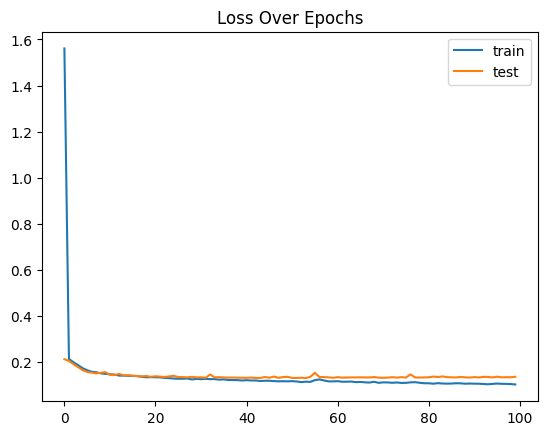

In [37]:
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

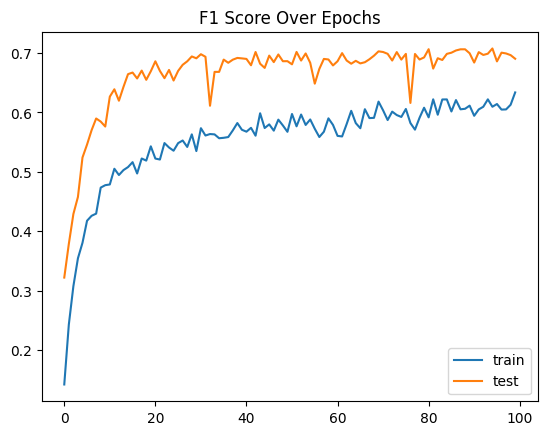

In [38]:
plt.plot(range(epochs), train_f1_scores, label='train')
plt.plot(range(epochs), test_f1_scores, label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [39]:
print(f'Best model achieved at epoch {np.argmax(test_f1_scores)} with F1 score {np.max(test_f1_scores)}')

Best model achieved at epoch 94 with F1 score 0.707740916271722


# Xgboost
### Dataset

In [ ]:
train_set = BaselineDataset()
test_set = BaselineDataset(path=TEST_PATH)

In [41]:
dtrain = xgb.DMatrix(torch.vstack(train_set.data).numpy(), label=train_set.target)
dtest = xgb.DMatrix(torch.vstack(test_set.data).numpy(), label=test_set.target)

### Model & Hyperparameter Tuning

In [9]:
def f1_calculator(pred, data):
    labels = data.get_label()
    pred = pred > 0.5
    return 'f1', f1_score(labels, pred)

In [70]:



def objective_2(trial):
    evals_results = {}
    param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'verbosity': 0}
    param['max_depth'] = trial.suggest_int('max_depth', 3, 10)
    param['eta'] = trial.suggest_float('eta', 0, 1e-1)
    param['gamma'] = trial.suggest_float('gamma', 0, 1e-1)
    param['alpha'] = trial.suggest_float('alpha', 0, 1e-1)
    param['lambda'] = trial.suggest_float('lambda', 0, 1e-1)
    param['subsamplea'] = trial.suggest_float('subsample', 0.5, 1)
    param['sampling_method'] = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    num_rounds = 100
    bst = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'test')], feval=f1_calculator, verbose_eval=False, evals_result=evals_results)
    return evals_results['test']['f1'][-1]


study = optuna.create_study(direction='maximize')
study.optimize(objective_2, n_trials=200)

[I 2023-04-27 12:37:08,014] A new study created in memory with name: no-name-6991b5c1-a06c-4294-8ffa-ec66497484f8
[I 2023-04-27 12:37:08,797] Trial 0 finished with value: 0.672978 and parameters: {'max_depth': 6, 'eta': 0.019398710310971956, 'gamma': 0.0278367935408146, 'alpha': 0.06437350628872666, 'lambda': 0.04640652003940772, 'subsample': 0.6098177641574065, 'sampling_method': 'uniform'}. Best is trial 0 with value: 0.672978.
[I 2023-04-27 12:37:09,310] Trial 1 finished with value: 0.659686 and parameters: {'max_depth': 3, 'eta': 0.02734503742396819, 'gamma': 0.00329052174322656, 'alpha': 0.09260136046301892, 'lambda': 0.04890020437861617, 'subsample': 0.6942280156792708, 'sampling_method': 'gradient_based'}. Best is trial 0 with value: 0.672978.
[I 2023-04-27 12:37:09,900] Trial 2 finished with value: 0.71346 and parameters: {'max_depth': 5, 'eta': 0.08302025409399177, 'gamma': 0.07458985062194029, 'alpha': 0.06450998980283751, 'lambda': 0.07141379523561849, 'subsample': 0.6238946

In [71]:
study.best_params

{'max_depth': 6,
 'eta': 0.09081514003358984,
 'gamma': 0.06642929982914873,
 'alpha': 0.0940319005665157,
 'lambda': 0.03697634500529317,
 'subsample': 0.6137676048529289,
 'sampling_method': 'gradient_based'}

In [10]:
evals_results = {}
param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'verbosity': 0, 'max_depth': 6,
 'eta': 0.09081514003358984,
 'gamma': 0.06642929982914873,
 'alpha': 0.0940319005665157,
 'lambda': 0.03697634500529317,
 'subsample': 0.6137676048529289,
 'sampling_method': 'gradient_based'}
num_rounds = 100
bst = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=False, feval=f1_calculator, evals_result=evals_results, maximize=True)

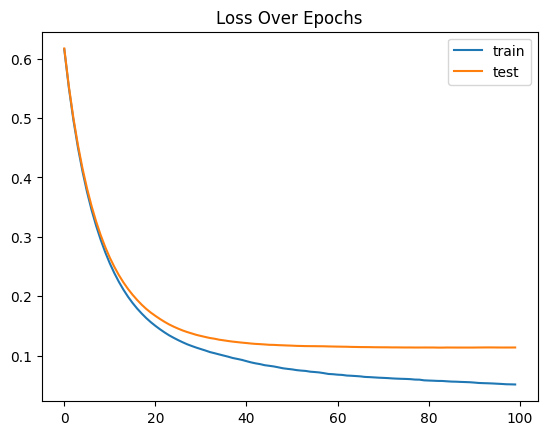

In [85]:
plt.plot(range(num_rounds), evals_results['train']['logloss'], label='train')
plt.plot(range(num_rounds), evals_results['test']['logloss'], label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

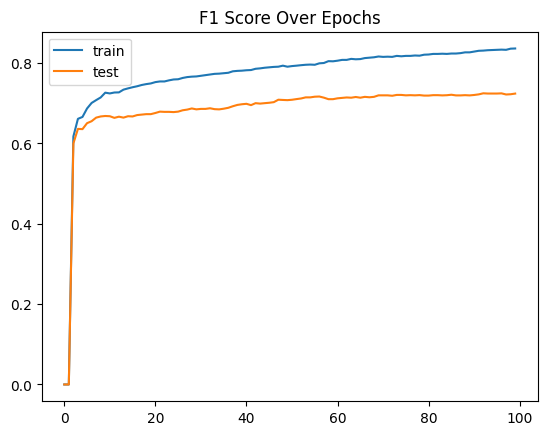

In [86]:
plt.plot(range(num_rounds), evals_results['train']['f1'], label='train')
plt.plot(range(num_rounds), evals_results['test']['f1'], label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [1]:
preds = [1 if item > 0.5 else 0 for item in bst.predict(dtest)]
f1_score(test_set.target, preds)

NameError: name 'bst' is not defined

In [88]:
bst.save_model('xgb.model')

In [5]:
bst = xgb.Booster()
bst.load_model('xgb.model')

Index(['ICULOS', 'Temp', 'SBP', 'HospAdmTime', 'WBC', 'HR', 'MAP', 'DBP',
       'O2Sat', 'Resp'],
      dtype='object')


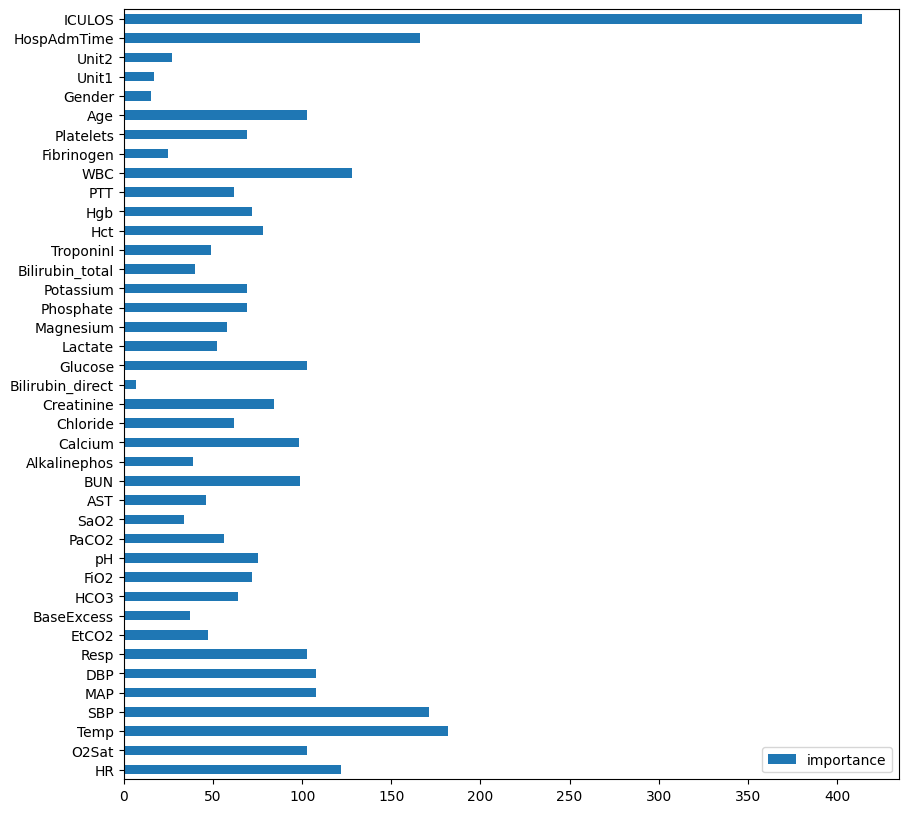

In [9]:
dic = bst.get_score()
columns = pd.read_csv(TRAIN_PATH + 'patient_0.psv', sep='|').columns
dic = {columns[int(key[1:])]: value for key, value in dic.items()}
df = pd.DataFrame(dic.values(), index=dic.keys(), columns=['importance'])
best_features_weight = df.nlargest(10, 'importance').index
print(df.nlargest(10, 'importance'))
df.plot(kind='barh', figsize=(10, 10))
plt.show()

            importance
ICULOS       54.291149
Unit2        12.916007
HCO3         11.680109
pH            9.166693
FiO2          8.769042
Lactate       8.311134
Temp          7.887246
SBP           7.371395
BaseExcess    6.268581
EtCO2         6.263094


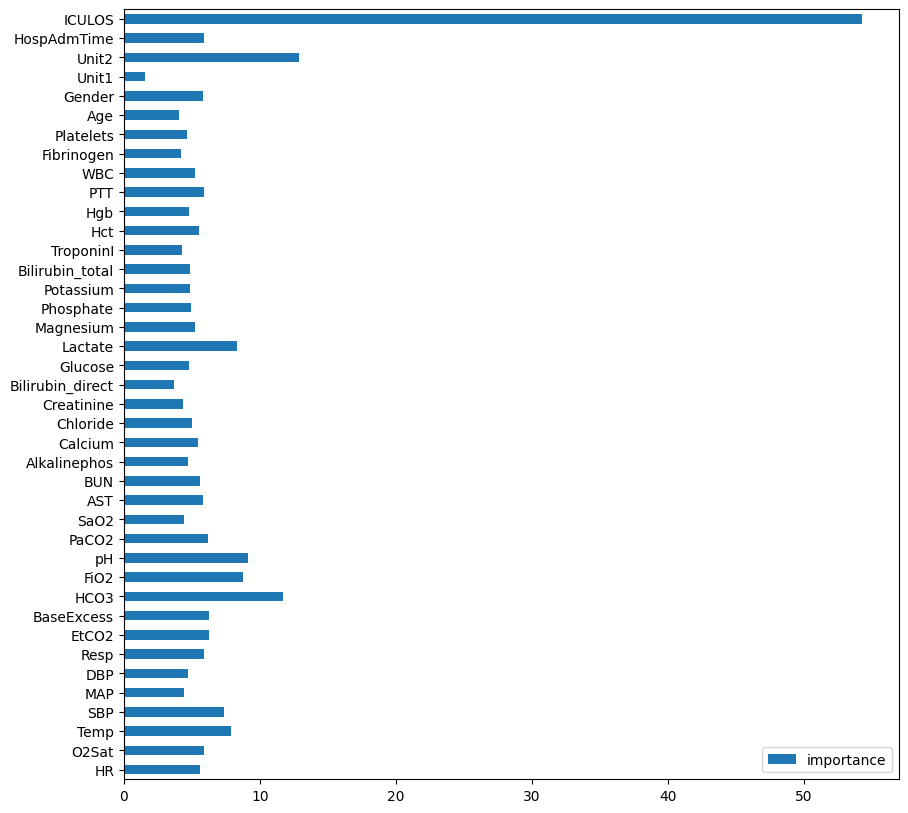

In [7]:
dic = bst.get_score(importance_type='gain')
columns = pd.read_csv(TRAIN_PATH + 'patient_0.psv', sep='|').columns
dic = {columns[int(key[1:])]: value for key, value in dic.items()}
df = pd.DataFrame(dic.values(), index=dic.keys(), columns=['importance'])
df.plot(kind='barh', figsize=(10, 10))
best_features_gain = df.nlargest(10, 'importance').index
print(df.nlargest(10, 'importance'))
plt.show()

# LSTM
### Dataset

In [14]:
class LSTMDataset(Dataset):
    def __init__(self, path=TRAIN_PATH, pad_to=400, pad=True, pad_value=0, features=None):
        self.data = []
        self.targets = []
        for file in os.listdir(path):
            df = pd.read_csv(os.path.join(path, file), sep='|')
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            df = df.drop('SepsisLabel', axis=1)
            if features is not None:
                df = df[features]
            if sepsis_index is not None:
                df = df.iloc[:sepsis_index+1]
                self.targets.append(1)
            else:
                self.targets.append(0)
            df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
            df['length'] = df.shape[0]
            data = torch.tensor(df.values, dtype=torch.float32)
            self.data.append(data)
            if pad:
                self.data[-1] = nn.functional.pad(self.data[-1], (0, 0, 0, pad_to - self.data[-1].shape[0]), value=pad_value)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [15]:
lstm_train_dataset = LSTMDataset()
lstm_test_dataset = LSTMDataset(path=TEST_PATH)
lstm_train_dataloader = DataLoader(lstm_train_dataset, batch_size=32, shuffle=True)
lstm_test_dataloader = DataLoader(lstm_test_dataset, batch_size=32, shuffle=True)
count_zero = sum([1 for x in lstm_train_dataset.targets if x == 0])
count_one = 20000 - count_zero

### Model

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size=40, in_channels=400, out_channels=40, hidden_size=128, num_layers=2, lstm_dropout=0.1, fc_dropout=0.1, bidirectional=True, conv_dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxpool = nn.MaxPool1d(4)
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, 3, padding=1), self.maxpool, nn.ReLU(), nn.Dropout(conv_dropout))
        self.lstm = nn.LSTM(int(embedding_size/4), hidden_size, num_layers, dropout=lstm_dropout, batch_first=True, bidirectional=bidirectional)
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(out_channels*(int(2*hidden_size) if bidirectional else int(hidden_size)), 2)

    def forward(self, x):
        out = self.conv(x)
        out, _ = self.lstm(out)
        out = self.fc_dropout(out)
        out = self.fc(out.reshape(x.shape[0], -1))
        return out

In [28]:
def lstm_objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lstm_dropout = trial.suggest_float('lstm_dropout', 0, 0.5)
    fc_dropout = trial.suggest_float('fc_dropout', 0, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    conv_dropout = trial.suggest_float('conv_dropout', 0, 0.5)
    out_channels = trial.suggest_int('out_channels', 1, 40)
    lr = trial.suggest_float('lr', 1e-4, 1e-1)
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, lstm_dropout=lstm_dropout, fc_dropout=fc_dropout, bidirectional=bidirectional, conv_dropout=conv_dropout, out_channels=out_channels)
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor([count_zero/count_zero, count_zero/count_one]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 15
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, model, lstm_train_dataloader, lstm_test_dataloader, epochs=num_epochs, save_best=False)
    return max(test_f1_scores)

study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(lstm_objective, n_trials=200)

[I 2023-05-04 16:28:17,548] A new study created in memory with name: no-name-31483355-90ea-4fa6-87d2-9de95e1b915d


Epoch: 1 Train Loss: 8.594797021222115 Test Loss: 5.546076706674221
Epoch: 2 Train Loss: 8.380803801531345 Test Loss: 7.665185094752867
Epoch: 3 Train Loss: 9.522974356085882 Test Loss: 3.4272890584156537
Epoch: 4 Train Loss: 8.482236680424197 Test Loss: 13.691410859310995
Epoch: 5 Train Loss: 9.312136276643223 Test Loss: 10.913170675291601
Epoch: 6 Train Loss: 8.367004083591583 Test Loss: 12.826751063397902
Epoch: 7 Train Loss: 7.377964137311069 Test Loss: 7.352889929732119
Epoch: 8 Train Loss: 7.312007855468971 Test Loss: 6.118878662091696
Epoch: 9 Train Loss: 7.397880266631511 Test Loss: 12.624009706616775
Epoch: 10 Train Loss: 8.288627397162351 Test Loss: 4.922699598681219
Epoch: 11 Train Loss: 7.676010857224185 Test Loss: 2.470712558530009
Epoch: 12 Train Loss: 7.85689916003308 Test Loss: 2.9532113885298705
Epoch: 13 Train Loss: 7.767226268958766 Test Loss: 3.2038418120985774
Epoch: 14 Train Loss: 7.8305049304246905 Test Loss: 4.147968319908585


[I 2023-05-04 16:29:02,547] Trial 0 finished with value: 0.5413402959094864 and parameters: {'hidden_size': 45, 'num_layers': 1, 'lstm_dropout': 0.43137705206491556, 'fc_dropout': 0.47646808704037263, 'bidirectional': True, 'conv_dropout': 0.4065848803765894, 'out_channels': 19, 'lr': 0.07710096326715982}. Best is trial 0 with value: 0.5413402959094864.


Epoch: 15 Train Loss: 7.643454411679507 Test Loss: 6.464163801466963
Epoch: 1 Train Loss: 0.4595933825612068 Test Loss: 0.41295174161751813
Epoch: 2 Train Loss: 0.40749446564912795 Test Loss: 0.42567724625047404
Epoch: 3 Train Loss: 0.40088148475885393 Test Loss: 0.40127166704581185
Epoch: 4 Train Loss: 0.39890213032364846 Test Loss: 0.42999844023356804
Epoch: 5 Train Loss: 0.3929576393485069 Test Loss: 0.37949450634205684
Epoch: 6 Train Loss: 0.3989578432917595 Test Loss: 0.3953748320619138
Epoch: 7 Train Loss: 0.40214486006498334 Test Loss: 0.3875649887294815
Epoch: 8 Train Loss: 0.3955847009718418 Test Loss: 0.38044381358276924
Epoch: 9 Train Loss: 0.38839554253816605 Test Loss: 0.4153427383698785
Epoch: 10 Train Loss: 0.39216132558584216 Test Loss: 0.37435643108317646
Epoch: 11 Train Loss: 0.3871123900294304 Test Loss: 0.3846576838447644
Epoch: 12 Train Loss: 0.3891987151503563 Test Loss: 0.3758724769369101
Epoch: 13 Train Loss: 0.3797819668769836 Test Loss: 0.38811491083460875
Epo

[I 2023-05-04 16:29:49,140] Trial 1 finished with value: 0.6925329428989752 and parameters: {'hidden_size': 47, 'num_layers': 2, 'lstm_dropout': 0.2572139714946476, 'fc_dropout': 0.46111857554514946, 'bidirectional': False, 'conv_dropout': 0.1226616013926623, 'out_channels': 33, 'lr': 0.00197701894259796}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 0.38126833226680756 Test Loss: 0.37914540442510153
Epoch: 1 Train Loss: 18.005121337225013 Test Loss: 2.416194126015148
Epoch: 2 Train Loss: 16.745602019851127 Test Loss: 9.25155320182776
Epoch: 3 Train Loss: 18.9438821320096 Test Loss: 5.793195716766588
Epoch: 4 Train Loss: 19.736238018783506 Test Loss: 1.4586541838467884
Epoch: 5 Train Loss: 20.859788850536383 Test Loss: 7.161001411776047
Epoch: 6 Train Loss: 22.731278842004187 Test Loss: 16.744191790006106
Epoch: 7 Train Loss: 20.037078052690894 Test Loss: 22.632287061063394
Epoch: 8 Train Loss: 22.67069105889035 Test Loss: 46.10271698217422
Epoch: 9 Train Loss: 23.887435158474844 Test Loss: 5.0762398479083854
Epoch: 10 Train Loss: 23.68883568522945 Test Loss: 94.14435786561083
Epoch: 11 Train Loss: 28.860539671353962 Test Loss: 4.533321338748949
Epoch: 12 Train Loss: 28.275140519369092 Test Loss: 9.619204236926457
Epoch: 13 Train Loss: 28.46022362677291 Test Loss: 2.227684261170201
Epoch: 14 Train Loss: 25.958

[I 2023-05-04 16:31:31,946] Trial 2 finished with value: 0.5736981465136805 and parameters: {'hidden_size': 243, 'num_layers': 2, 'lstm_dropout': 0.3587372467694111, 'fc_dropout': 0.39123875794564805, 'bidirectional': False, 'conv_dropout': 0.09370373859764936, 'out_channels': 31, 'lr': 0.07650994765000606}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 23.581777681801565 Test Loss: 5.261113152926273
Epoch: 1 Train Loss: 2.0256034624814987 Test Loss: 1.8069590657712153
Epoch: 2 Train Loss: 1.1060206205911935 Test Loss: 0.5384252700990382
Epoch: 3 Train Loss: 1.159028431813419 Test Loss: 1.0879246671550191
Epoch: 4 Train Loss: 1.0372047825723887 Test Loss: 0.8399650288846927
Epoch: 5 Train Loss: 0.9241907647818327 Test Loss: 0.6163938539668014
Epoch: 6 Train Loss: 0.8262587426900864 Test Loss: 0.5640515671751369
Epoch: 7 Train Loss: 0.7338485226571559 Test Loss: 0.7417941257809869
Epoch: 8 Train Loss: 0.8673434915199876 Test Loss: 0.5173178771719004
Epoch: 9 Train Loss: 0.9988869895935059 Test Loss: 0.5787069805133076
Epoch: 10 Train Loss: 1.189457522945106 Test Loss: 0.7490398043248886
Epoch: 11 Train Loss: 1.1479051653541625 Test Loss: 1.9227427313268481
Epoch: 12 Train Loss: 1.6210112265255303 Test Loss: 0.7282620892077446
Epoch: 13 Train Loss: 1.6046673965334892 Test Loss: 0.7028871983789597
Epoch: 14 Train Lo

[I 2023-05-04 16:33:10,965] Trial 3 finished with value: 0.6229508196721312 and parameters: {'hidden_size': 173, 'num_layers': 2, 'lstm_dropout': 0.2787647147449923, 'fc_dropout': 0.4726263805086861, 'bidirectional': False, 'conv_dropout': 0.008709492256589735, 'out_channels': 9, 'lr': 0.07040390231329481}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 1.6782371363297104 Test Loss: 0.6338391698206576
Epoch: 1 Train Loss: 0.8496956696331501 Test Loss: 0.6277004779337313
Epoch: 2 Train Loss: 0.7664224601681344 Test Loss: 0.7374232258980933
Epoch: 3 Train Loss: 0.8803490100094117 Test Loss: 0.561229441802913
Epoch: 4 Train Loss: 1.1173816935948095 Test Loss: 0.6070438527856201
Epoch: 5 Train Loss: 0.7590346745951101 Test Loss: 0.6422870304233159
Epoch: 6 Train Loss: 0.5994508216272109 Test Loss: 0.5487310640728131
Epoch: 7 Train Loss: 0.6508056547857821 Test Loss: 0.47266465104140415
Epoch: 8 Train Loss: 0.744264001995977 Test Loss: 1.1058875240456945
Epoch: 9 Train Loss: 1.1432626333968714 Test Loss: 2.131289265824505
Epoch: 10 Train Loss: 1.0520847355261445 Test Loss: 0.7171979412888757
Epoch: 11 Train Loss: 1.320088116224465 Test Loss: 1.2378761925445958
Epoch: 12 Train Loss: 1.0268817878522911 Test Loss: 1.793352137204816
Epoch: 13 Train Loss: 1.1743704665231693 Test Loss: 0.6353231821054468
Epoch: 14 Train Los

[I 2023-05-04 16:34:15,525] Trial 4 finished with value: 0.6417352281226627 and parameters: {'hidden_size': 116, 'num_layers': 1, 'lstm_dropout': 0.09450529543622249, 'fc_dropout': 0.17112694422054342, 'bidirectional': False, 'conv_dropout': 0.03103554232063921, 'out_channels': 12, 'lr': 0.022969016829629173}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 0.917763315210864 Test Loss: 0.8184106621843653
Epoch: 1 Train Loss: 1.3624023737096256 Test Loss: 0.5096496072011634
Epoch: 2 Train Loss: 0.5789451429843903 Test Loss: 0.527386718902725
Epoch: 3 Train Loss: 0.687478259730339 Test Loss: 0.6027654945469512
Epoch: 4 Train Loss: 0.8020789291113615 Test Loss: 2.4694350403017116
Epoch: 5 Train Loss: 3.644797950740494 Test Loss: 3.518362377523115
Epoch: 6 Train Loss: 5.533451927384306 Test Loss: 2.9504402284366424
Epoch: 7 Train Loss: 4.7672190642537755 Test Loss: 10.426423138964417
Epoch: 8 Train Loss: 4.322497944811857 Test Loss: 3.4580234364126574
Epoch: 9 Train Loss: 4.980051066687603 Test Loss: 7.355436992053645
Epoch: 10 Train Loss: 5.411373639881451 Test Loss: 2.8573841306292054
Epoch: 11 Train Loss: 3.5271128178665507 Test Loss: 1.2133203724893138
Epoch: 12 Train Loss: 4.390750862276503 Test Loss: 2.3188913580342954
Epoch: 13 Train Loss: 4.81728231110873 Test Loss: 4.000788278761237
Epoch: 14 Train Loss: 6.00262

[I 2023-05-04 16:37:26,709] Trial 5 finished with value: 0.6317596566523606 and parameters: {'hidden_size': 171, 'num_layers': 2, 'lstm_dropout': 0.42716070055008654, 'fc_dropout': 0.33655509613628803, 'bidirectional': True, 'conv_dropout': 0.31517885656586875, 'out_channels': 25, 'lr': 0.029687368432037956}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 7.390691096444076 Test Loss: 6.411249316663258
Epoch: 1 Train Loss: 0.6433828420877457 Test Loss: 0.6220686874641016
Epoch: 2 Train Loss: 0.6289916877269744 Test Loss: 0.6019487804212509
Epoch: 3 Train Loss: 0.6546089387774467 Test Loss: 0.5899255420453251
Epoch: 4 Train Loss: 0.6584240575194359 Test Loss: 0.6118142501995586
Epoch: 5 Train Loss: 0.6556833379209042 Test Loss: 0.6420356201858947
Epoch: 6 Train Loss: 0.6408365086436272 Test Loss: 0.5915502141268489
Epoch: 7 Train Loss: 0.6760275681883097 Test Loss: 0.595008726794118
Epoch: 8 Train Loss: 0.6572842495024204 Test Loss: 0.6326532693335805
Epoch: 9 Train Loss: 0.730668386644125 Test Loss: 1.0380637837401308
Epoch: 10 Train Loss: 0.8598803185559809 Test Loss: 0.6165568207780393
Epoch: 11 Train Loss: 0.8099479931600392 Test Loss: 0.9721706863909293
Epoch: 12 Train Loss: 0.738596066018939 Test Loss: 0.6005566221551774
Epoch: 13 Train Loss: 0.7594319887980818 Test Loss: 1.027991465438669
Epoch: 14 Train Loss:

[I 2023-05-04 16:39:01,840] Trial 6 finished with value: 0.4295991778006167 and parameters: {'hidden_size': 43, 'num_layers': 2, 'lstm_dropout': 0.01073328400818363, 'fc_dropout': 0.22593064606955454, 'bidirectional': True, 'conv_dropout': 0.14948259029188948, 'out_channels': 3, 'lr': 0.07796347517858734}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 0.7566906821697951 Test Loss: 0.8136183972747181
Epoch: 1 Train Loss: 9.967738472533226 Test Loss: 6.4751110713042435
Epoch: 2 Train Loss: 13.756997927313732 Test Loss: 9.203172022778402
Epoch: 3 Train Loss: 14.579023038202275 Test Loss: 9.468476191166202
Epoch: 4 Train Loss: 15.98761108809566 Test Loss: 10.26710489126111
Epoch: 5 Train Loss: 16.197921595629783 Test Loss: 9.871881831723407
Epoch: 6 Train Loss: 16.410402126288904 Test Loss: 15.163929357118672
Epoch: 7 Train Loss: 16.960025709696712 Test Loss: 10.707970371587646
Epoch: 8 Train Loss: 17.469705278349313 Test Loss: 15.913997226637868
Epoch: 9 Train Loss: 18.0187561919168 Test Loss: 9.239074984151854
Epoch: 10 Train Loss: 16.45225711440444 Test Loss: 9.838417790249832
Epoch: 11 Train Loss: 15.95759241408169 Test Loss: 5.050479143120039
Epoch: 12 Train Loss: 18.03873810184328 Test Loss: 8.336668843257224
Epoch: 13 Train Loss: 21.149223596306392 Test Loss: 16.08335703812687
Epoch: 14 Train Loss: 21.396282

[I 2023-05-04 16:41:15,176] Trial 7 finished with value: 0.6309937456567061 and parameters: {'hidden_size': 177, 'num_layers': 1, 'lstm_dropout': 0.2005599236019816, 'fc_dropout': 0.44926577544596885, 'bidirectional': True, 'conv_dropout': 0.19962527725993479, 'out_channels': 24, 'lr': 0.033807875223926996}. Best is trial 1 with value: 0.6925329428989752.


Epoch: 15 Train Loss: 20.31769897387028 Test Loss: 29.311508163476525
Epoch: 1 Train Loss: 0.8083187715649605 Test Loss: 0.48034241157598767
Epoch: 2 Train Loss: 0.5136236246705055 Test Loss: 0.45505150098103686
Epoch: 3 Train Loss: 0.5238264413297177 Test Loss: 0.4845665375264689
Epoch: 4 Train Loss: 0.5103771368026734 Test Loss: 0.526298452394839
Epoch: 5 Train Loss: 0.5246179147601128 Test Loss: 0.45747771225988676
Epoch: 6 Train Loss: 0.5002740972042083 Test Loss: 0.49193666625422794
Epoch: 7 Train Loss: 0.5215855711460113 Test Loss: 0.4702615038560221


[W 2023-05-04 16:41:39,934] Trial 8 failed with parameters: {'hidden_size': 78, 'num_layers': 2, 'lstm_dropout': 0.20118176487289324, 'fc_dropout': 0.19197887489787457, 'bidirectional': False, 'conv_dropout': 0.25368279718045106, 'out_channels': 33, 'lr': 0.05449422385444316} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\10\anaconda3\envs\hw1_env\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\10\AppData\Local\Temp\ipykernel_24960\4027523501.py", line 15, in lstm_objective
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, model, lstm_train_dataloader, lstm_test_dataloader, epochs=num_epochs, save_best=False)
  File "C:\Users\10\AppData\Local\Temp\ipykernel_24960\3933135263.py", line 32, in train
    test_loss, test_f1_score = activity(model, test_dataloader, loss_fn, device)
  File "C:\Users\10\AppData\Local\Temp\

KeyboardInterrupt: 

In [15]:
params = {'hidden_size': 100, 'num_layers': 1, 'lstm_dropout': 0.037362422729387564, 'fc_dropout': 0.056950385586254704, 'bidirectional': True, 'conv_dropout': 0.03382773386464591, 'out_channels': 23}
lr = 0.00017556097900833128

In [21]:
epochs = 100
lstm = LSTMModel(**params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, lstm, lstm_train_dataloader, lstm_test_dataloader, epochs=epochs, save_best=True, save_name='best_rnn_model.pt')

Epoch: 1 Train Loss: 0.15775358920693397 Test Loss: 0.13945070011451982
Epoch: 2 Train Loss: 0.13153264140337706 Test Loss: 0.1356905595170328
Epoch: 3 Train Loss: 0.12760779098719358 Test Loss: 0.13241761476813127
Epoch: 4 Train Loss: 0.12434698716774582 Test Loss: 0.13772318799334307
Epoch: 5 Train Loss: 0.12146178620755672 Test Loss: 0.1339522316700782
Epoch: 6 Train Loss: 0.11988770780563354 Test Loss: 0.13076347864854831
Epoch: 7 Train Loss: 0.11655283272266388 Test Loss: 0.13099912149956622
Epoch: 8 Train Loss: 0.11543762973099947 Test Loss: 0.13369365034702296
Epoch: 9 Train Loss: 0.11243001575767994 Test Loss: 0.13813609065720067
Epoch: 10 Train Loss: 0.11031396798789501 Test Loss: 0.1329856232082406
Epoch: 11 Train Loss: 0.10807826085239648 Test Loss: 0.1325424310956567
Epoch: 12 Train Loss: 0.10734562361985445 Test Loss: 0.13862164418983716
Epoch: 13 Train Loss: 0.10525199927911162 Test Loss: 0.13541892017966833
Epoch: 14 Train Loss: 0.10402527977079153 Test Loss: 0.136085070

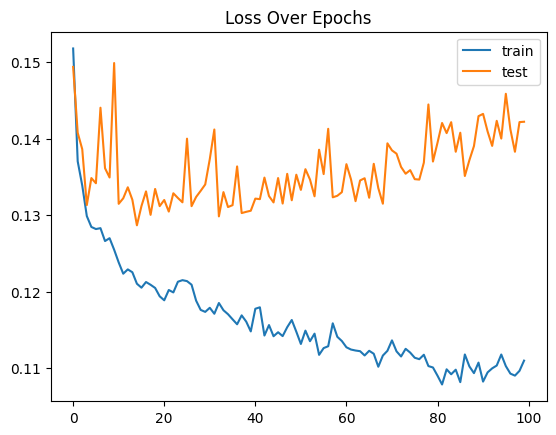

In [38]:
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

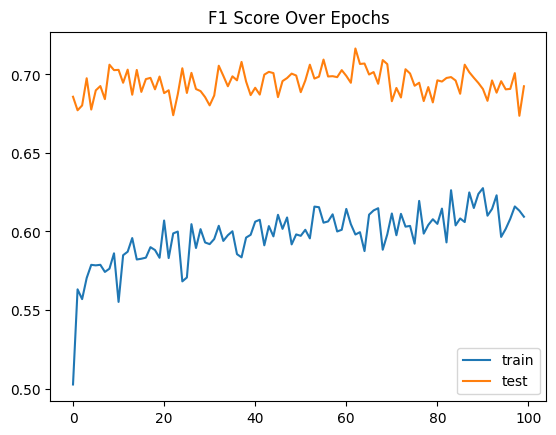

In [39]:
plt.plot(range(epochs), train_f1_scores, label='train')
plt.plot(range(epochs), test_f1_scores, label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [24]:
max(test_f1_scores)

0.702446724546172

In [35]:
lstm_train_dataloader3 = DataLoader(LSTMDataset(features=df.nlargest(10, 'importance').index), batch_size=32, shuffle=True)
lstm_test_dataloader3 = DataLoader(LSTMDataset(path=TEST_PATH, features=df.nlargest(10, 'importance').index), batch_size=32, shuffle=True)

In [35]:
epochs = 100
lstm = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())
train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, lstm, lstm_train_dataloader, lstm_test_dataloader, epochs=epochs, save_best=True, save_name='best_rnn_model2.pt')

Epoch: 1 Train Loss: 0.15180624958500266 Test Loss: 0.14939488253940028
Epoch: 2 Train Loss: 0.13704586879611017 Test Loss: 0.1407839749544002
Epoch: 3 Train Loss: 0.13388009961247443 Test Loss: 0.13862963453435098
Epoch: 4 Train Loss: 0.12988863749578594 Test Loss: 0.1313244348969132
Epoch: 5 Train Loss: 0.12846568330004812 Test Loss: 0.13485761825292827
Epoch: 6 Train Loss: 0.12819093562960623 Test Loss: 0.13418068405324088
Epoch: 7 Train Loss: 0.12830741591528058 Test Loss: 0.14405967226733987
Epoch: 8 Train Loss: 0.1266198003642261 Test Loss: 0.13614596425594327
Epoch: 9 Train Loss: 0.12699500074163078 Test Loss: 0.1349320092711586
Epoch: 10 Train Loss: 0.12548911842405797 Test Loss: 0.14990443275711787
Epoch: 11 Train Loss: 0.12382471409589052 Test Loss: 0.13148964609141453
Epoch: 12 Train Loss: 0.12235228712260723 Test Loss: 0.13221405628033148
Epoch: 13 Train Loss: 0.12291427077502012 Test Loss: 0.13365268840576514
Epoch: 14 Train Loss: 0.12254105116277933 Test Loss: 0.132024303

In [37]:
max(test_f1_scores)

0.7164906580016247

In [256]:
model = torch.load('best_rnn_model2.pt')
model.eval()
real = []
pred = [] 
for x, y in lstm_test_dataloader3:
    x = x.to(device)
    y = y.to(device)
    real.append(y)
    out = model(x)
    pred.append(torch.argmax(out, dim=1))
print(f1_score(torch.cat(real).cpu(), torch.cat(pred).cpu()))

0.7133956386292835
